In [44]:
from qiskit import QuantumCircuit, transpile,QuantumRegister
from qiskit.visualization import plot_bloch_multivector, plot_state_city
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_state_city
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT , Diagonal
from qiskit.quantum_info import Kraus
%matplotlib inline

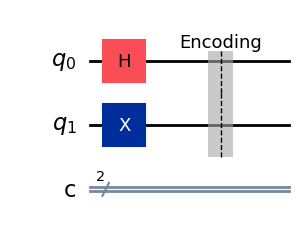

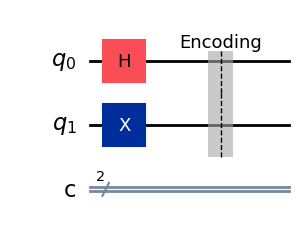

In [45]:
qc = QuantumCircuit(2, 2)

# Encode |00> + |10>
qc.h(0)
qc.x(1)

qc.barrier(label="Encoding")
display(qc.draw('mpl'))

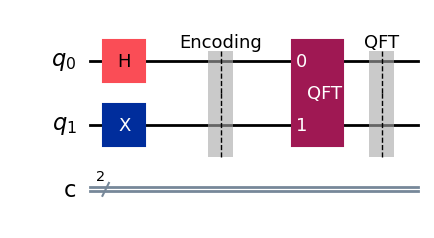

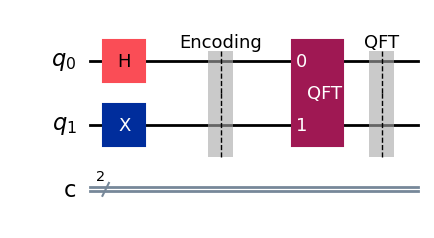

In [46]:
qft = QFT(2, do_swaps=True)
qc.append(qft, [0, 1])

qc.barrier(label="QFT")
display(qc.draw('mpl'))

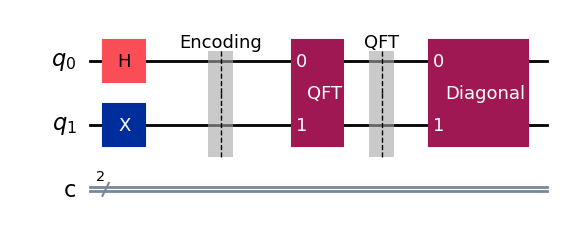

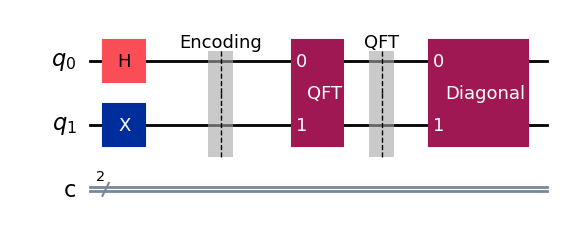

In [47]:
theta = [0.0, 0.3, 0.0, -0.3]  # θ0, θ1, θ2, θ3

phase_unitary = Diagonal([
    np.exp(1j * theta[0]),
    np.exp(1j * theta[1]),
    np.exp(1j * theta[2]),
    np.exp(1j * theta[3]),
])

qc.append(phase_unitary, [0, 1])
display(qc.draw('mpl'))

In [48]:
gamma = 0.2  # loss strength (controls α)

K0 = np.array([[1, 0], [0, np.sqrt(1 - gamma)]])
K1 = np.array([[0, np.sqrt(gamma)], [0, 0]])

amp_damp = Kraus([K0, K1])


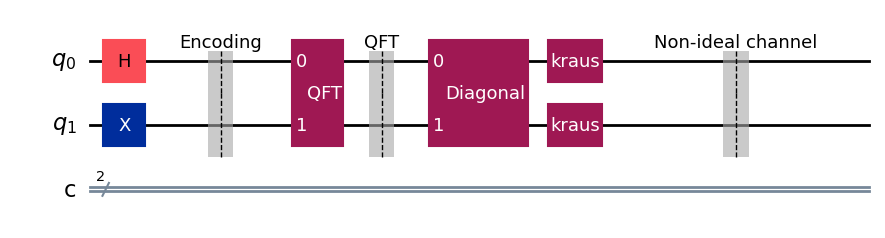

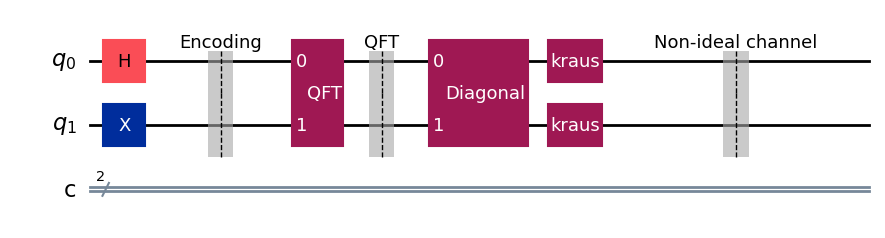

In [49]:
qc.append(amp_damp, [0])
qc.append(amp_damp, [1])

qc.barrier(label="Non-ideal channel")
display(qc.draw('mpl'))

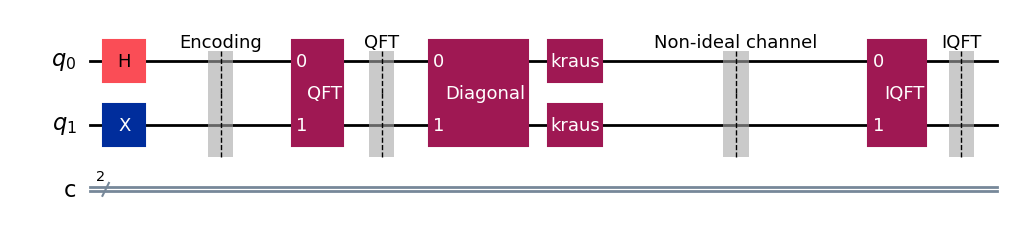

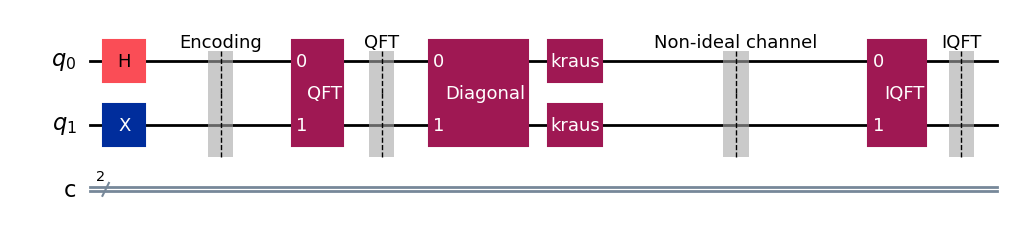

In [50]:
iqft = QFT(2, inverse=True, do_swaps=True)
qc.append(iqft, [0, 1])

qc.barrier(label="IQFT")
display(qc.draw('mpl'))

Figure(1457.85x284.278)


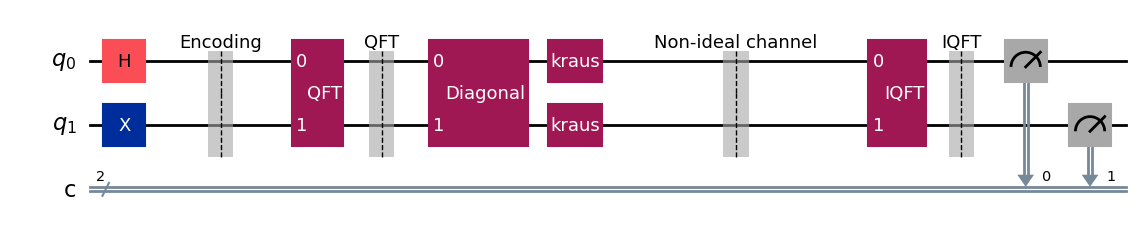

{'10': 342, '11': 573, '00': 52, '01': 57}
Measurement results:
10 342
11 573
00 52
01 57


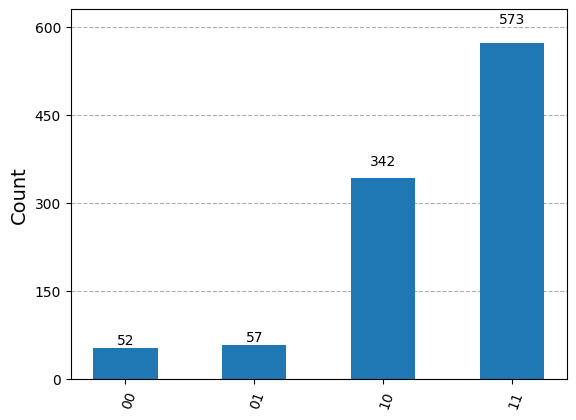

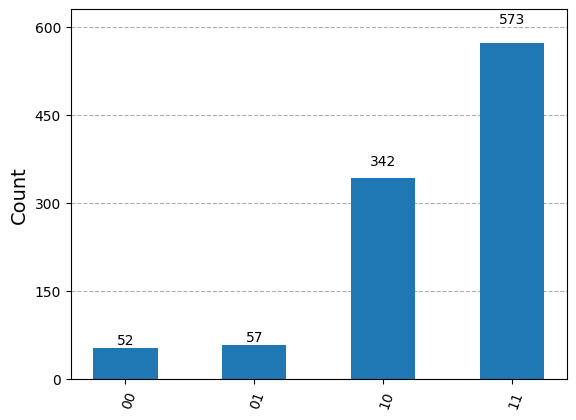

In [51]:
qc.measure(qc.qubits, qc.clbits)
print(qc.draw('mpl'))
plt.show()
#qc.measure_all()
sim = AerSimulator()
job = sim.run(transpile(qc, sim), shots=1024)
counts = job.result().get_counts()
print(counts)

#counts = result.get_counts(qc)  # qc is the circuit object
print("Measurement results:")
for outcome, count in counts.items():
    print(outcome, count)

plot_histogram(counts)

In [52]:
error_counts = sum(v for k, v in counts.items() if k not in ['00', '10'])
qber = error_counts / 4096
print("QBER =", qber)


QBER = 0.15380859375


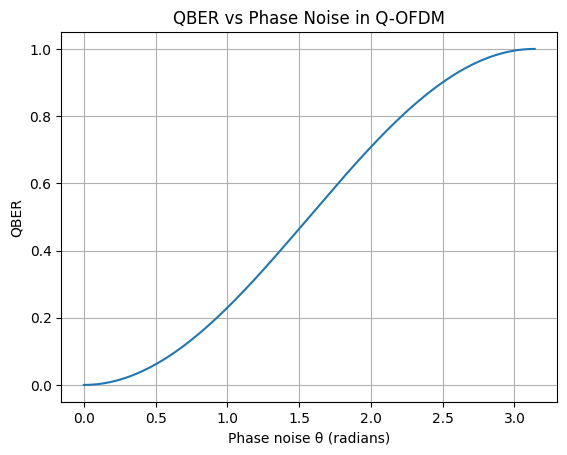

In [53]:
import numpy as np
import matplotlib.pyplot as plt

theta = np.linspace(0, np.pi, 200) #Creates 200 values of θ between 0 and π ,θ is the relative phase difference
                                   #Covers: perfect synchronization (θ = 0)  ,maximal phase mismatch (θ = π)
qber_theta = np.sin(theta/2)**2    #QBER=sin2(θ/2) Each θ value maps to one QBER value

plt.figure()
plt.plot(theta, qber_theta)
plt.xlabel("Phase noise θ (radians)")
plt.ylabel("QBER")
plt.title("QBER vs Phase Noise in Q-OFDM")
plt.grid(True)
plt.show()


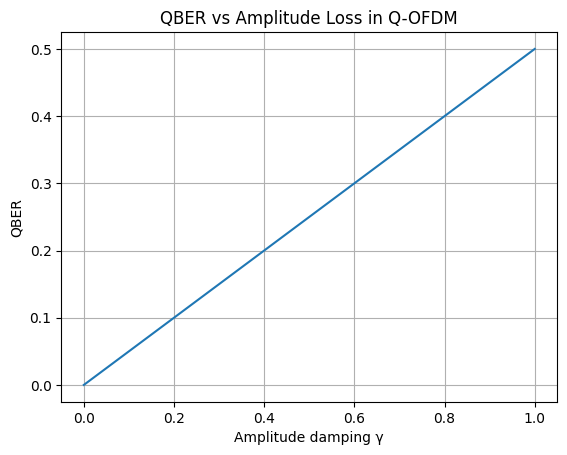

In [54]:
gamma = np.linspace(0, 1, 200)
qber_gamma = gamma / 2

plt.figure()
plt.plot(gamma, qber_gamma)
plt.xlabel("Amplitude damping γ")
plt.ylabel("QBER")
plt.title("QBER vs Amplitude Loss in Q-OFDM")
plt.grid(True)
plt.show()


In [55]:
from qiskit import QuantumCircuit, transpile,QuantumRegister
from qiskit.visualization import plot_bloch_multivector, plot_state_city
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_state_city
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT , Diagonal
from qiskit.quantum_info import Kraus
%matplotlib inline

In [56]:
def run_qofdm(theta_val=0.0, gamma_val=0.0, shots=2048):
    """
    Runs a 2-qubit Q-OFDM system and returns QBER
    """

    #backend = Aer.get_backend('qasm_simulator')

    # -------------------------
    # Step 1: Encoding
    # |psi> = (|0> + |2>)/sqrt(2)
    # -------------------------
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.x(1)

    # -------------------------
    # Step 2: QFT
    # -------------------------
    qc.append(QFT(2, do_swaps=True), [0, 1])

    # -------------------------
    # Step 3.1: Phase distortion (theta_k)
    # -------------------------
    theta = [0.0, theta_val, 0.0, -theta_val]

    phase_gate = Diagonal([
        np.exp(1j * theta[0]),
        np.exp(1j * theta[1]),
        np.exp(1j * theta[2]),
        np.exp(1j * theta[3]),
    ])
    qc.append(phase_gate, [0, 1])

    # -------------------------
    # Step 3.2: Amplitude damping (gamma)
    # -------------------------
    if gamma_val > 0:
        K0 = np.array([[1, 0], [0, np.sqrt(1 - gamma_val)]])
        K1 = np.array([[0, np.sqrt(gamma_val)], [0, 0]])
        amp_damp = Kraus([K0, K1])
        qc.append(amp_damp, [0])
        qc.append(amp_damp, [1])

    # -------------------------
    # Step 4: IQFT
    # -------------------------
    qc.append(QFT(2, inverse=True, do_swaps=True), [0, 1])

    # -------------------------
    # Step 5: Measurement
    # -------------------------
    qc.measure([0, 1], [0, 1])

    # -------------------------
    # Run simulation
    # -------------------------
    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled, shots=1024).result()
    counts = result.get_counts()

    print("Measurement results (bitstrings):")
    print(counts)
    plot_histogram(counts)
    plt.show()

    # -------------------------
    # QBER calculation
    # Intended symbols: 00 and 10
    # -------------------------
    error_counts = sum(v for k, v in counts.items() if k not in ['00', '10'])
    qber = error_counts / shots

    return qber


Measurement results (bitstrings):
{'10': 518, '11': 506}


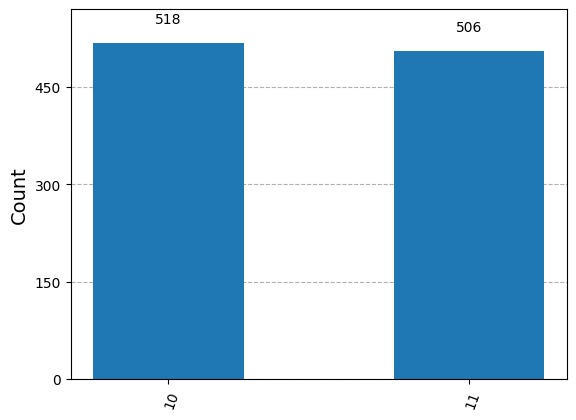

Measurement results (bitstrings):
{'10': 407, '11': 607, '00': 7, '01': 3}


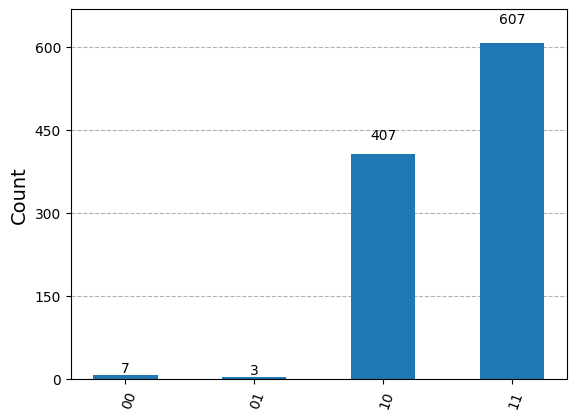

Measurement results (bitstrings):
{'11': 702, '01': 17, '10': 271, '00': 34}


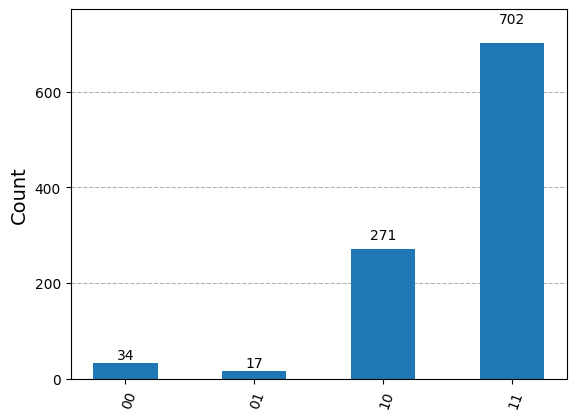

Measurement results (bitstrings):
{'10': 175, '11': 749, '00': 75, '01': 25}


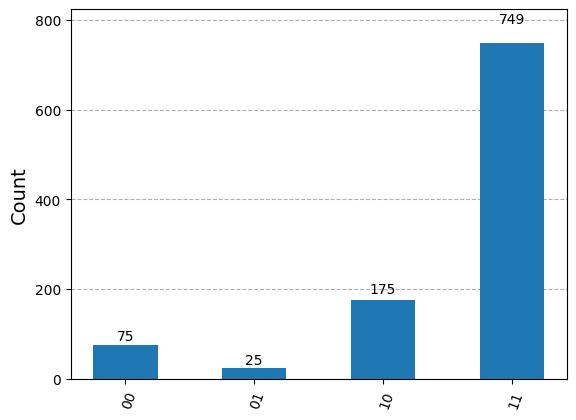

Measurement results (bitstrings):
{'11': 741, '10': 85, '00': 178, '01': 20}


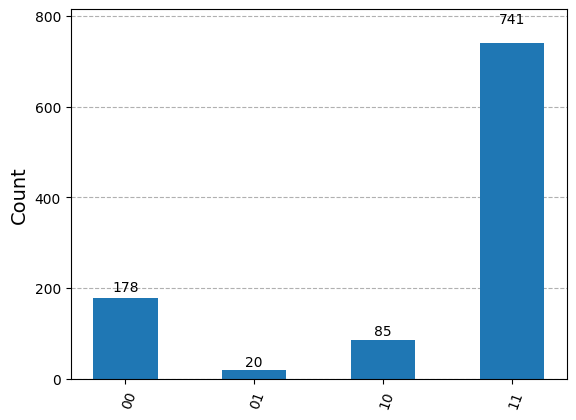

Measurement results (bitstrings):
{'11': 688, '00': 273, '10': 44, '01': 19}


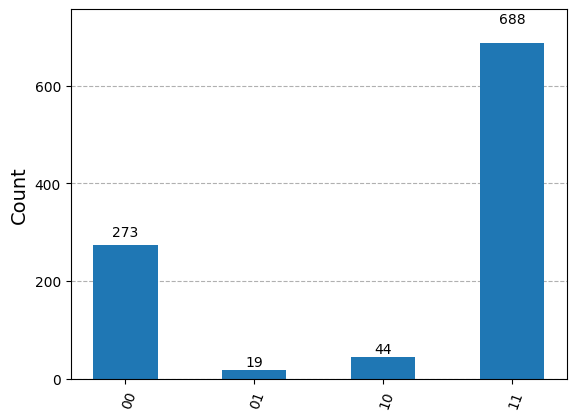

Measurement results (bitstrings):
{'11': 623, '00': 388, '10': 9, '01': 4}


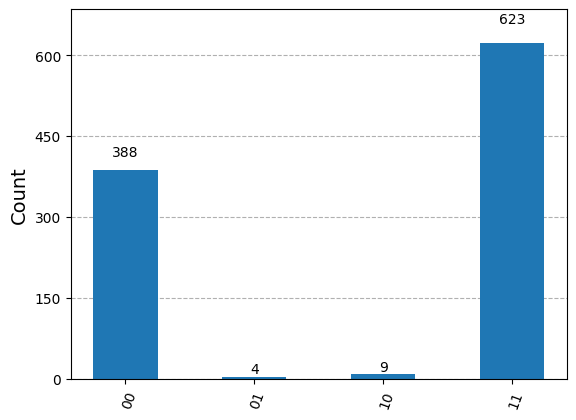

Measurement results (bitstrings):
{'00': 503, '11': 521}


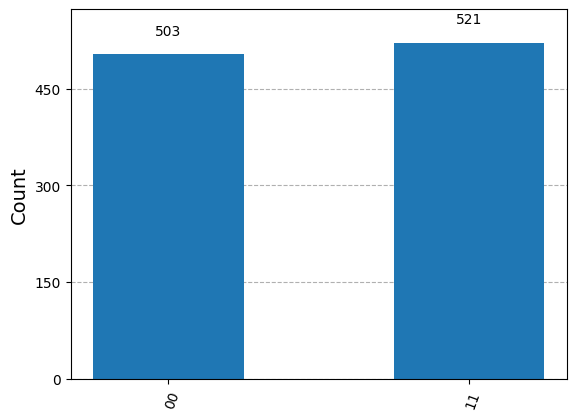

Measurement results (bitstrings):
{'00': 613, '11': 405, '01': 3, '10': 3}


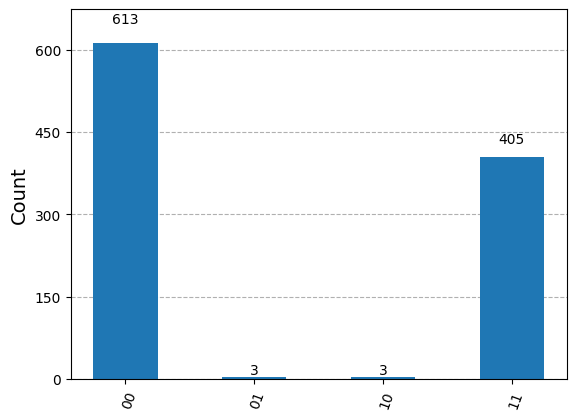

Measurement results (bitstrings):
{'00': 719, '01': 34, '11': 258, '10': 13}


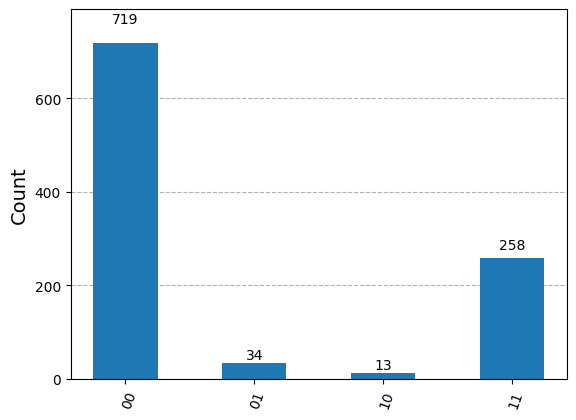

Measurement results (bitstrings):
{'00': 729, '01': 90, '11': 182, '10': 23}


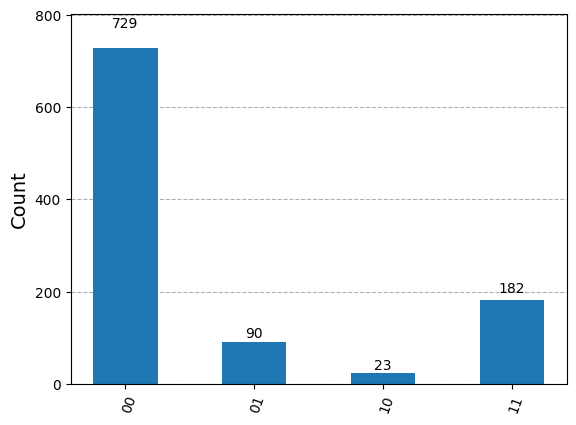

Measurement results (bitstrings):
{'00': 746, '11': 89, '01': 170, '10': 19}


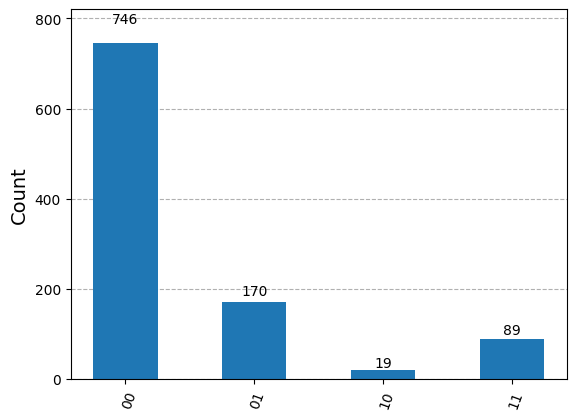

Measurement results (bitstrings):
{'01': 303, '00': 678, '10': 11, '11': 32}


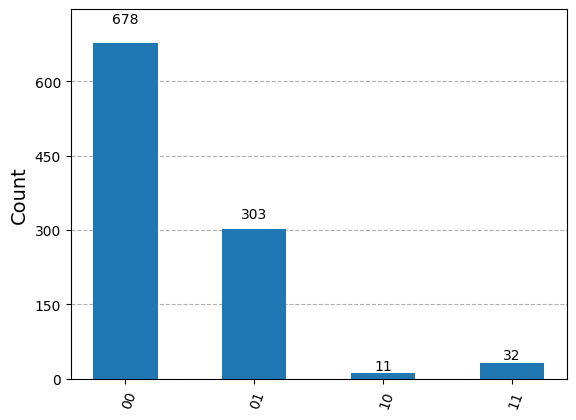

Measurement results (bitstrings):
{'01': 383, '00': 628, '10': 5, '11': 8}


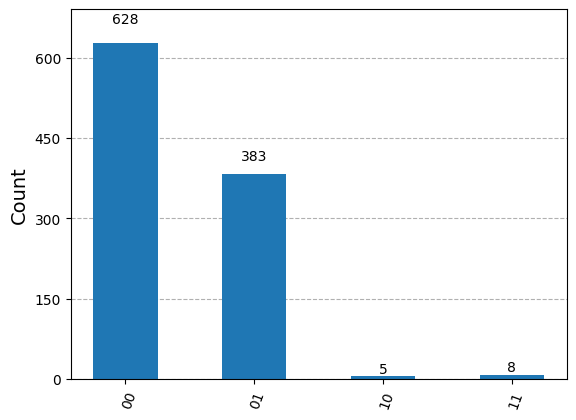

Measurement results (bitstrings):
{'01': 496, '00': 528}


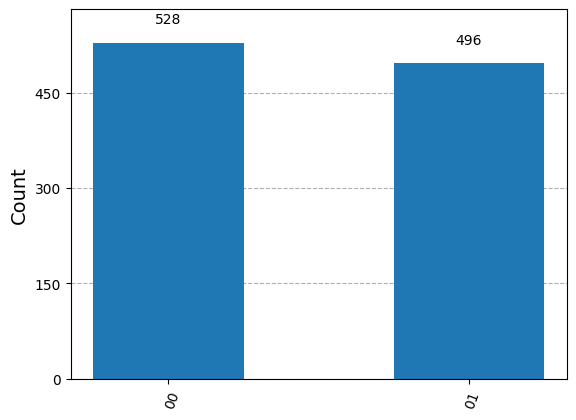

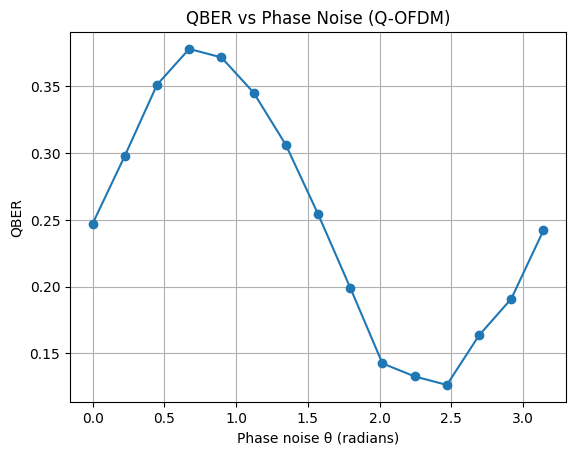

In [57]:
import matplotlib.pyplot as plt
import numpy as np

theta_vals = np.linspace(0, np.pi, 15)
qber_vals = []

for t in theta_vals:
    qber_vals.append(run_qofdm(theta_val=t, gamma_val=0.0))

plt.figure()
plt.plot(theta_vals, qber_vals, marker='o')
plt.xlabel("Phase noise θ (radians)")
plt.ylabel("QBER")
plt.title("QBER vs Phase Noise (Q-OFDM)")
plt.grid(True)
plt.show()


Measurement results (bitstrings):
{'11': 493, '10': 531}


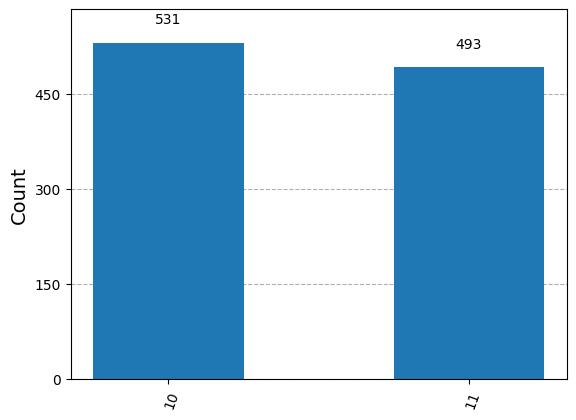

Measurement results (bitstrings):
{'10': 515, '11': 499, '00': 6, '01': 4}


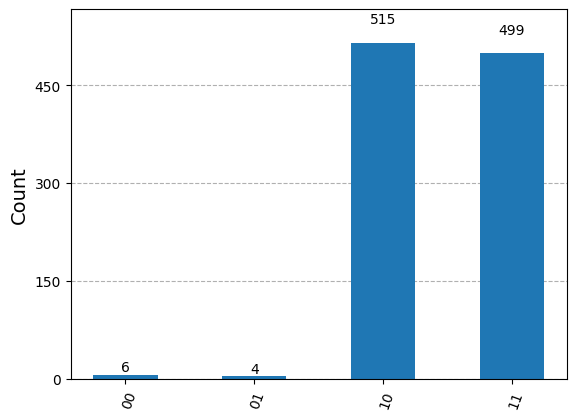

Measurement results (bitstrings):
{'10': 499, '11': 498, '00': 17, '01': 10}


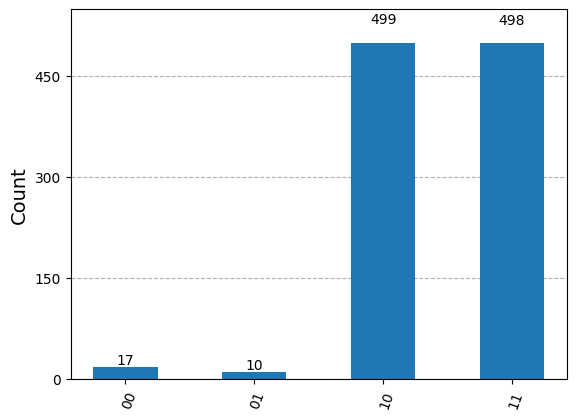

Measurement results (bitstrings):
{'11': 480, '10': 509, '01': 23, '00': 12}


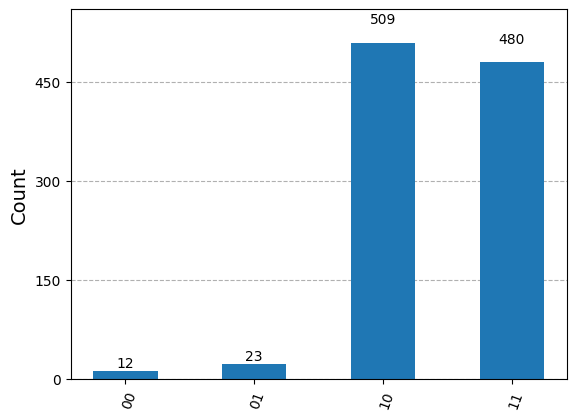

Measurement results (bitstrings):
{'10': 491, '11': 478, '00': 26, '01': 29}


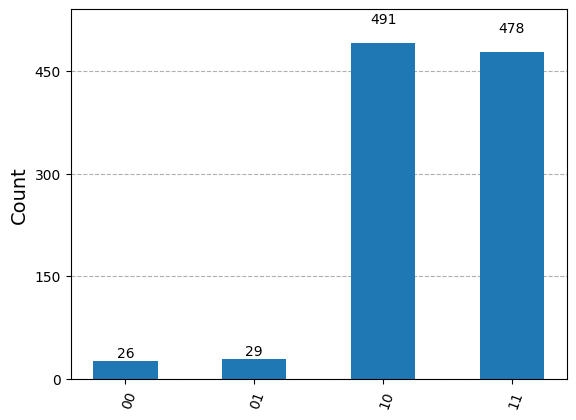

Measurement results (bitstrings):
{'11': 471, '10': 482, '01': 38, '00': 33}


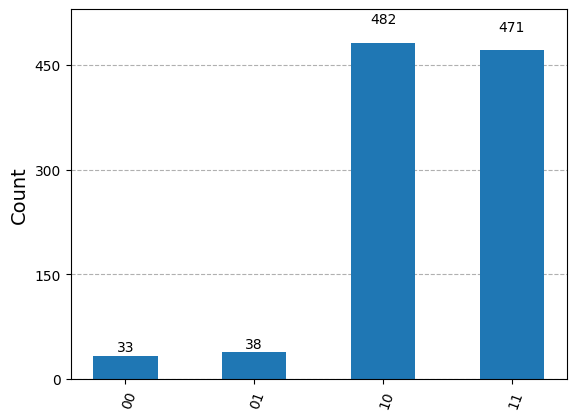

Measurement results (bitstrings):
{'11': 468, '10': 468, '01': 41, '00': 47}


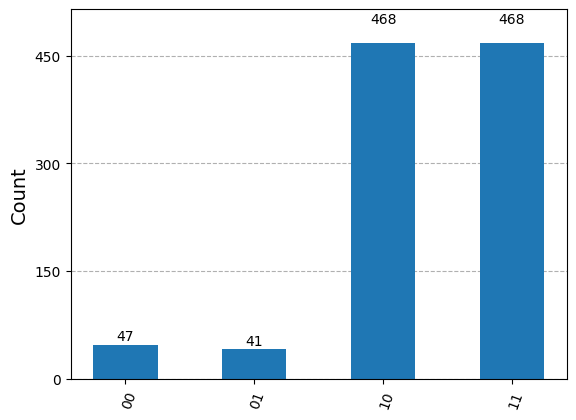

Measurement results (bitstrings):
{'11': 453, '10': 467, '00': 51, '01': 53}


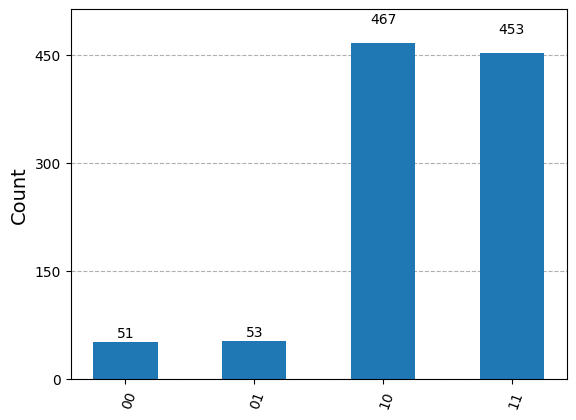

Measurement results (bitstrings):
{'10': 439, '11': 479, '00': 63, '01': 43}


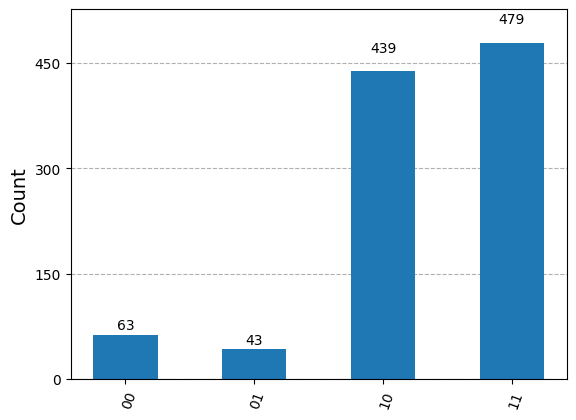

Measurement results (bitstrings):
{'11': 448, '00': 63, '10': 453, '01': 60}


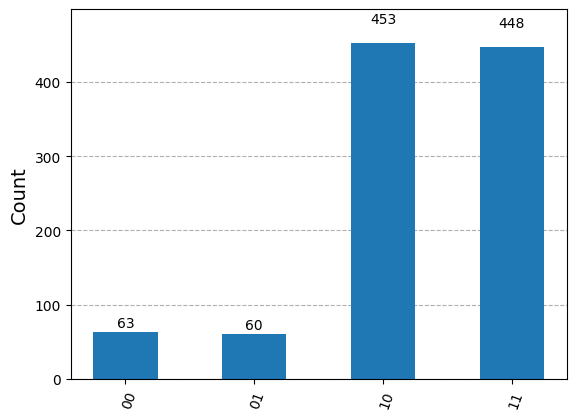

Measurement results (bitstrings):
{'10': 443, '00': 59, '11': 445, '01': 77}


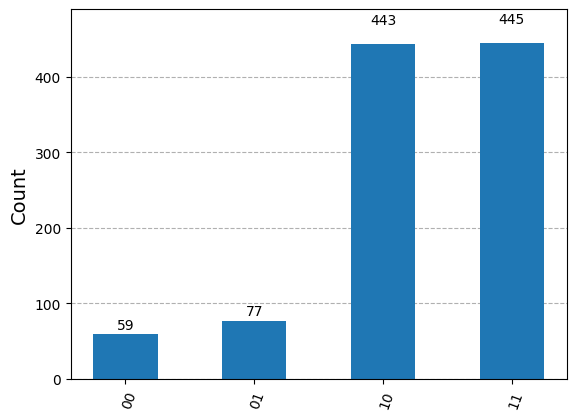

Measurement results (bitstrings):
{'00': 78, '11': 419, '10': 433, '01': 94}


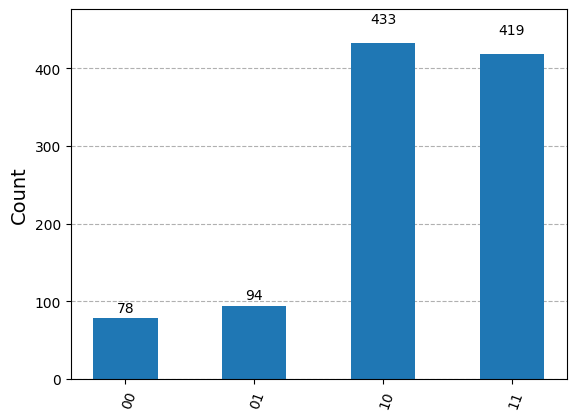

Measurement results (bitstrings):
{'11': 429, '10': 417, '01': 88, '00': 90}


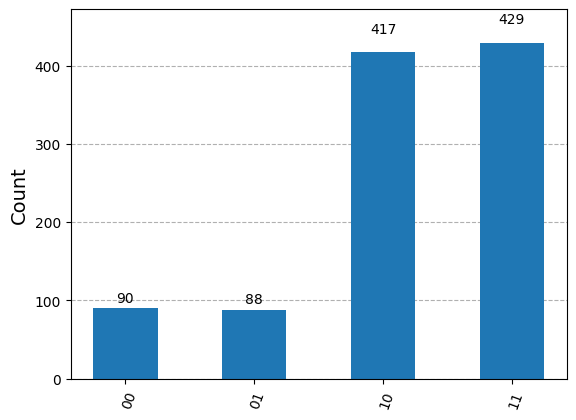

Measurement results (bitstrings):
{'10': 418, '00': 84, '11': 421, '01': 101}


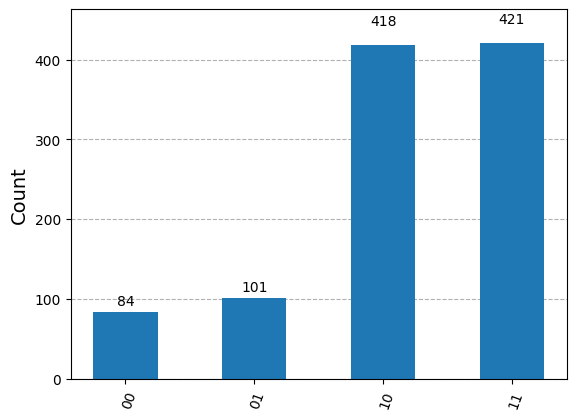

Measurement results (bitstrings):
{'10': 423, '01': 110, '11': 401, '00': 90}


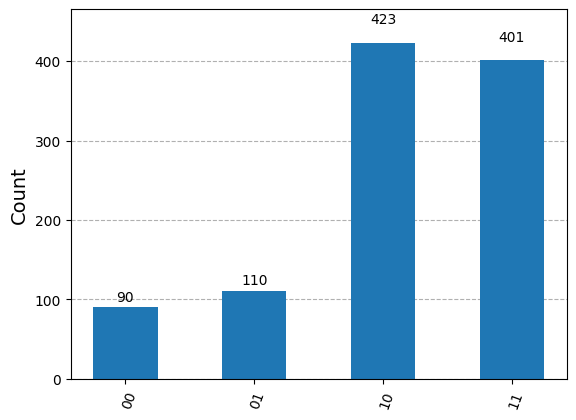

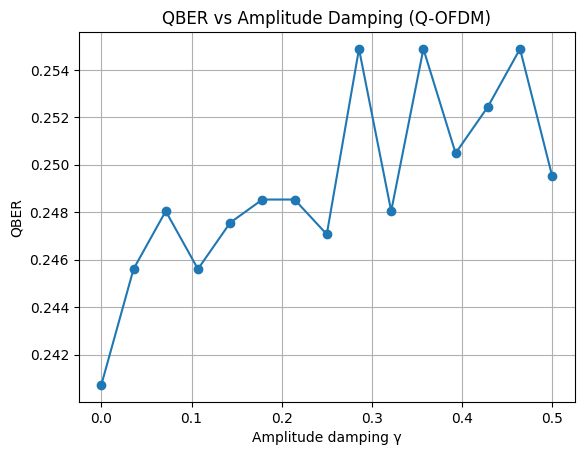

In [58]:
gamma_vals = np.linspace(0, 0.5, 15)
qber_vals = []

for g in gamma_vals:
    qber_vals.append(run_qofdm(theta_val=0.0, gamma_val=g))

plt.figure()
plt.plot(gamma_vals, qber_vals, marker='o')
plt.xlabel("Amplitude damping γ")
plt.ylabel("QBER")
plt.title("QBER vs Amplitude Damping (Q-OFDM)")
plt.grid(True)
plt.show()


Measurement results (bitstrings):
{'11': 525, '10': 499}


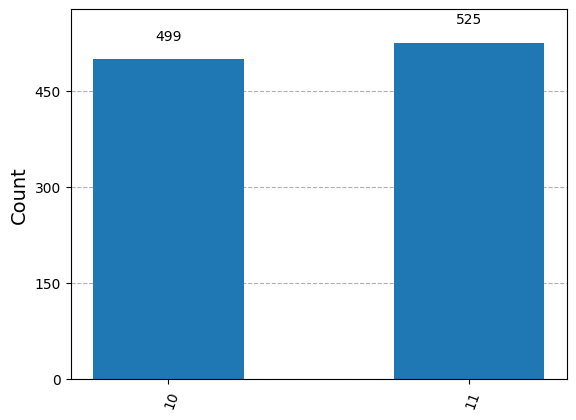

Measurement results (bitstrings):
{'11': 592, '10': 416, '00': 7, '01': 9}


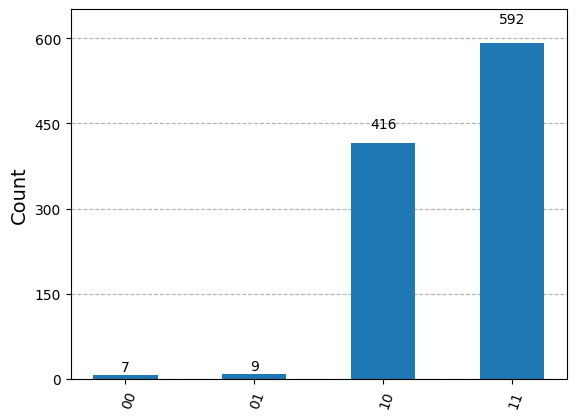

Measurement results (bitstrings):
{'11': 707, '10': 275, '00': 32, '01': 10}


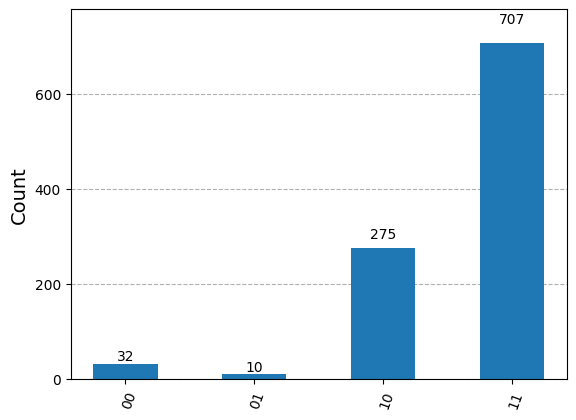

Measurement results (bitstrings):
{'11': 746, '10': 172, '00': 87, '01': 19}


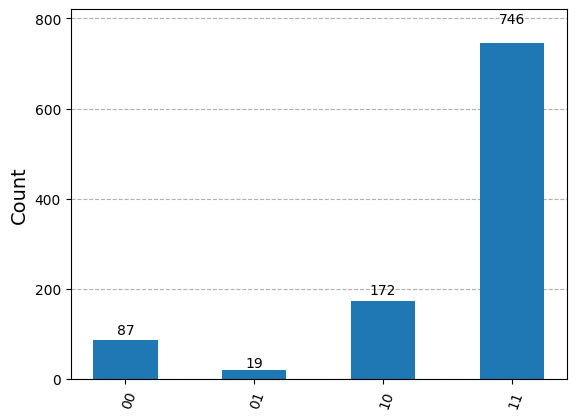

Measurement results (bitstrings):
{'11': 722, '00': 183, '10': 97, '01': 22}


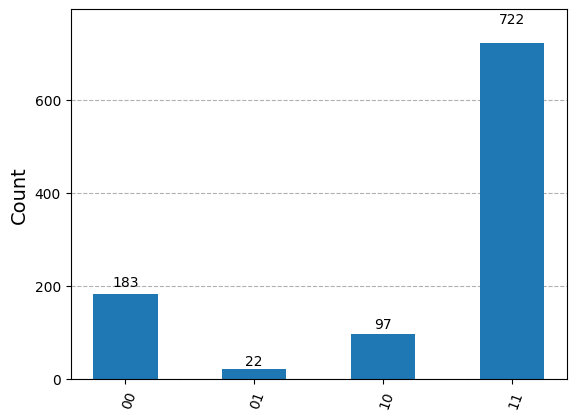

Measurement results (bitstrings):
{'00': 260, '11': 704, '10': 45, '01': 15}


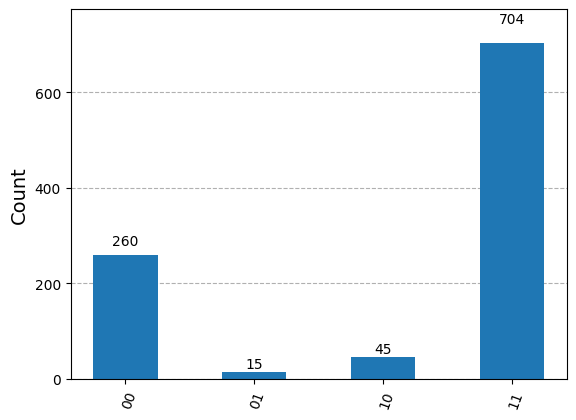

Measurement results (bitstrings):
{'00': 380, '11': 629, '10': 8, '01': 7}


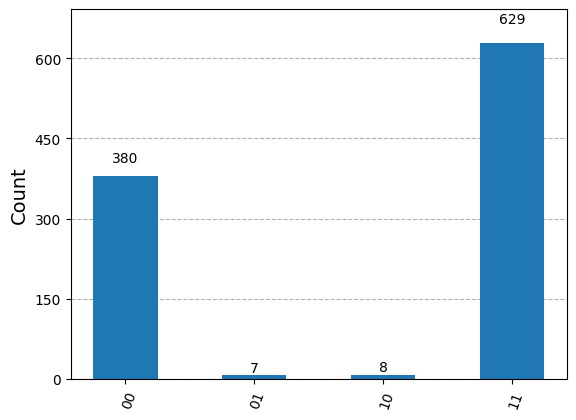

Measurement results (bitstrings):
{'11': 512, '00': 512}


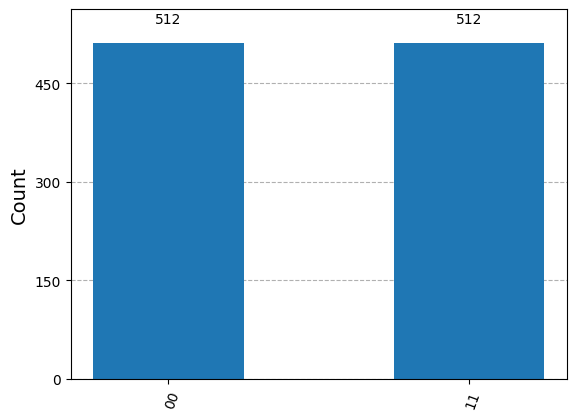

Measurement results (bitstrings):
{'00': 610, '11': 396, '01': 12, '10': 6}


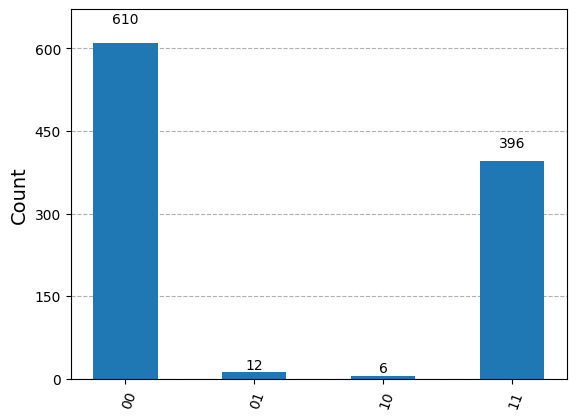

Measurement results (bitstrings):
{'01': 37, '00': 708, '11': 264, '10': 15}


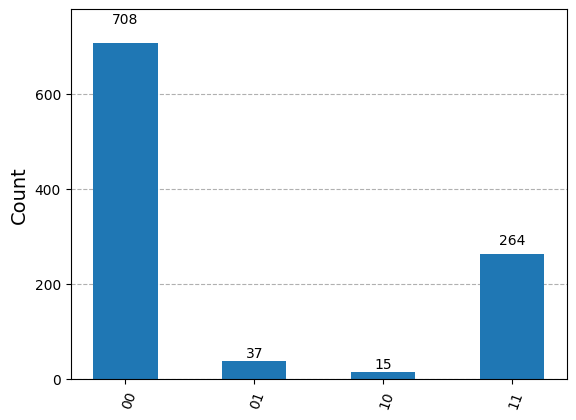

Measurement results (bitstrings):
{'01': 84, '00': 750, '11': 170, '10': 20}


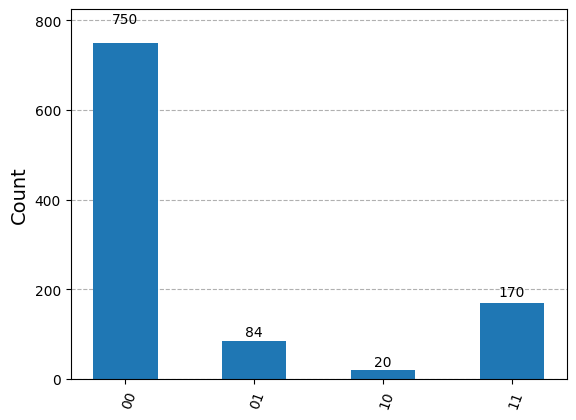

Measurement results (bitstrings):
{'00': 747, '01': 168, '11': 91, '10': 18}


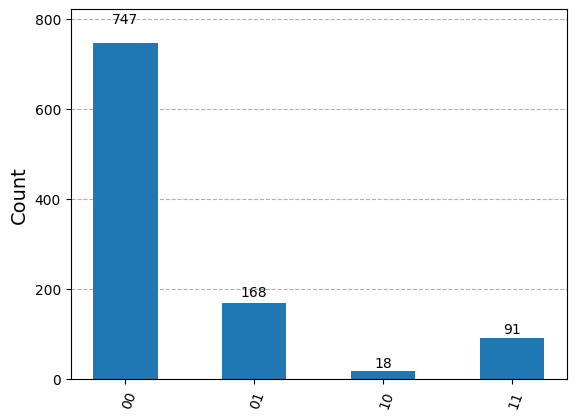

Measurement results (bitstrings):
{'00': 686, '01': 295, '10': 14, '11': 29}


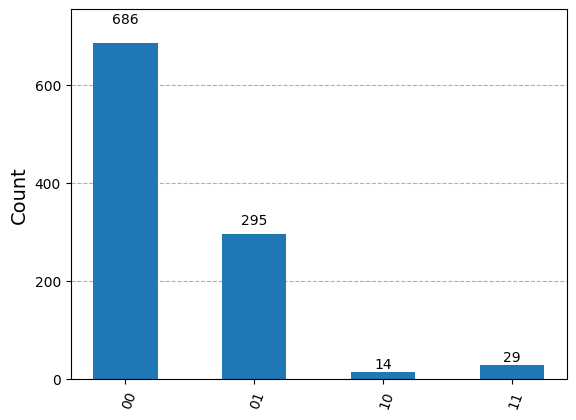

Measurement results (bitstrings):
{'00': 622, '01': 390, '10': 3, '11': 9}


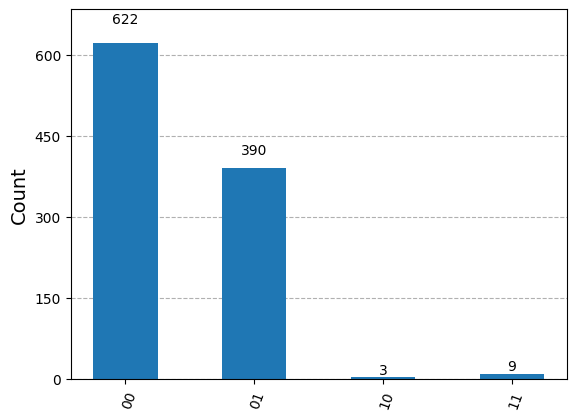

Measurement results (bitstrings):
{'01': 502, '00': 522}


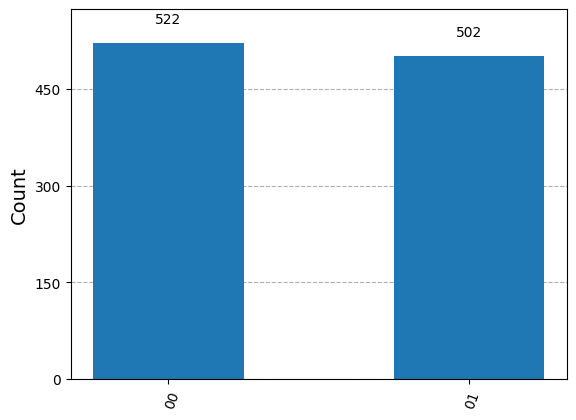

Measurement results (bitstrings):
{'11': 527, '10': 497}


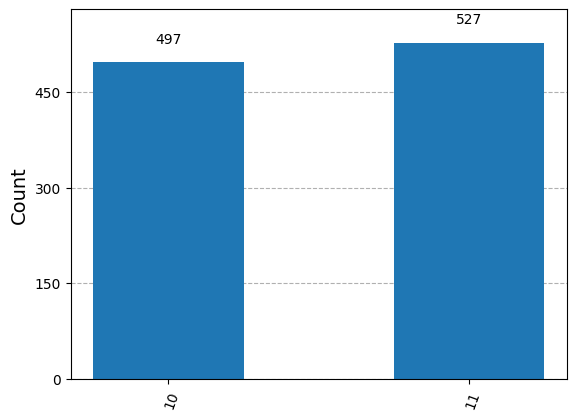

Measurement results (bitstrings):
{'11': 461, '10': 544, '01': 8, '00': 11}


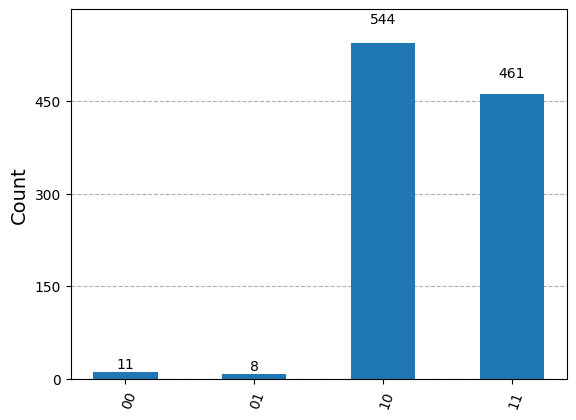

Measurement results (bitstrings):
{'11': 485, '10': 515, '01': 16, '00': 8}


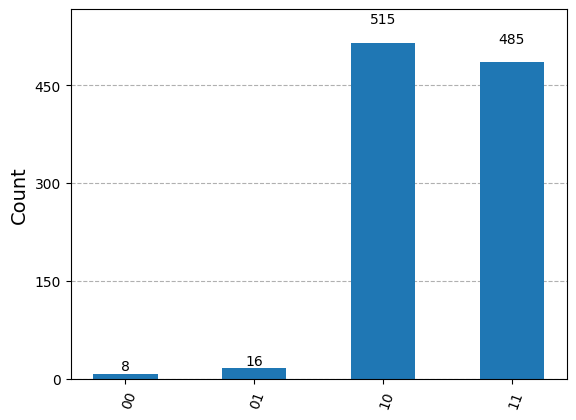

Measurement results (bitstrings):
{'11': 482, '10': 499, '01': 22, '00': 21}


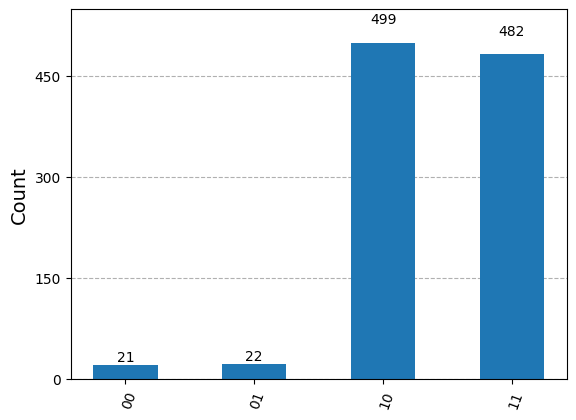

Measurement results (bitstrings):
{'11': 484, '01': 30, '10': 477, '00': 33}


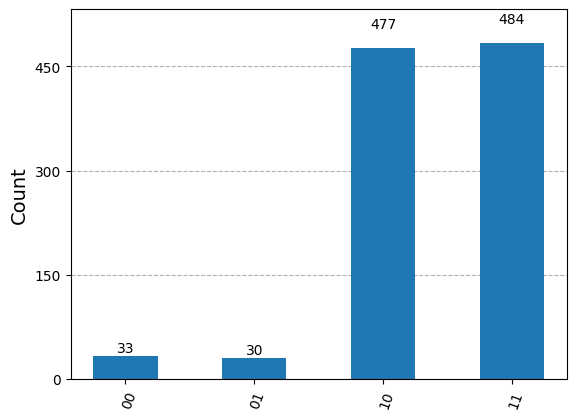

Measurement results (bitstrings):
{'10': 495, '11': 471, '01': 27, '00': 31}


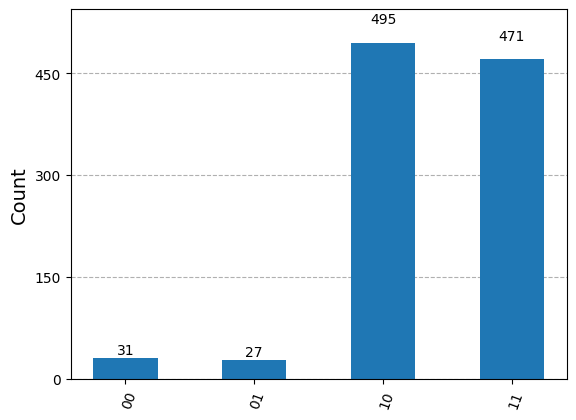

Measurement results (bitstrings):
{'10': 468, '11': 470, '00': 33, '01': 53}


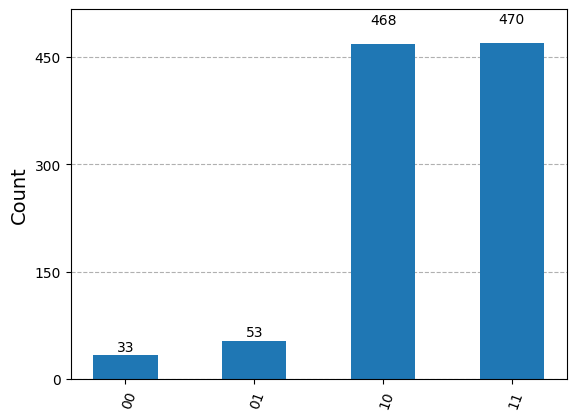

Measurement results (bitstrings):
{'11': 439, '10': 477, '01': 62, '00': 46}


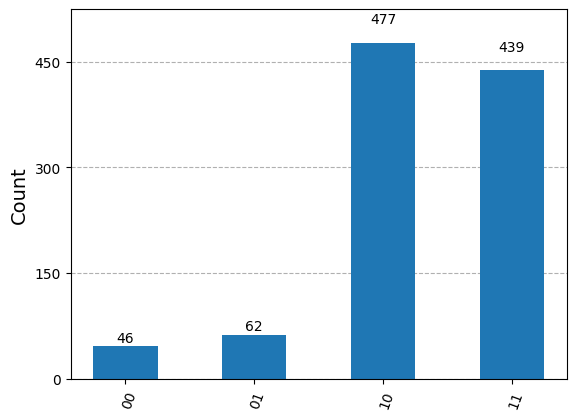

Measurement results (bitstrings):
{'11': 471, '10': 458, '01': 40, '00': 55}


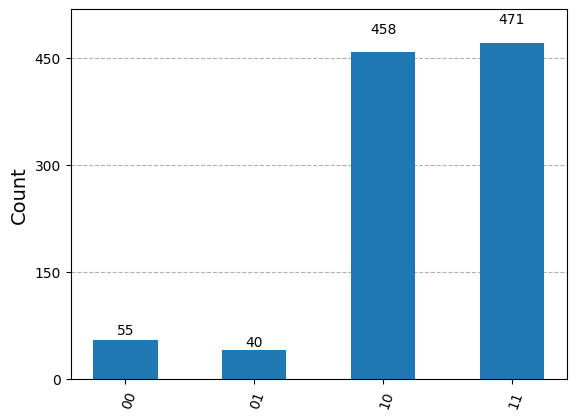

Measurement results (bitstrings):
{'11': 442, '10': 450, '00': 67, '01': 65}


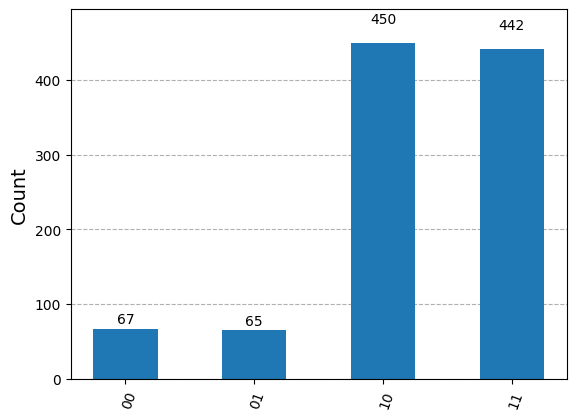

Measurement results (bitstrings):
{'11': 438, '10': 441, '00': 70, '01': 75}


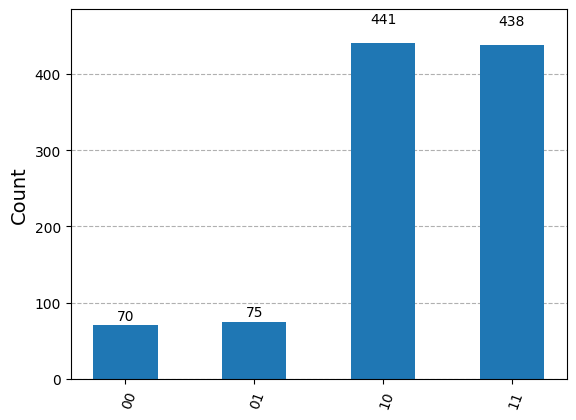

Measurement results (bitstrings):
{'11': 401, '01': 84, '10': 465, '00': 74}


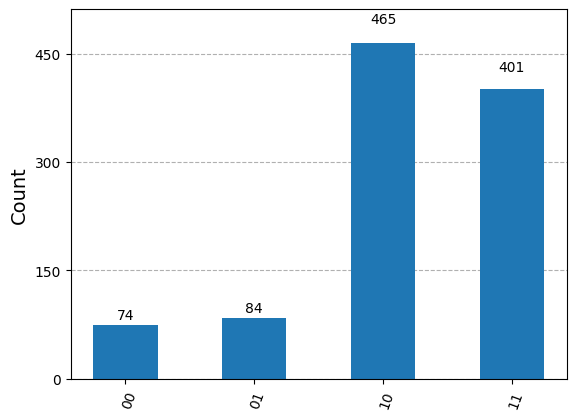

Measurement results (bitstrings):
{'10': 420, '11': 435, '00': 79, '01': 90}


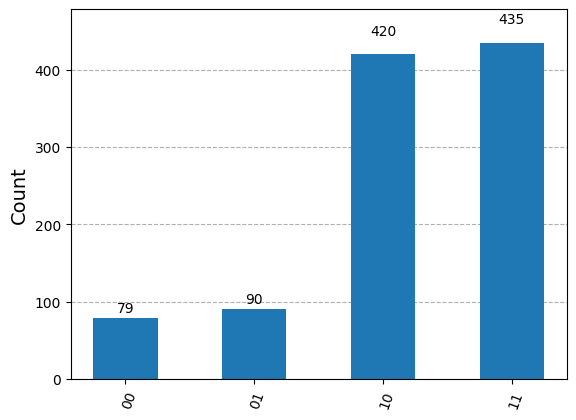

Measurement results (bitstrings):
{'11': 413, '01': 93, '10': 432, '00': 86}


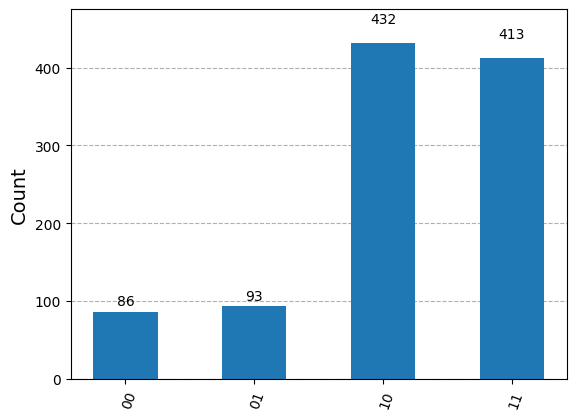

Measurement results (bitstrings):
{'11': 416, '10': 412, '01': 101, '00': 95}


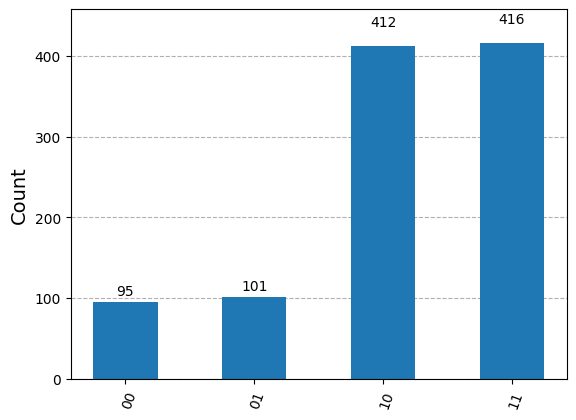

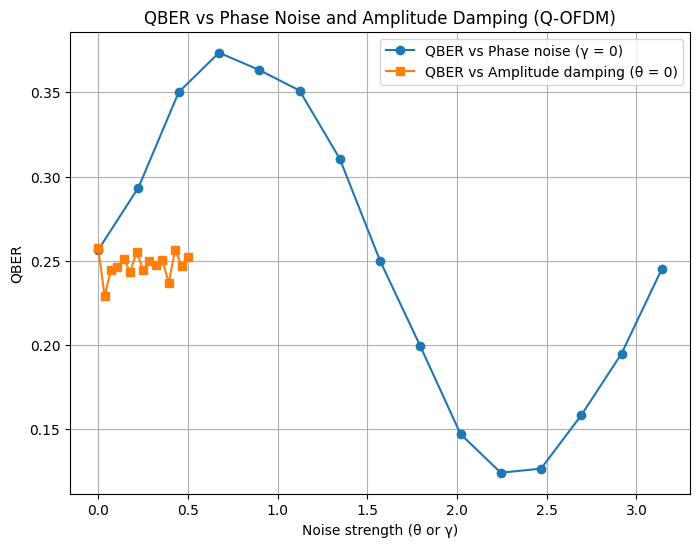

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# --- Phase noise sweep ---
theta_vals = np.linspace(0, np.pi, 15)
qber_theta = []

for t in theta_vals:
    qber_theta.append(run_qofdm(theta_val=t, gamma_val=0.0))

# --- Amplitude damping sweep ---
gamma_vals = np.linspace(0, 0.5, 15)
qber_gamma = []

for g in gamma_vals:
    qber_gamma.append(run_qofdm(theta_val=0.0, gamma_val=g))

# --- Single combined plot ---
plt.figure(figsize=(8, 6))

plt.plot(theta_vals, qber_theta, marker='o', label="QBER vs Phase noise (γ = 0)")
plt.plot(gamma_vals, qber_gamma, marker='s', label="QBER vs Amplitude damping (θ = 0)")

plt.xlabel("Noise strength (θ or γ)")
plt.ylabel("QBER")
plt.title("QBER vs Phase Noise and Amplitude Damping (Q-OFDM)")
plt.legend()
plt.grid(True)

plt.show()


Measurement results (bitstrings):
{'10': 529, '11': 495}


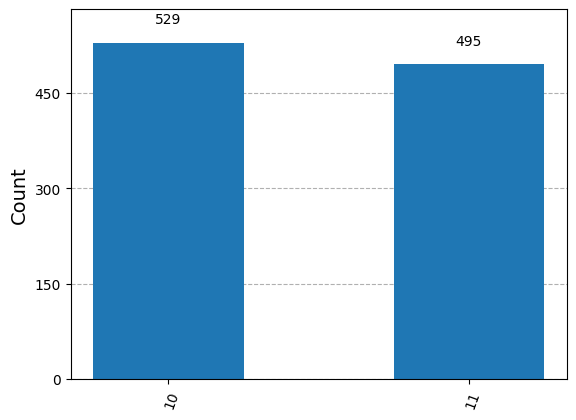

Measurement results (bitstrings):
{'11': 614, '10': 398, '00': 8, '01': 4}


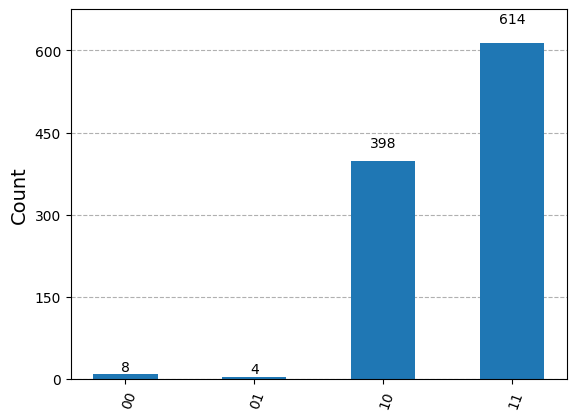

Measurement results (bitstrings):
{'10': 263, '11': 712, '01': 11, '00': 38}


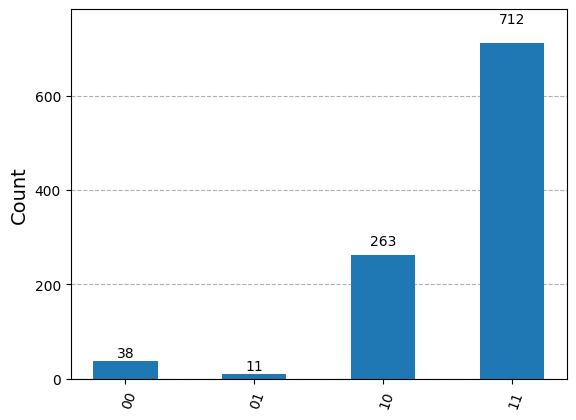

Measurement results (bitstrings):
{'11': 755, '10': 168, '00': 85, '01': 16}


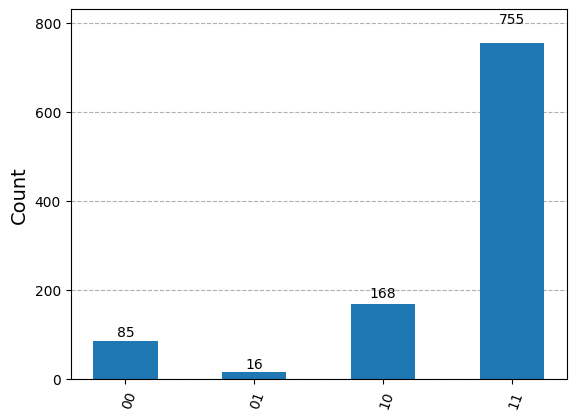

Measurement results (bitstrings):
{'11': 738, '10': 88, '01': 18, '00': 180}


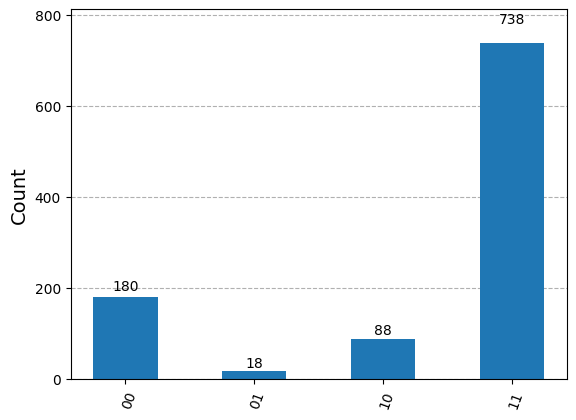

Measurement results (bitstrings):
{'11': 670, '10': 33, '00': 308, '01': 13}


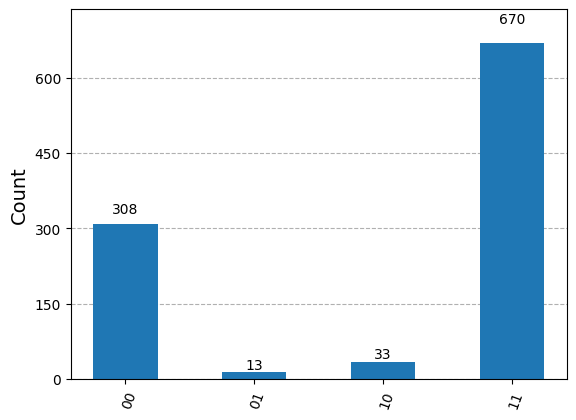

Measurement results (bitstrings):
{'00': 379, '11': 631, '10': 9, '01': 5}


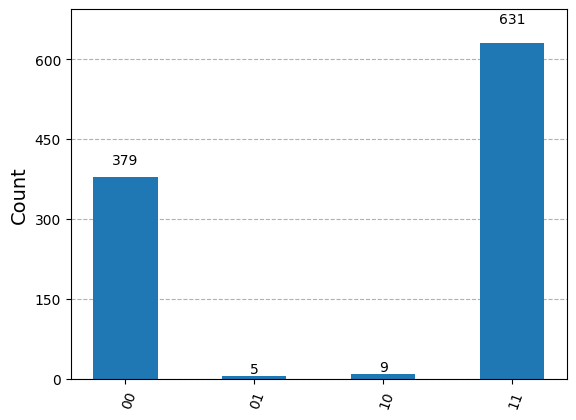

Measurement results (bitstrings):
{'00': 489, '11': 535}


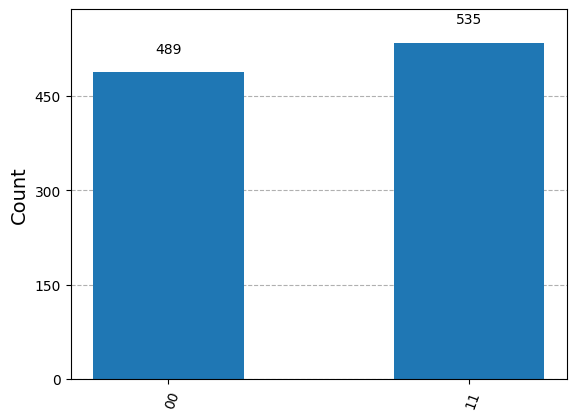

Measurement results (bitstrings):
{'11': 380, '00': 633, '01': 9, '10': 2}


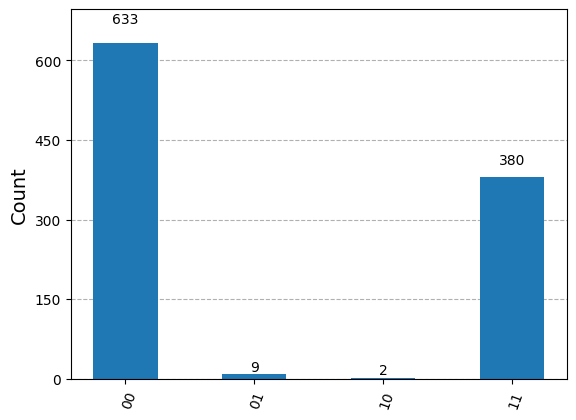

Measurement results (bitstrings):
{'00': 711, '11': 258, '10': 18, '01': 37}


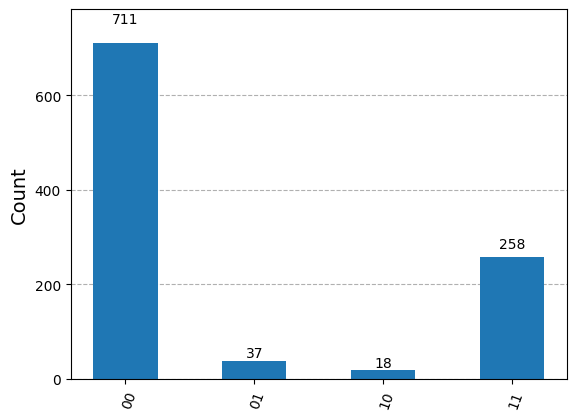

Measurement results (bitstrings):
{'00': 724, '01': 104, '11': 169, '10': 27}


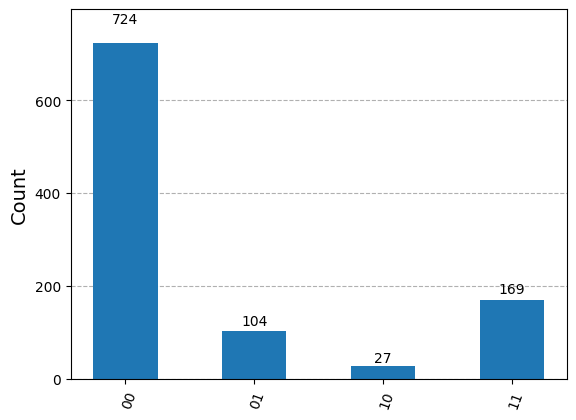

Measurement results (bitstrings):
{'01': 190, '00': 718, '11': 97, '10': 19}


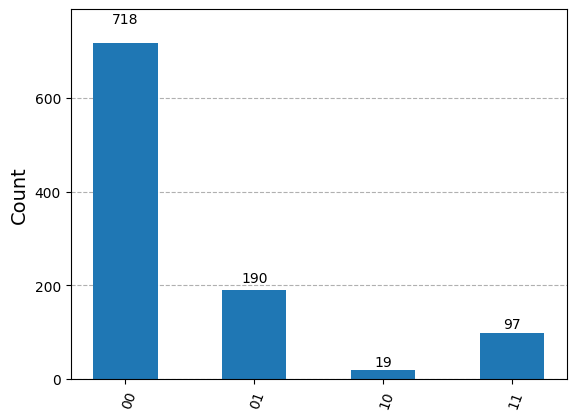

Measurement results (bitstrings):
{'00': 695, '11': 39, '01': 286, '10': 4}


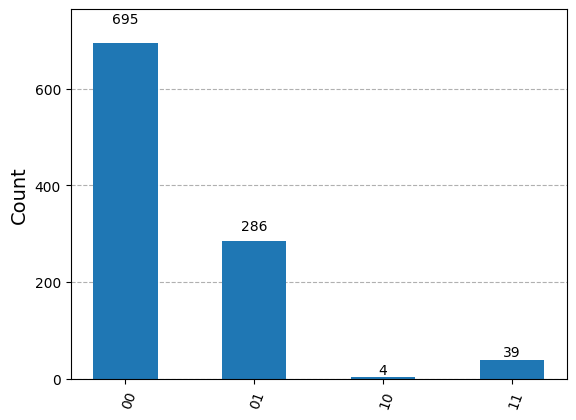

Measurement results (bitstrings):
{'01': 387, '00': 627, '11': 5, '10': 5}


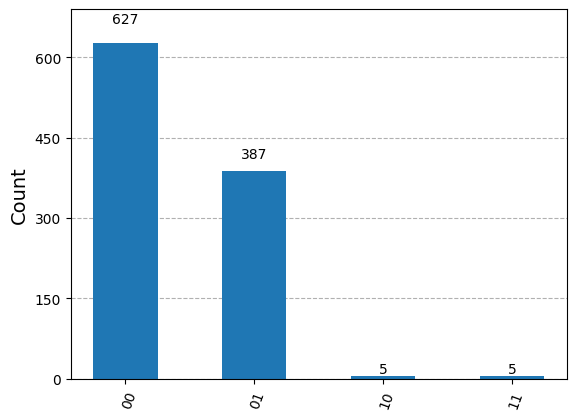

Measurement results (bitstrings):
{'00': 492, '01': 532}


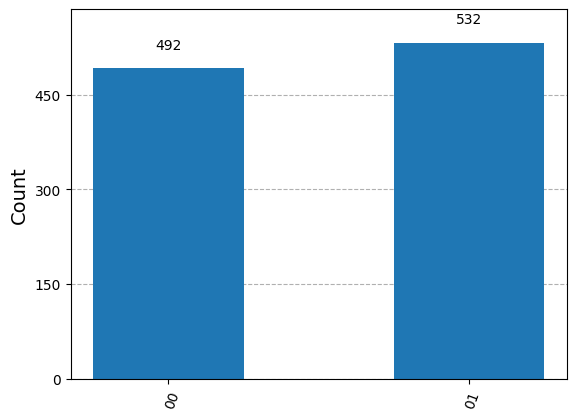

Measurement results (bitstrings):
{'11': 517, '10': 507}


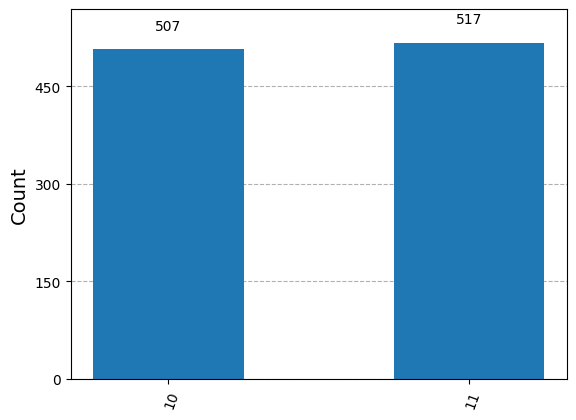

Measurement results (bitstrings):
{'10': 500, '11': 509, '00': 8, '01': 7}


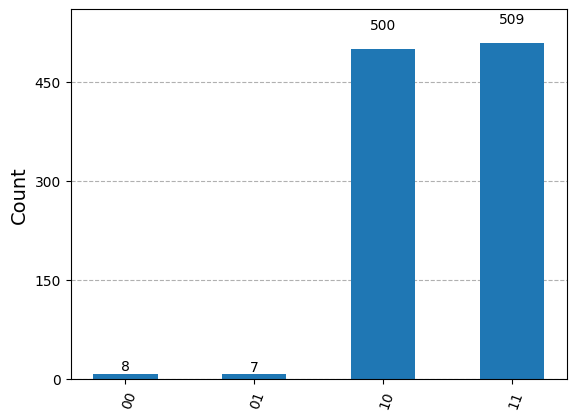

Measurement results (bitstrings):
{'11': 475, '10': 528, '00': 8, '01': 13}


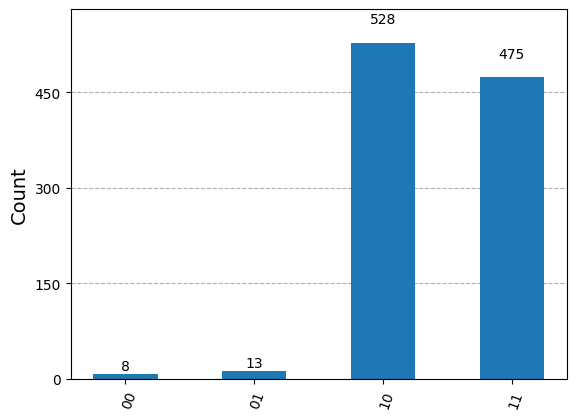

Measurement results (bitstrings):
{'10': 482, '11': 489, '01': 25, '00': 28}


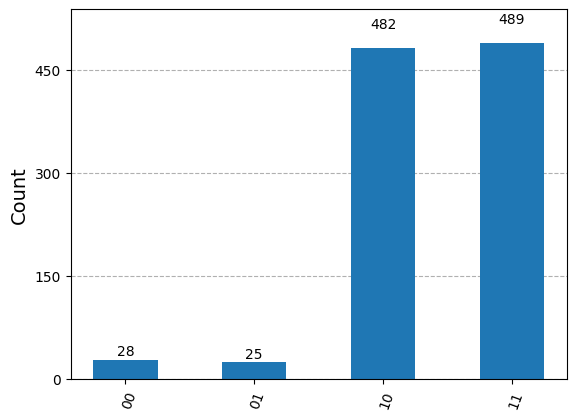

Measurement results (bitstrings):
{'11': 495, '10': 480, '01': 26, '00': 23}


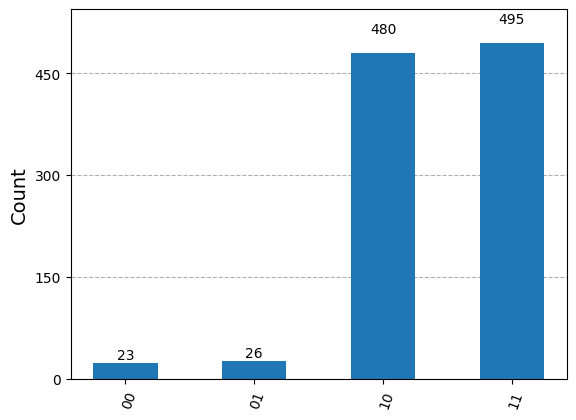

Measurement results (bitstrings):
{'00': 23, '11': 503, '10': 467, '01': 31}


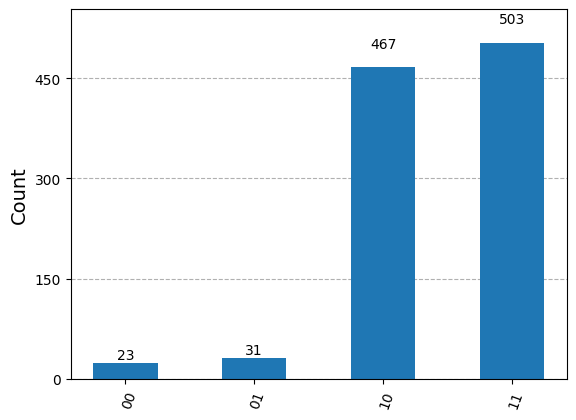

Measurement results (bitstrings):
{'11': 504, '10': 434, '00': 36, '01': 50}


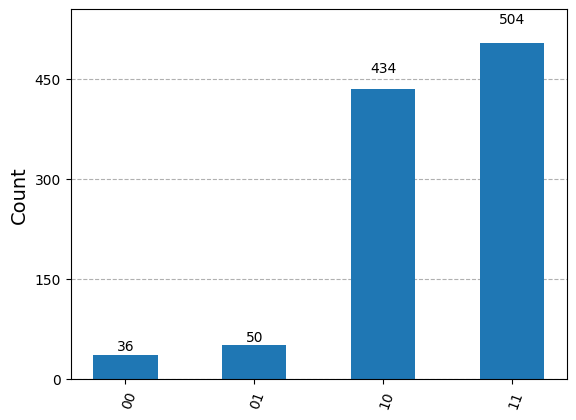

Measurement results (bitstrings):
{'10': 459, '00': 47, '11': 470, '01': 48}


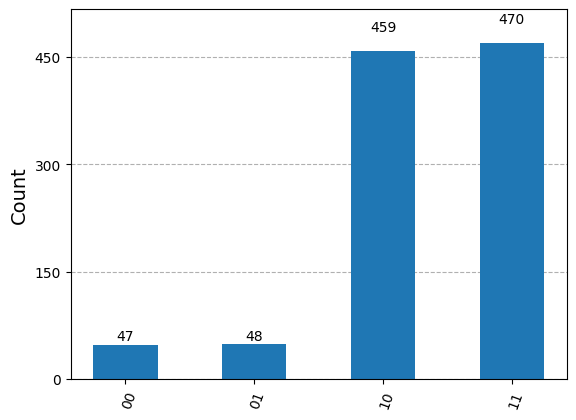

Measurement results (bitstrings):
{'10': 415, '11': 491, '01': 59, '00': 59}


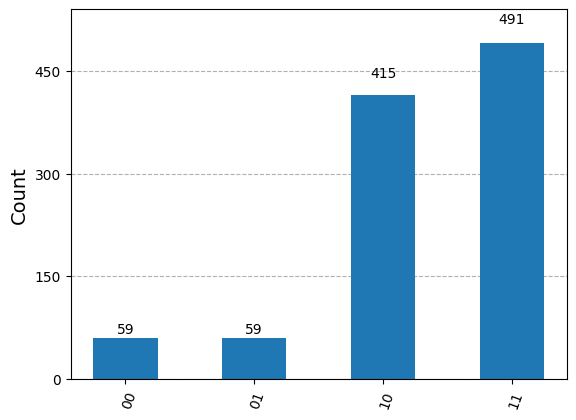

Measurement results (bitstrings):
{'10': 467, '11': 423, '01': 66, '00': 68}


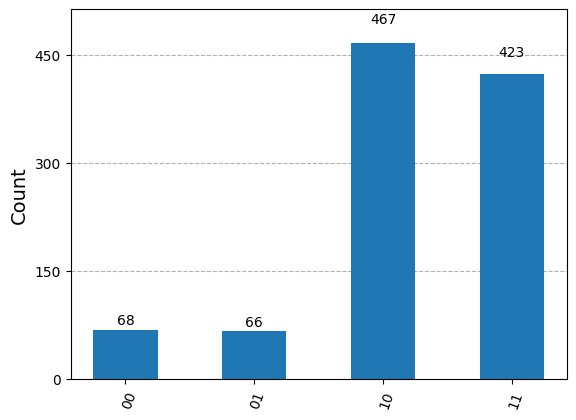

Measurement results (bitstrings):
{'11': 449, '01': 80, '10': 437, '00': 58}


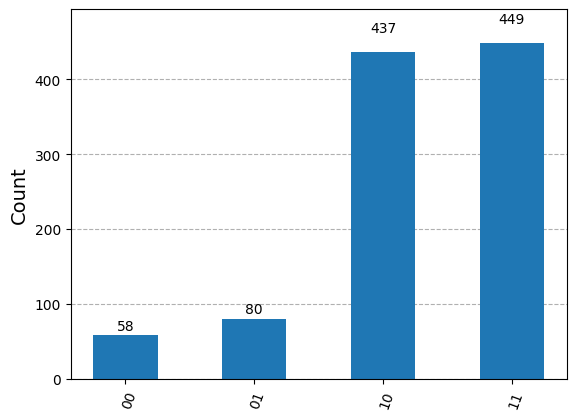

Measurement results (bitstrings):
{'10': 416, '11': 442, '01': 72, '00': 94}


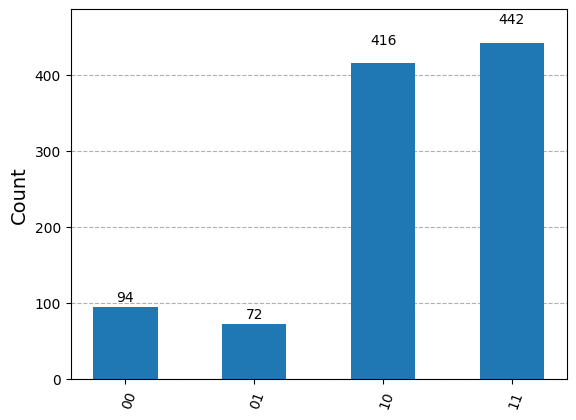

Measurement results (bitstrings):
{'00': 76, '11': 410, '10': 439, '01': 99}


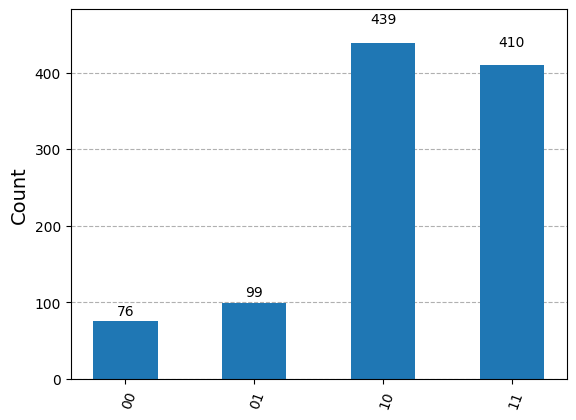

Measurement results (bitstrings):
{'10': 374, '11': 430, '00': 124, '01': 96}


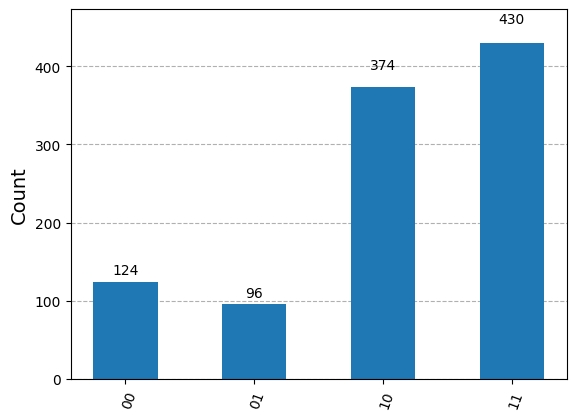

Measurement results (bitstrings):
{'00': 95, '10': 398, '11': 427, '01': 104}


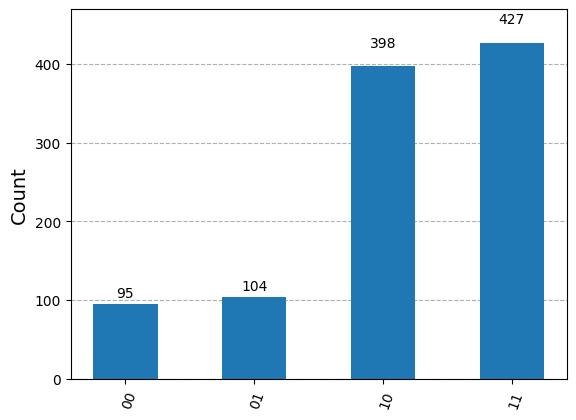

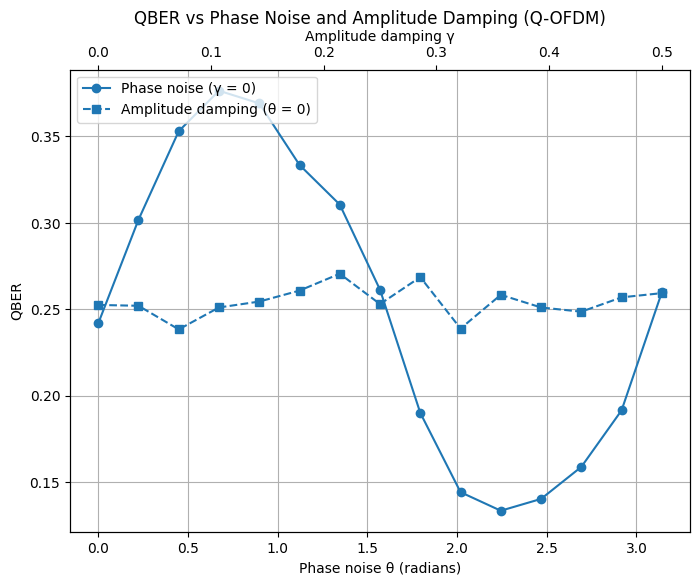

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# --- Phase noise sweep ---
theta_vals = np.linspace(0, np.pi, 15)
qber_theta = []

for t in theta_vals:
    qber_theta.append(run_qofdm(theta_val=t, gamma_val=0.0))

# --- Amplitude damping sweep ---
gamma_vals = np.linspace(0, 0.5, 15)
qber_gamma = []

for g in gamma_vals:
    qber_gamma.append(run_qofdm(theta_val=0.0, gamma_val=g))

# --- Create figure ---
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Bottom x-axis: phase noise ---
ax1.plot(theta_vals, qber_theta, 'o-', label="Phase noise (γ = 0)")
ax1.set_xlabel("Phase noise θ (radians)")
ax1.set_ylabel("QBER")
ax1.grid(True)

# --- Top x-axis: amplitude damping ---
ax2 = ax1.twiny()
ax2.plot(gamma_vals, qber_gamma, 's--', label="Amplitude damping (θ = 0)")
ax2.set_xlabel("Amplitude damping γ")

# --- Title ---
fig.suptitle("QBER vs Phase Noise and Amplitude Damping (Q-OFDM)")

# --- Combined legend ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()


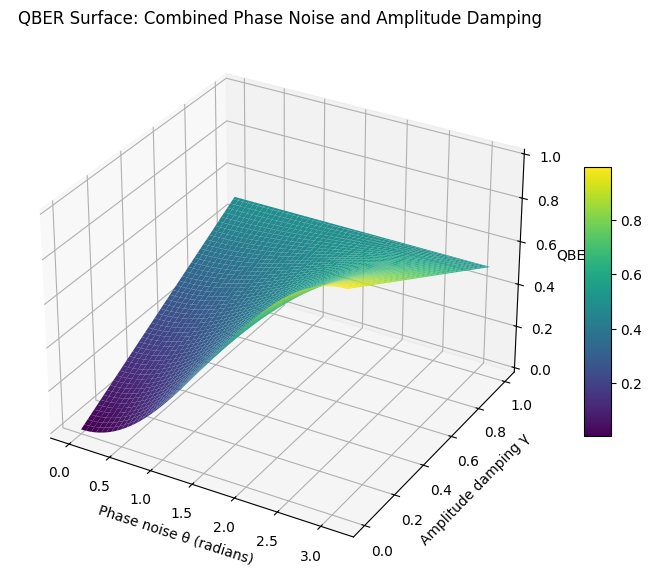

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameter ranges
theta = np.linspace(0, np.pi, 100)   # phase noise
gamma = np.linspace(0, 1, 100)        # amplitude damping

# Create 2D grid
Theta, Gamma = np.meshgrid(theta, gamma)

# QBER formula
QBER = (1 - Gamma) * np.sin(Theta / 2)**2 + Gamma / 2

# Plot surface
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    Theta, Gamma, QBER,
    cmap='viridis',
    edgecolor='none'
)

ax.set_xlabel("Phase noise θ (radians)")
ax.set_ylabel("Amplitude damping γ")
ax.set_zlabel("QBER")

ax.set_title("QBER Surface: Combined Phase Noise and Amplitude Damping")

fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


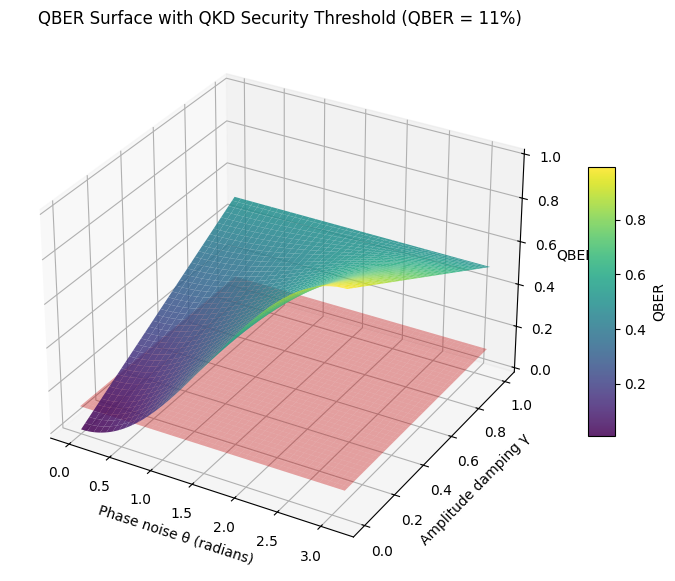

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameter ranges
theta = np.linspace(0, np.pi, 120)
gamma = np.linspace(0, 1, 120)

Theta, Gamma = np.meshgrid(theta, gamma)

# QBER formula
QBER = (1 - Gamma) * np.sin(Theta / 2)**2 + Gamma / 2

# Security threshold
QBER_th = 0.11
QBER_plane = QBER_th * np.ones_like(QBER)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# QBER surface
surf = ax.plot_surface(
    Theta, Gamma, QBER,
    cmap='viridis',
    alpha=0.85,
    edgecolor='none'
)

# Threshold plane
ax.plot_surface(
    Theta, Gamma, QBER_plane,
    color='red',
    alpha=0.35
)

ax.set_xlabel("Phase noise θ (radians)")
ax.set_ylabel("Amplitude damping γ")
ax.set_zlabel("QBER")

ax.set_title("QBER Surface with QKD Security Threshold (QBER = 11%)")

fig.colorbar(surf, shrink=0.5, aspect=10, label="QBER")

plt.show()


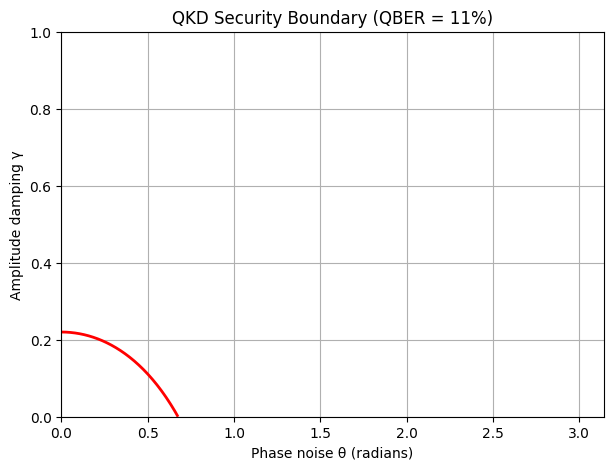

In [73]:
plt.figure(figsize=(7,5))
plt.contour(
    Theta, Gamma, QBER,
    levels=[0.11],
    colors='red',
    linewidths=2
)
plt.xlabel("Phase noise θ (radians)")
plt.ylabel("Amplitude damping γ")
plt.title("QKD Security Boundary (QBER = 11%)")
plt.grid(True)
plt.show()


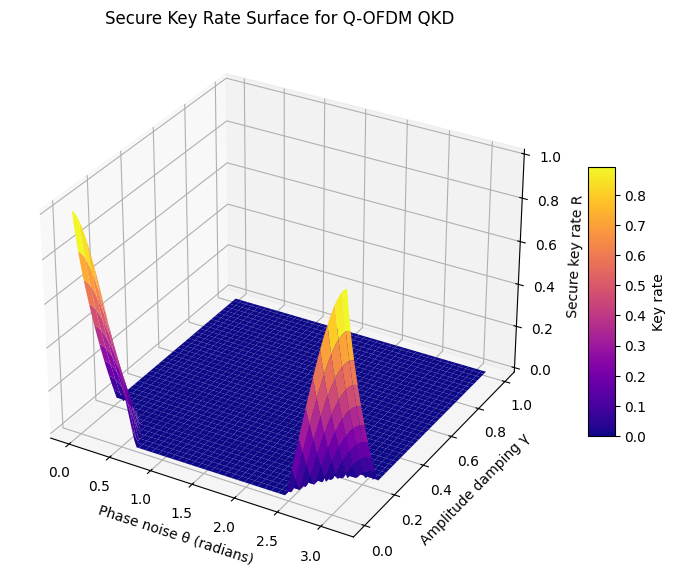

In [74]:
#Secure Key Rate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Binary entropy
def h2(x):
    x = np.clip(x, 1e-12, 1-1e-12)
    return -x*np.log2(x) - (1-x)*np.log2(1-x)

# Parameters
theta = np.linspace(0, np.pi, 120)
gamma = np.linspace(0, 1, 120)
Theta, Gamma = np.meshgrid(theta, gamma)

# QBER
QBER = (1 - Gamma)*np.sin(Theta/2)**2 + Gamma/2

# Secure key rate
R = np.maximum(0, 1 - 2*h2(QBER))

# Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    Theta, Gamma, R,
    cmap='plasma',
    edgecolor='none'
)

ax.set_xlabel("Phase noise θ (radians)")
ax.set_ylabel("Amplitude damping γ")
ax.set_zlabel("Secure key rate R")

ax.set_title("Secure Key Rate Surface for Q-OFDM QKD")

fig.colorbar(surf, shrink=0.5, aspect=10, label="Key rate")

plt.show()


In [75]:
import numpy as np

def qber_N(theta_list, gamma):
    theta = np.array(theta_list)
    theta_bar = np.mean(theta)
    sigma2 = np.mean((theta - theta_bar)**2)
    return (1 - gamma)*sigma2 + gamma/2

def secure_key_rate_N(theta_list, gamma):
    q = qber_N(theta_list, gamma)
    if q <= 0 or q >= 0.5:
        return 0
    h = -q*np.log2(q) - (1-q)*np.log2(1-q)
    return max(0, 1 - 2*h)


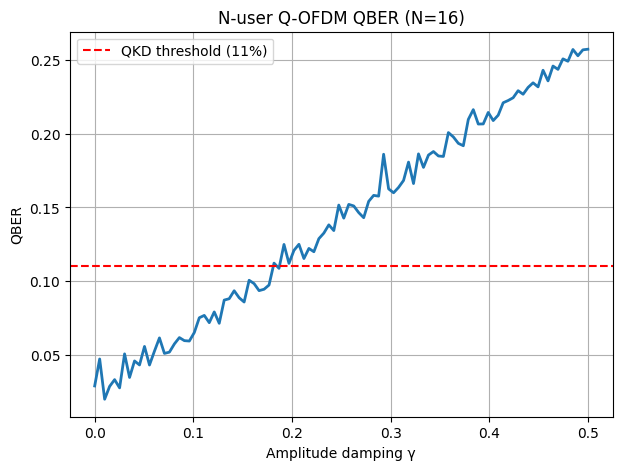

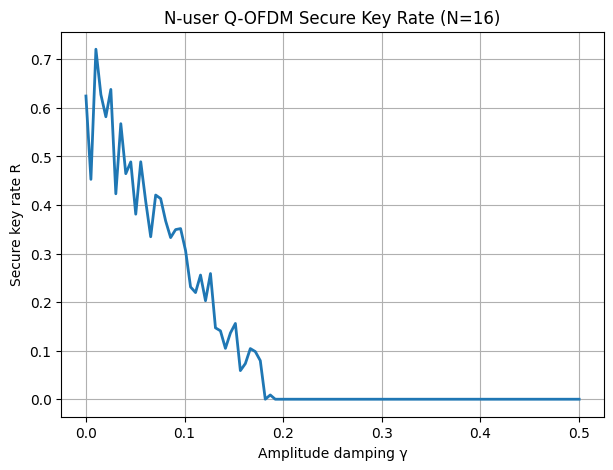

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. Binary entropy function
# ============================================================
def binary_entropy(x):
    x = np.clip(x, 1e-12, 1 - 1e-12)
    return -x*np.log2(x) - (1-x)*np.log2(1-x)


# ============================================================
# 2. N-user QBER formula
#    QBER_N = (1 - gamma)*sigma_theta^2 + gamma/2
# ============================================================
def qber_N(theta_list, gamma):
    theta = np.array(theta_list)
    theta_bar = np.mean(theta)
    sigma_theta_sq = np.mean((theta - theta_bar)**2)
    return (1 - gamma)*sigma_theta_sq + gamma/2


# ============================================================
# 3. Secure key rate for N-user Q-OFDM (BB84)
# ============================================================
def secure_key_rate_N(theta_list, gamma):
    q = qber_N(theta_list, gamma)
    if q >= 0.5:
        return 0.0
    return max(0.0, 1 - 2*binary_entropy(q))


# ============================================================
# 4. Generate phase noise for N users
# ============================================================
def generate_phase_noise(N, sigma):
    """
    Gaussian phase noise with std deviation sigma
    """
    return np.random.normal(0, sigma, N)


# ============================================================
# 5. Sweep gamma and compute QBER & key rate
# ============================================================
def sweep_gamma(N, sigma_theta, gamma_vals):
    qber_vals = []
    key_vals = []

    for gamma in gamma_vals:
        theta_list = generate_phase_noise(N, sigma_theta)
        qber = qber_N(theta_list, gamma)
        key = secure_key_rate_N(theta_list, gamma)

        qber_vals.append(qber)
        key_vals.append(key)

    return np.array(qber_vals), np.array(key_vals)


# ============================================================
# 6. Example parameters
# ============================================================
N = 16                    # number of users
sigma_theta = 0.15        # phase noise strength
gamma_vals = np.linspace(0, 0.5, 100)

qber_vals, key_vals = sweep_gamma(N, sigma_theta, gamma_vals)


# ============================================================
# 7. Plot QBER vs gamma
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(gamma_vals, qber_vals, linewidth=2)
plt.axhline(0.11, color='r', linestyle='--', label="QKD threshold (11%)")
plt.xlabel("Amplitude damping γ")
plt.ylabel("QBER")
plt.title(f"N-user Q-OFDM QBER (N={N})")
plt.grid(True)
plt.legend()
plt.show()


# ============================================================
# 8. Plot secure key rate vs gamma
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(gamma_vals, key_vals, linewidth=2)
plt.xlabel("Amplitude damping γ")
plt.ylabel("Secure key rate R")
plt.title(f"N-user Q-OFDM Secure Key Rate (N={N})")
plt.grid(True)
plt.show()


In [59]:
# For N user


In [60]:
def run_qofdm_n(
    n,
    theta_vals=None,
    gamma=0.0,
    shots=4096
):
    """
    n          : number of qubits (subcarriers = 2^n)
    theta_vals : list of phase errors θ_k (length 2^n)
    gamma      : amplitude damping strength
    """

    N = 2**n
    #backend = Aer.get_backend('qasm_simulator')

    qc = QuantumCircuit(n, n)

    # -----------------------------
    # Step 1: Encoding
    # Uniform multi-user superposition
    # -----------------------------
    for q in range(n):
        qc.h(q)

    # -----------------------------
    # Step 2: QFT (multiplexing)
    # -----------------------------
    qc.append(QFT(n, do_swaps=True), range(n))

    # -----------------------------
    # Step 3.1: Phase distortion
    # -----------------------------
    if theta_vals is None:
        theta_vals = np.zeros(N)

    phase_gate = Diagonal(
        [np.exp(1j * t) for t in theta_vals]
    )
    qc.append(phase_gate, range(n))

    # -----------------------------
    # Step 3.2: Amplitude damping
    # -----------------------------
    if gamma > 0:
        K0 = np.array([[1, 0], [0, np.sqrt(1 - gamma)]])
        K1 = np.array([[0, np.sqrt(gamma)], [0, 0]])
        amp_damp = Kraus([K0, K1])

        for q in range(n):
            qc.append(amp_damp, [q])

    # -----------------------------
    # Step 4: IQFT
    # -----------------------------
    qc.append(QFT(n, inverse=True, do_swaps=True), range(n))

    # -----------------------------
    # Step 5: Measurement
    # -----------------------------
    qc.measure(range(n), range(n))

    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled, shots=1024).result()
    counts = result.get_counts()

    print("Measurement results (bitstrings):")
    print(counts)
    plot_histogram(counts)
    plt.show()

    # -----------------------------
    # QBER estimation
    # Ideal outcome = all-zero string
    # -----------------------------
    ideal = '0' * n
    errors = sum(v for k, v in counts.items() if k != ideal)

    return errors / shots


Measurement results (bitstrings):
{'00': 270, '11': 242, '10': 264, '01': 248}


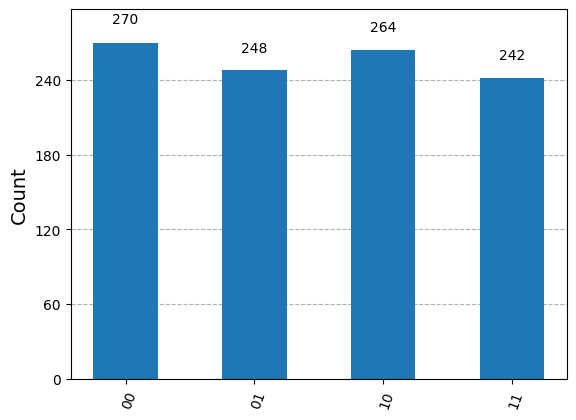

Measurement results (bitstrings):
{'10': 240, '00': 259, '11': 290, '01': 235}


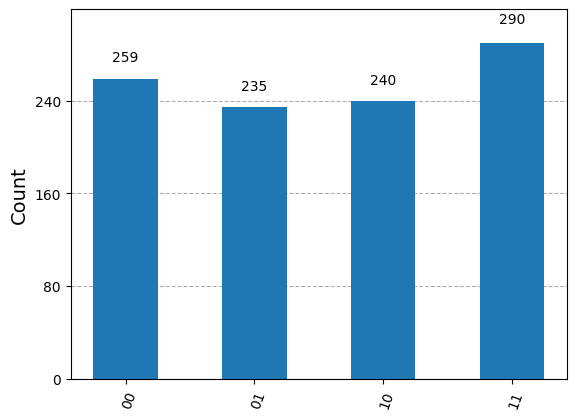

Measurement results (bitstrings):
{'10': 239, '01': 261, '11': 254, '00': 270}


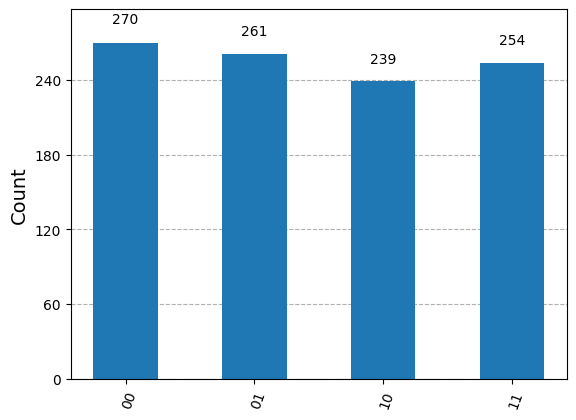

Measurement results (bitstrings):
{'11': 245, '10': 271, '01': 252, '00': 256}


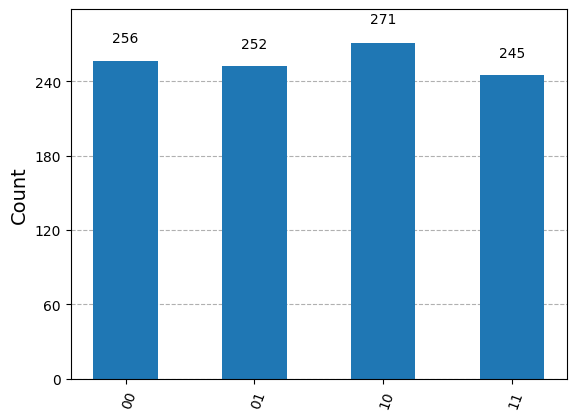

Measurement results (bitstrings):
{'01': 256, '11': 262, '00': 262, '10': 244}


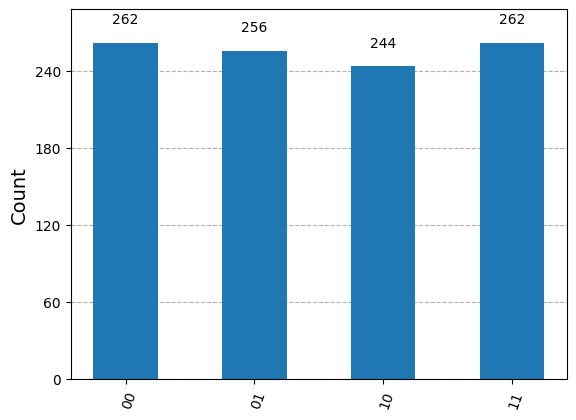

Measurement results (bitstrings):
{'11': 241, '01': 266, '10': 263, '00': 254}


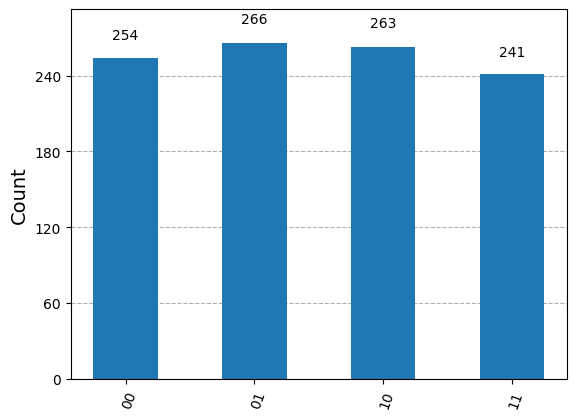

Measurement results (bitstrings):
{'00': 273, '11': 242, '10': 273, '01': 236}


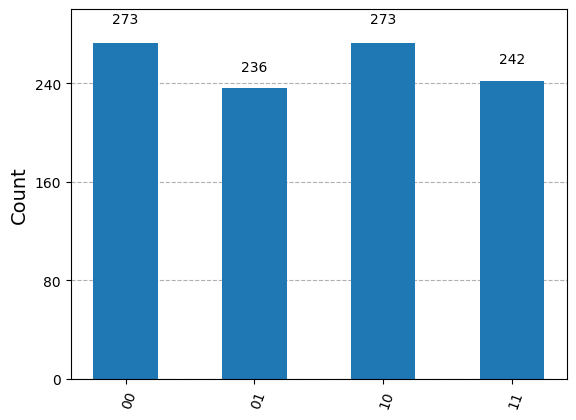

Measurement results (bitstrings):
{'10': 233, '11': 264, '01': 257, '00': 270}


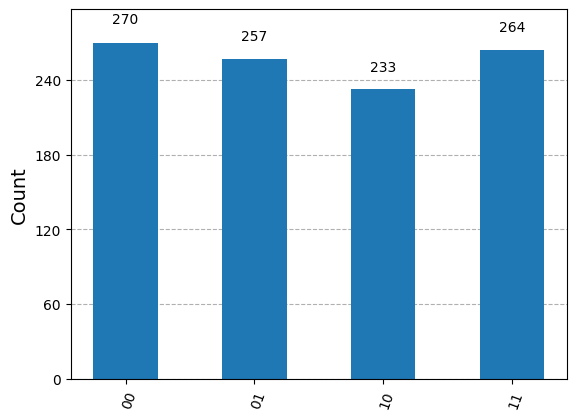

Measurement results (bitstrings):
{'00': 281, '11': 248, '10': 250, '01': 245}


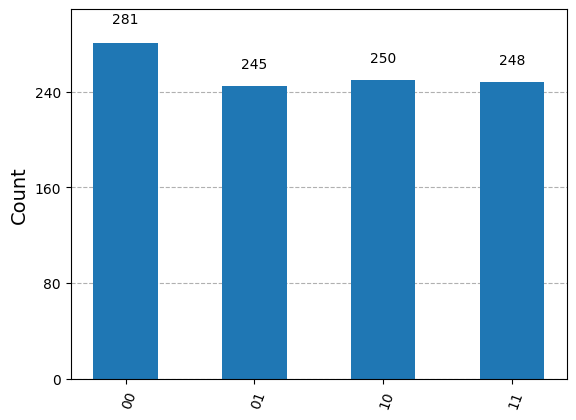

Measurement results (bitstrings):
{'11': 260, '01': 261, '00': 245, '10': 258}


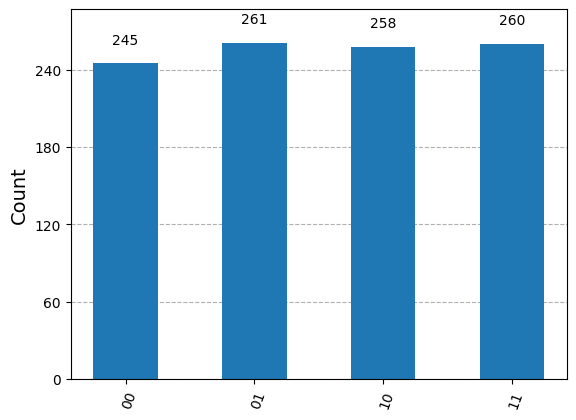

Measurement results (bitstrings):
{'10': 249, '01': 263, '00': 263, '11': 249}


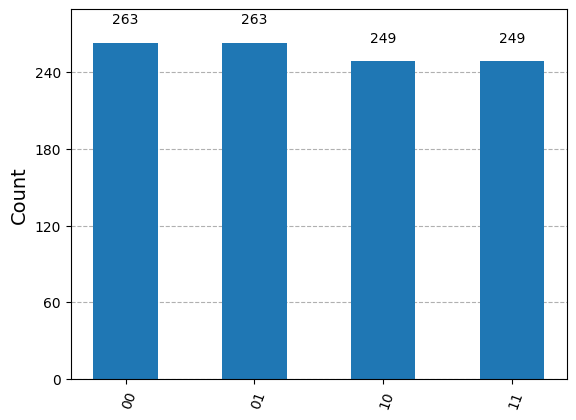

Measurement results (bitstrings):
{'01': 260, '00': 298, '11': 249, '10': 217}


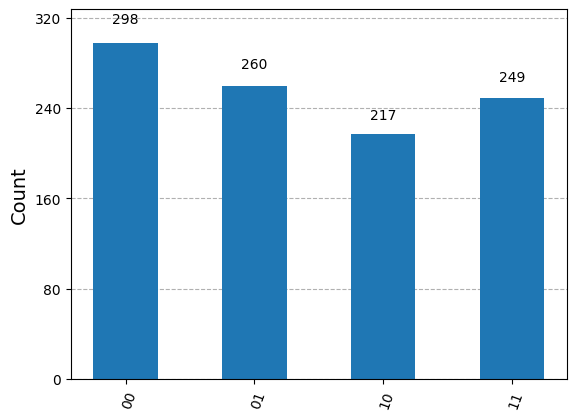

Measurement results (bitstrings):
{'011': 138, '101': 128, '100': 139, '010': 120, '001': 138, '111': 118, '110': 121, '000': 122}


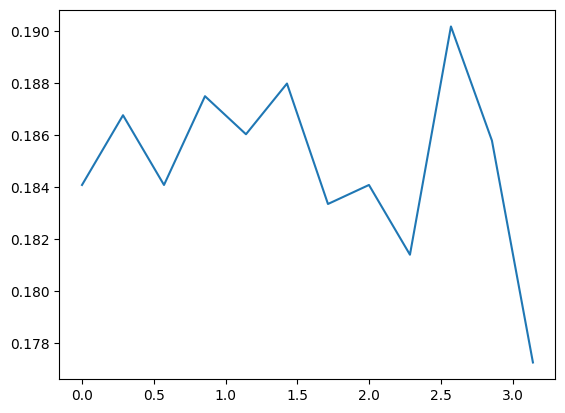

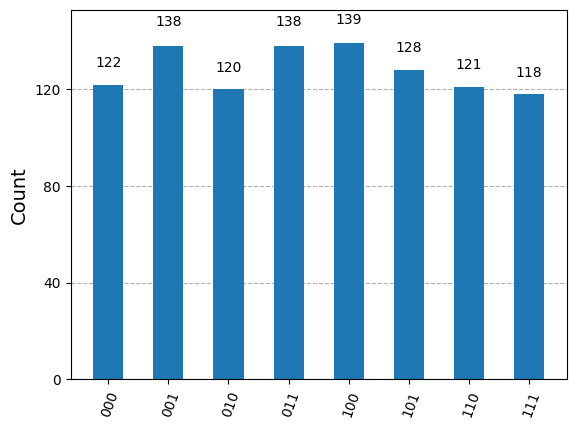

Measurement results (bitstrings):
{'100': 143, '110': 123, '000': 128, '101': 110, '111': 125, '011': 130, '010': 135, '001': 130}


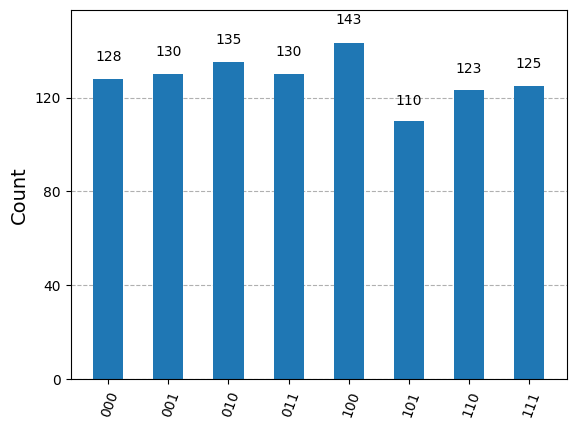

Measurement results (bitstrings):
{'110': 122, '101': 140, '111': 123, '011': 128, '010': 146, '100': 120, '001': 127, '000': 118}


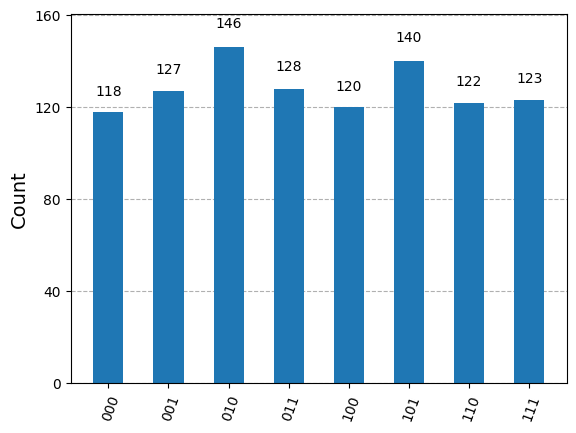

Measurement results (bitstrings):
{'000': 127, '110': 126, '111': 138, '101': 122, '100': 155, '011': 121, '001': 127, '010': 108}


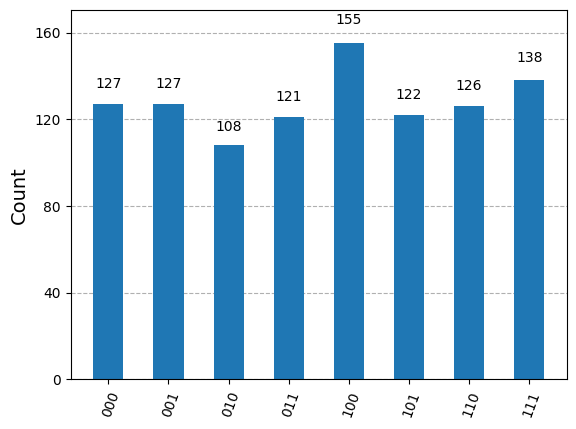

Measurement results (bitstrings):
{'011': 135, '000': 137, '111': 108, '001': 120, '010': 146, '110': 131, '100': 134, '101': 113}


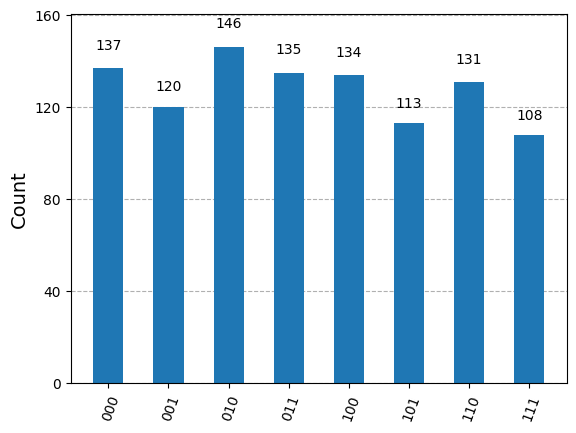

Measurement results (bitstrings):
{'110': 139, '101': 119, '000': 122, '011': 118, '100': 117, '111': 141, '001': 134, '010': 134}


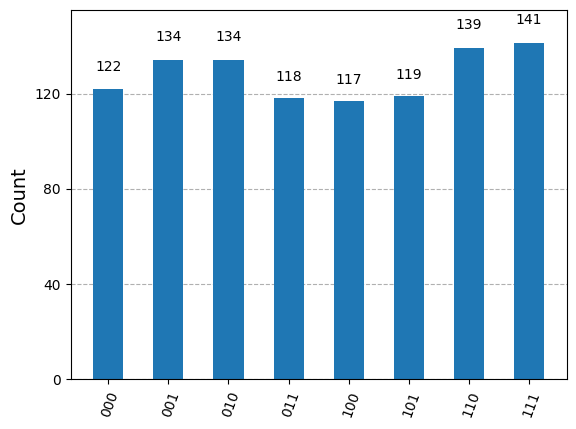

Measurement results (bitstrings):
{'111': 133, '101': 121, '010': 119, '001': 130, '100': 127, '000': 137, '011': 133, '110': 124}


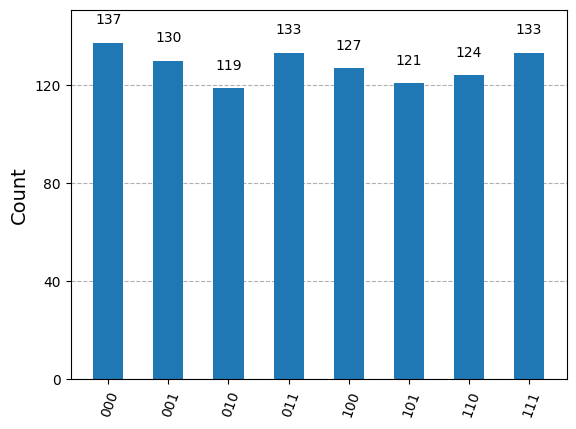

Measurement results (bitstrings):
{'110': 138, '001': 110, '111': 115, '101': 129, '100': 143, '000': 144, '011': 124, '010': 121}


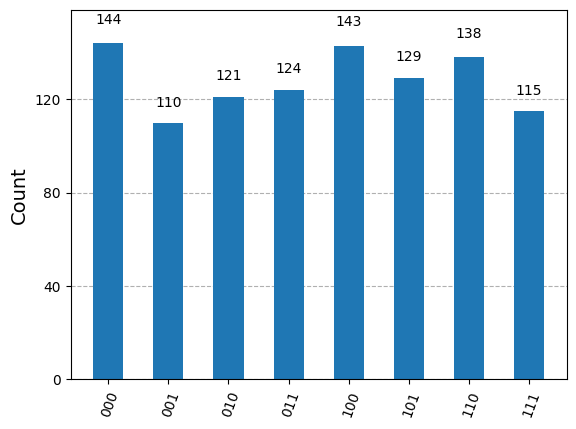

Measurement results (bitstrings):
{'011': 137, '000': 109, '101': 122, '001': 138, '110': 114, '111': 139, '100': 133, '010': 132}


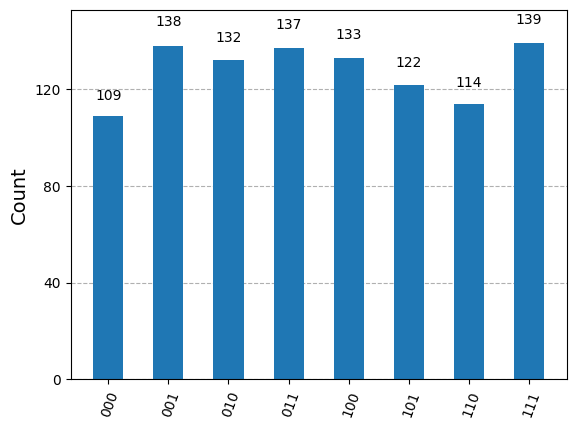

Measurement results (bitstrings):
{'100': 116, '001': 119, '110': 143, '101': 137, '111': 125, '010': 127, '000': 122, '011': 135}


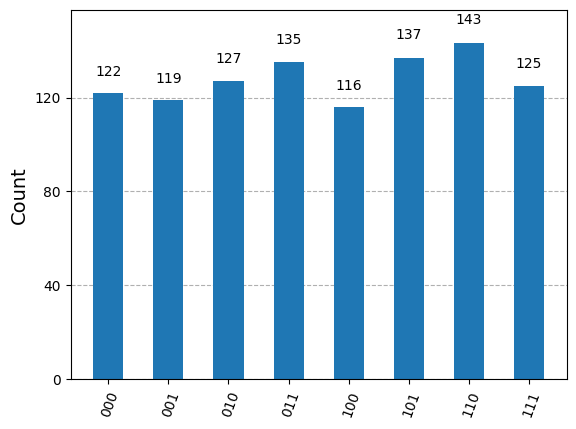

Measurement results (bitstrings):
{'000': 118, '111': 135, '011': 140, '100': 115, '001': 138, '101': 133, '010': 104, '110': 141}


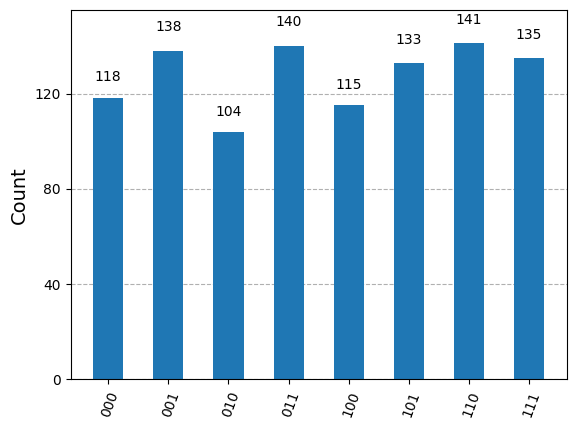

Measurement results (bitstrings):
{'101': 152, '111': 126, '110': 114, '001': 136, '100': 113, '011': 132, '010': 124, '000': 127}


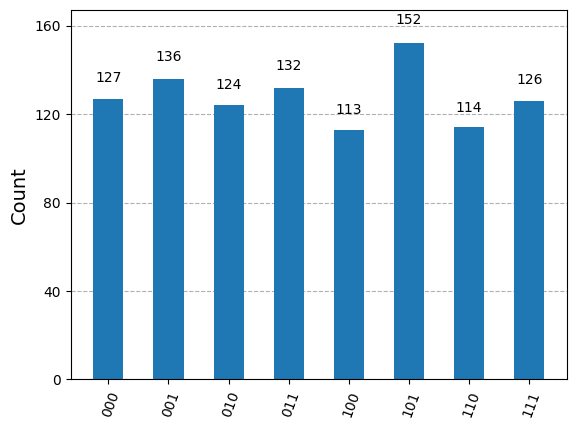

Measurement results (bitstrings):
{'0111': 66, '0101': 64, '1110': 57, '0110': 71, '0000': 69, '1000': 55, '0011': 68, '1101': 67, '1111': 54, '0010': 70, '1100': 66, '1010': 65, '1001': 56, '0001': 71, '1011': 61, '0100': 64}


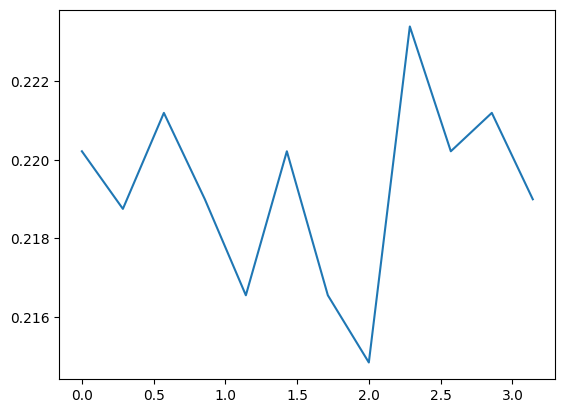

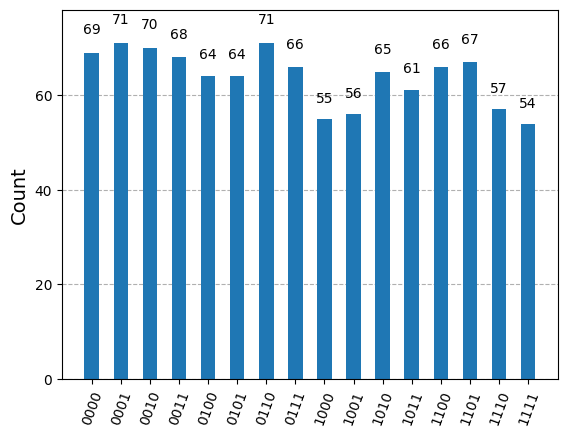

Measurement results (bitstrings):
{'1111': 65, '0110': 76, '1010': 73, '0001': 55, '0000': 56, '0100': 67, '1101': 64, '0111': 82, '1110': 63, '0011': 58, '0101': 66, '1000': 51, '0010': 55, '1100': 59, '1001': 74, '1011': 60}


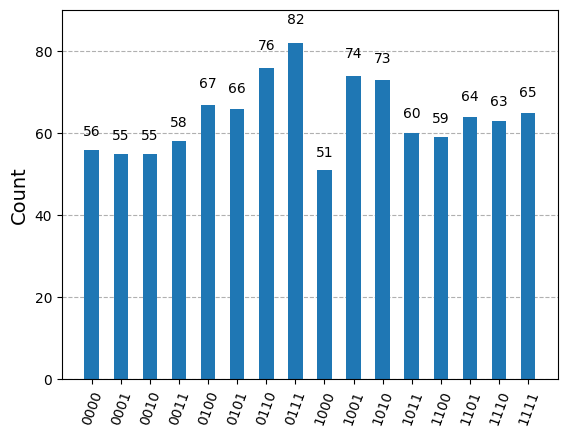

Measurement results (bitstrings):
{'1010': 61, '1101': 71, '0100': 58, '1000': 68, '0000': 60, '0010': 67, '1011': 63, '1111': 68, '0101': 56, '0110': 58, '1001': 59, '0111': 59, '1100': 55, '0011': 68, '0001': 71, '1110': 82}


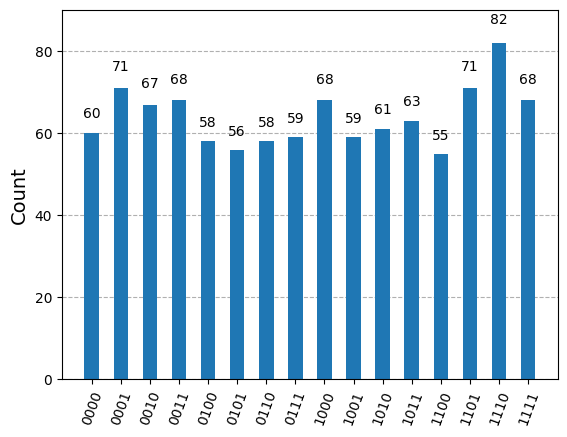

Measurement results (bitstrings):
{'0111': 70, '0110': 65, '0001': 73, '1001': 74, '0011': 62, '0010': 63, '1011': 61, '0000': 67, '0101': 66, '1000': 74, '1100': 65, '1101': 55, '1111': 63, '1010': 57, '1110': 66, '0100': 43}


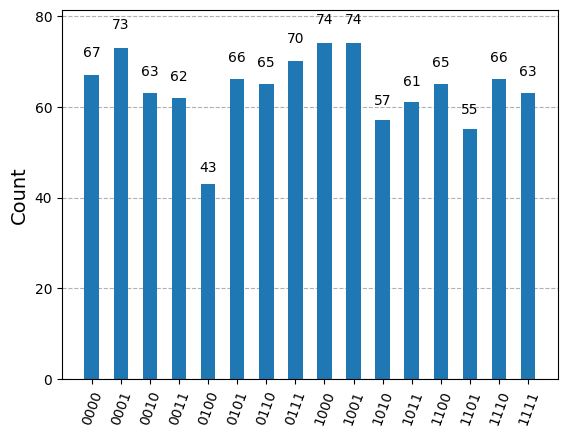

Measurement results (bitstrings):
{'0110': 66, '1000': 68, '1110': 64, '0010': 62, '1011': 66, '0011': 72, '0111': 59, '1101': 66, '0100': 56, '1111': 71, '1010': 52, '1001': 51, '0001': 61, '1100': 82, '0000': 65, '0101': 63}


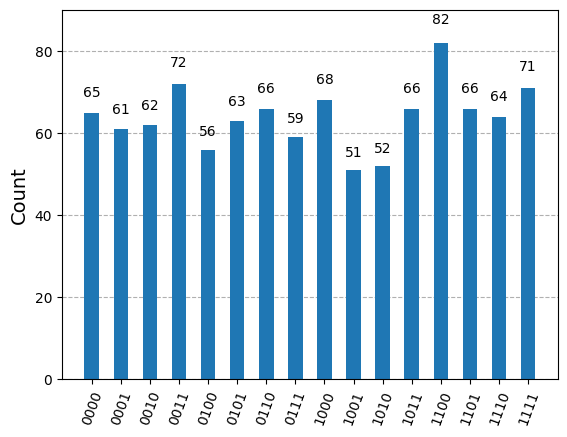

Measurement results (bitstrings):
{'1010': 74, '1001': 64, '0000': 61, '1000': 63, '1011': 57, '0011': 73, '1100': 78, '1101': 60, '1111': 67, '0111': 68, '0101': 60, '0001': 58, '1110': 54, '0010': 70, '0110': 57, '0100': 60}


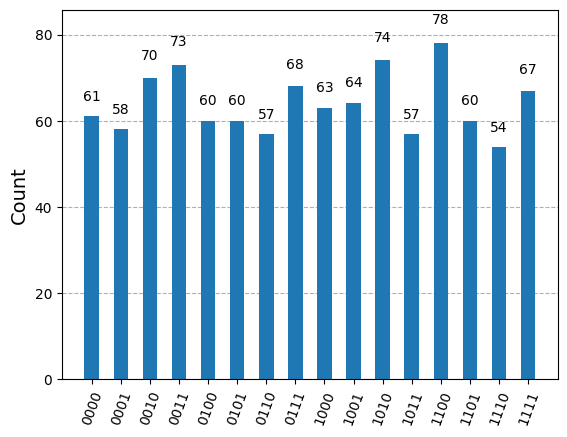

Measurement results (bitstrings):
{'1110': 59, '0001': 82, '1010': 48, '0010': 69, '1011': 64, '0011': 66, '0111': 69, '0110': 62, '0000': 57, '1101': 72, '1111': 70, '0101': 61, '1000': 60, '1001': 63, '1100': 57, '0100': 65}


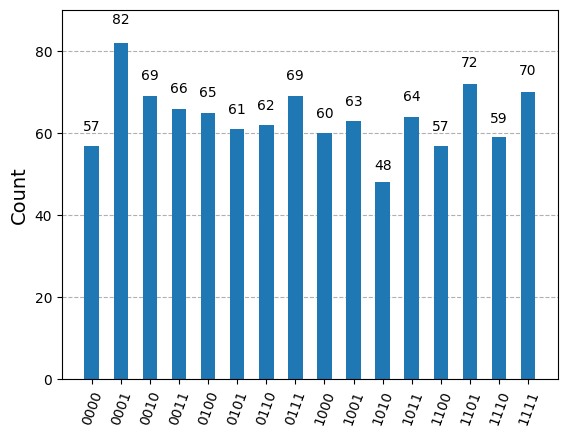

Measurement results (bitstrings):
{'0010': 65, '1110': 68, '0100': 54, '0011': 56, '0111': 67, '0001': 62, '1000': 81, '0000': 58, '1101': 64, '1100': 68, '1011': 62, '1111': 65, '1001': 46, '0101': 78, '1010': 68, '0110': 62}


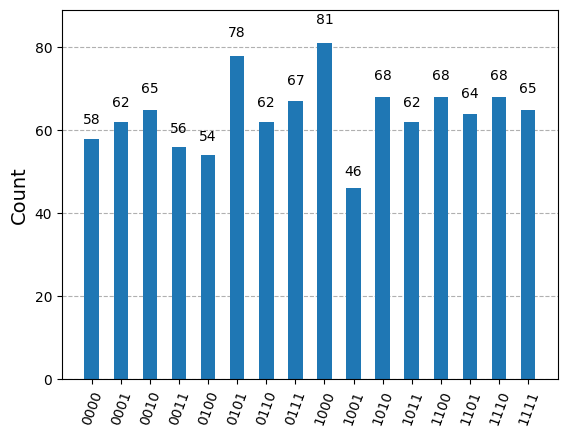

Measurement results (bitstrings):
{'1001': 65, '1010': 65, '1110': 78, '1011': 69, '0010': 74, '1101': 57, '0000': 57, '0011': 75, '1111': 62, '0111': 54, '1000': 48, '0001': 58, '0100': 56, '0101': 62, '1100': 74, '0110': 70}


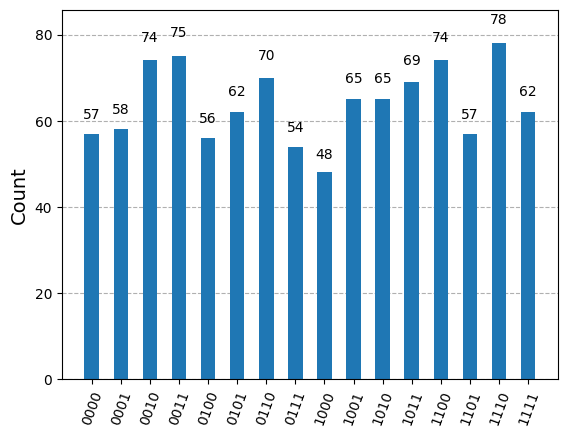

Measurement results (bitstrings):
{'0110': 48, '0010': 86, '1011': 66, '0111': 76, '1001': 60, '1000': 75, '0011': 68, '1100': 54, '1111': 65, '0101': 51, '1110': 58, '1101': 62, '0000': 66, '0100': 57, '0001': 68, '1010': 64}


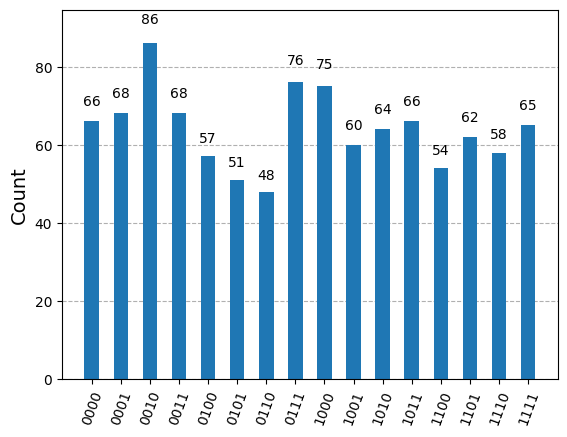

Measurement results (bitstrings):
{'1101': 58, '0001': 46, '1010': 69, '0011': 69, '0110': 64, '1111': 62, '0010': 67, '1011': 63, '0101': 78, '1110': 63, '0000': 56, '1000': 60, '1001': 70, '0111': 54, '1100': 70, '0100': 75}


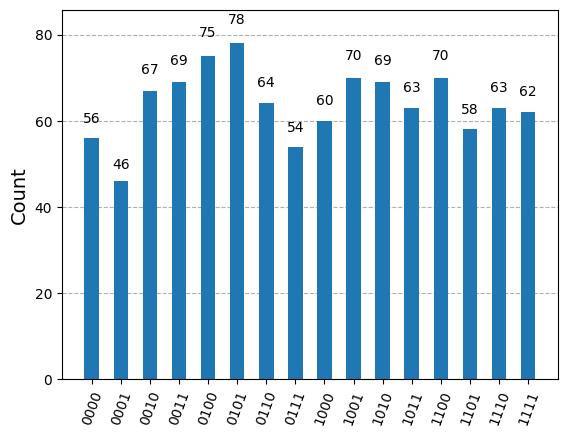

Measurement results (bitstrings):
{'1110': 73, '0101': 66, '1101': 58, '1011': 70, '0110': 63, '1000': 75, '0001': 55, '0011': 57, '0000': 74, '0111': 59, '1111': 64, '1100': 68, '0010': 63, '1010': 60, '1001': 60, '0100': 59}


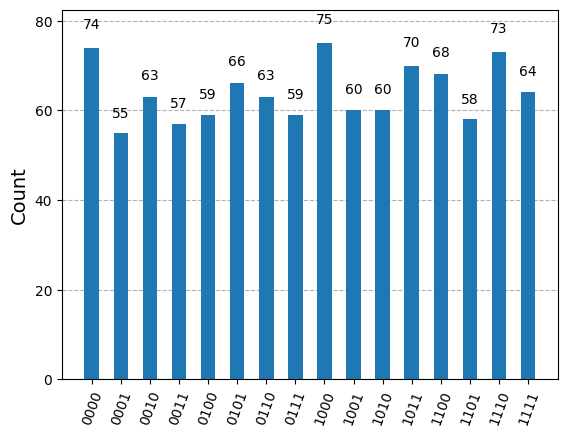

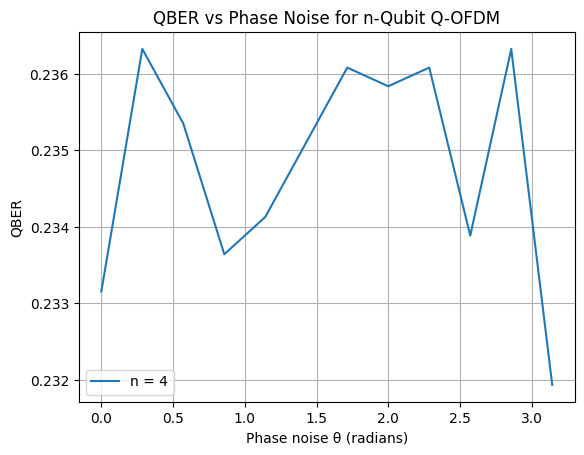

In [61]:
import matplotlib.pyplot as plt

theta_vals = np.linspace(0, np.pi, 12)

for n in [2, 3, 4]:
    qber = []
    for t in theta_vals:
        theta_k = np.zeros(2**n)
        theta_k[1] = t     # single disturbed subcarrier
        qber.append(run_qofdm_n(n, theta_vals=theta_k))

    plt.plot(theta_vals, qber, label=f"n = {n}")

plt.xlabel("Phase noise θ (radians)")
plt.ylabel("QBER")
plt.title("QBER vs Phase Noise for n-Qubit Q-OFDM")
plt.legend()
plt.grid(True)
plt.show()


Measurement results (bitstrings):
{'01': 241, '11': 278, '10': 247, '00': 258}


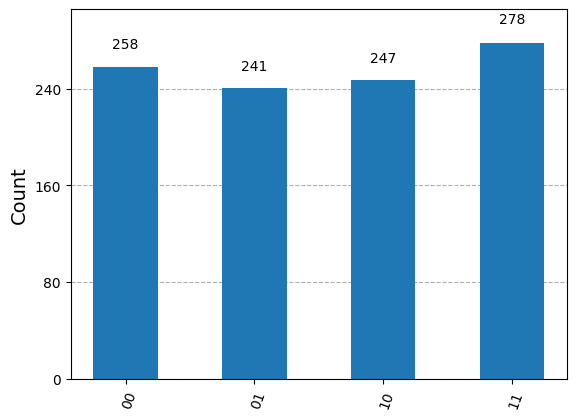

Measurement results (bitstrings):
{'00': 253, '11': 253, '01': 242, '10': 276}


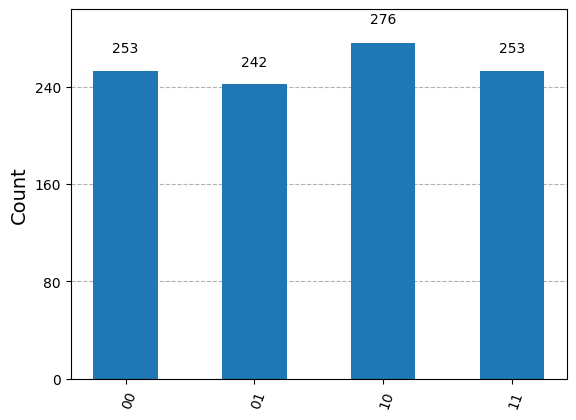

Measurement results (bitstrings):
{'11': 251, '10': 252, '01': 264, '00': 257}


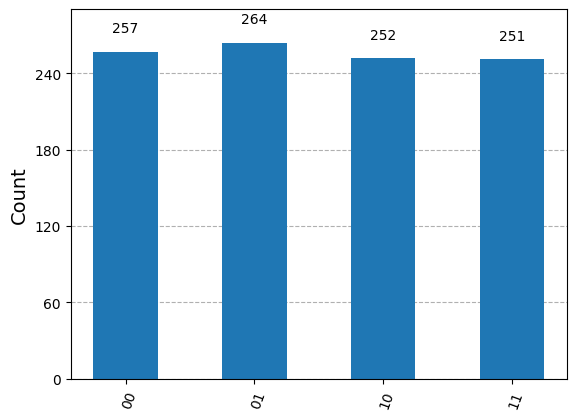

Measurement results (bitstrings):
{'00': 272, '10': 264, '11': 245, '01': 243}


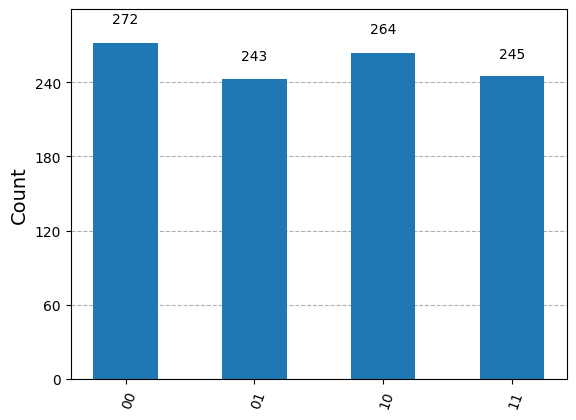

Measurement results (bitstrings):
{'01': 276, '00': 246, '10': 249, '11': 253}


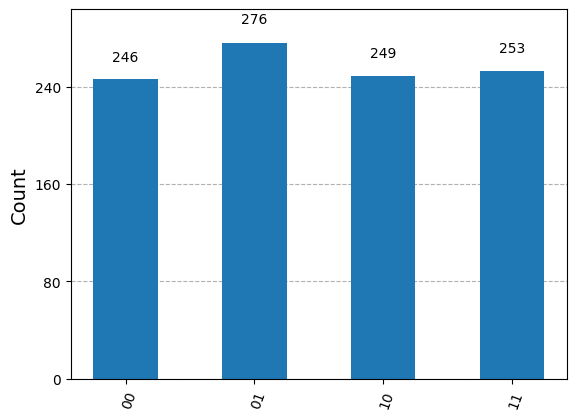

Measurement results (bitstrings):
{'11': 250, '01': 261, '00': 256, '10': 257}


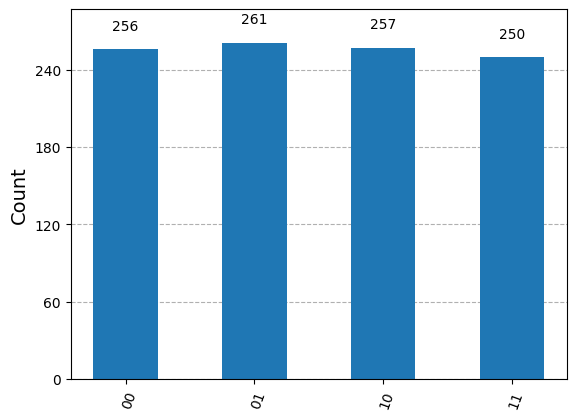

Measurement results (bitstrings):
{'01': 288, '10': 266, '11': 239, '00': 231}


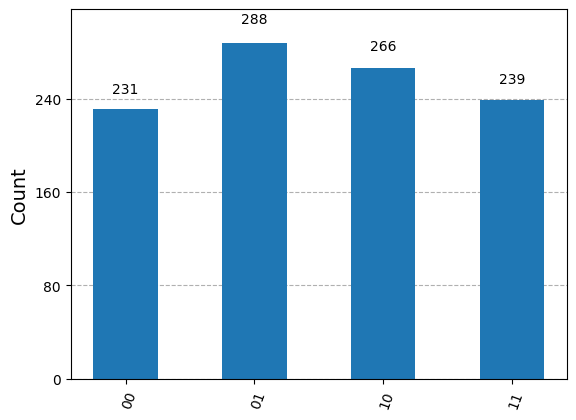

Measurement results (bitstrings):
{'00': 239, '10': 249, '11': 266, '01': 270}


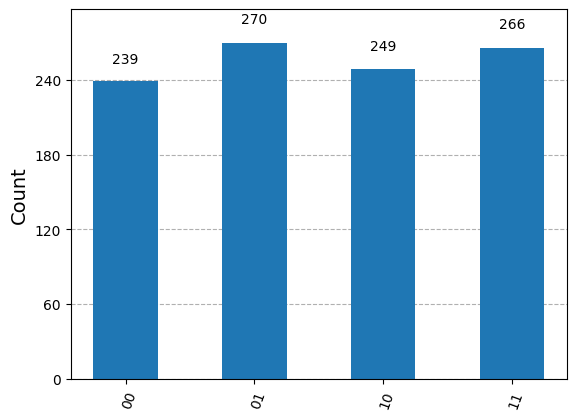

Measurement results (bitstrings):
{'11': 247, '01': 281, '00': 253, '10': 243}


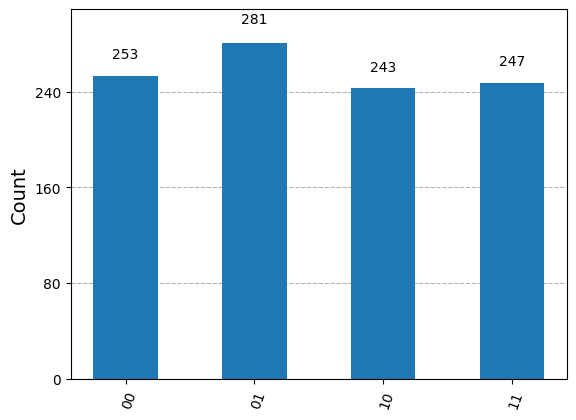

Measurement results (bitstrings):
{'00': 259, '11': 250, '01': 280, '10': 235}


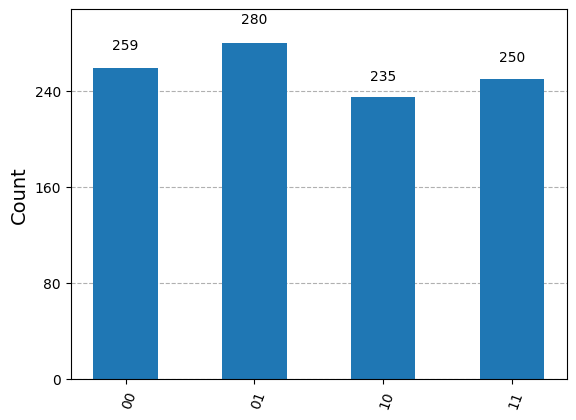

Measurement results (bitstrings):
{'011': 123, '010': 138, '110': 136, '111': 139, '100': 124, '000': 123, '101': 116, '001': 125}


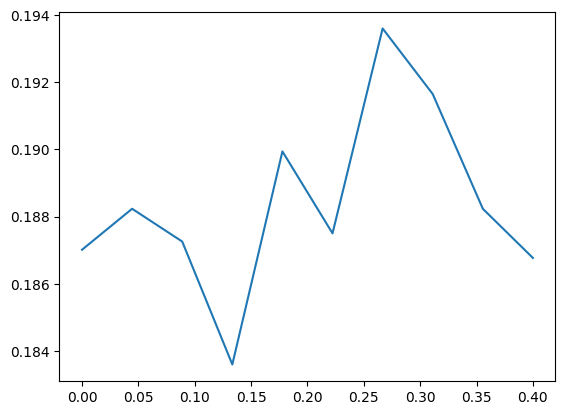

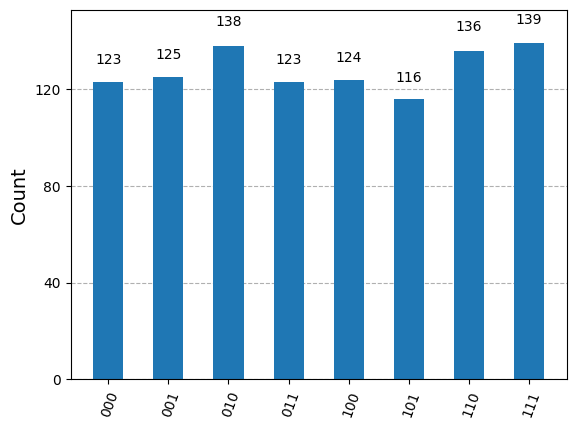

Measurement results (bitstrings):
{'100': 122, '101': 149, '000': 104, '011': 122, '110': 142, '010': 134, '111': 129, '001': 122}


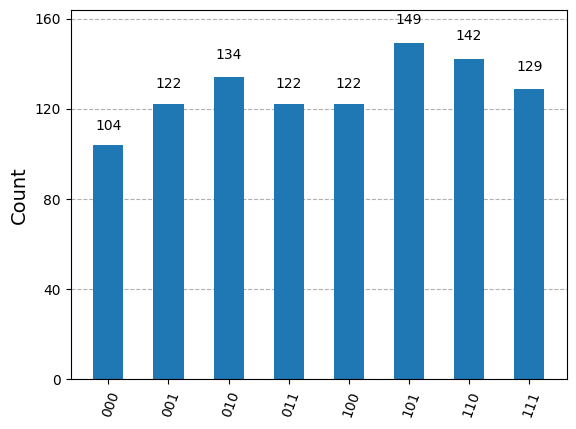

Measurement results (bitstrings):
{'010': 146, '110': 125, '111': 124, '100': 144, '011': 118, '101': 132, '000': 121, '001': 114}


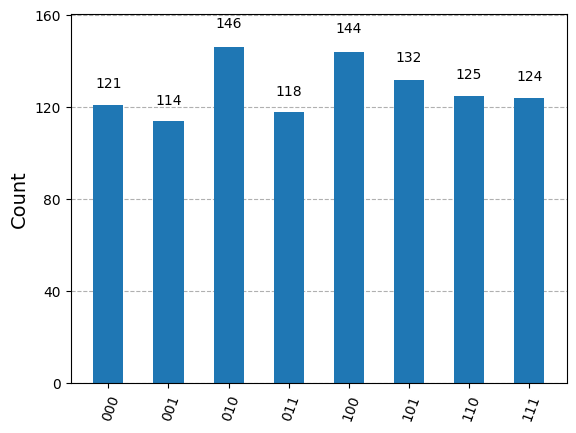

Measurement results (bitstrings):
{'111': 136, '110': 127, '000': 112, '010': 140, '101': 120, '001': 124, '100': 138, '011': 127}


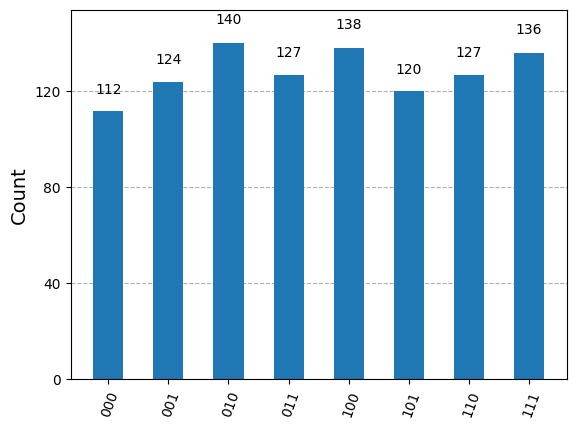

Measurement results (bitstrings):
{'001': 121, '000': 126, '011': 130, '010': 137, '111': 126, '100': 120, '110': 133, '101': 131}


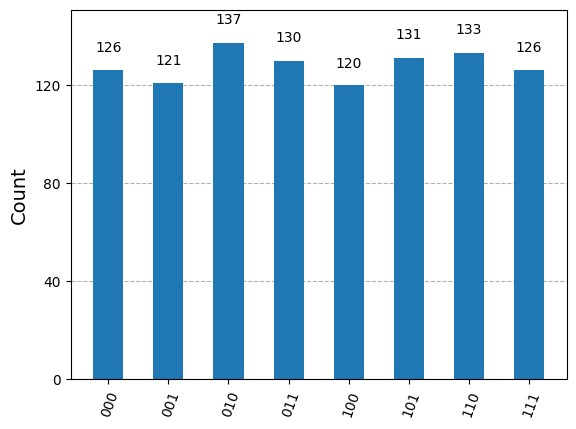

Measurement results (bitstrings):
{'100': 119, '101': 132, '011': 122, '010': 125, '001': 126, '000': 142, '110': 115, '111': 143}


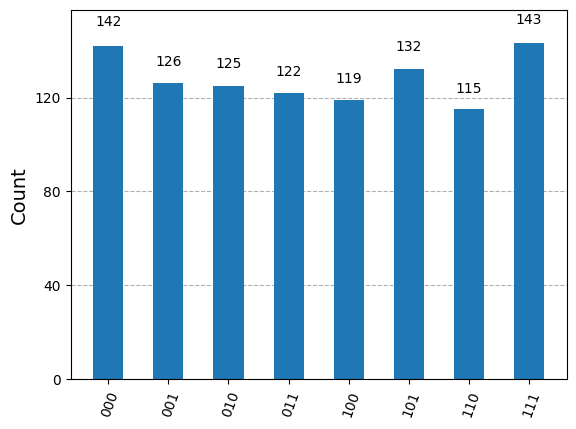

Measurement results (bitstrings):
{'000': 112, '100': 143, '101': 149, '010': 145, '111': 127, '001': 98, '011': 130, '110': 120}


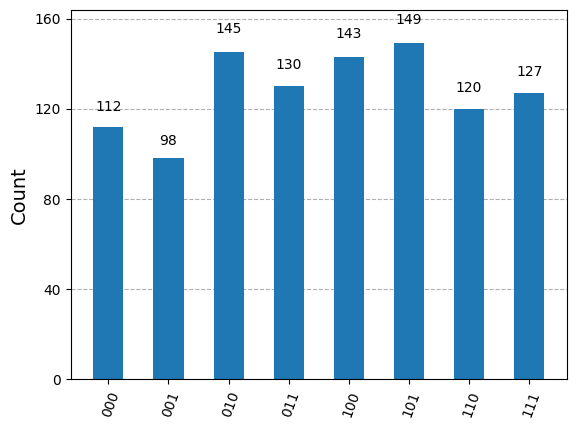

Measurement results (bitstrings):
{'110': 146, '101': 115, '011': 133, '100': 116, '010': 137, '000': 112, '111': 123, '001': 142}


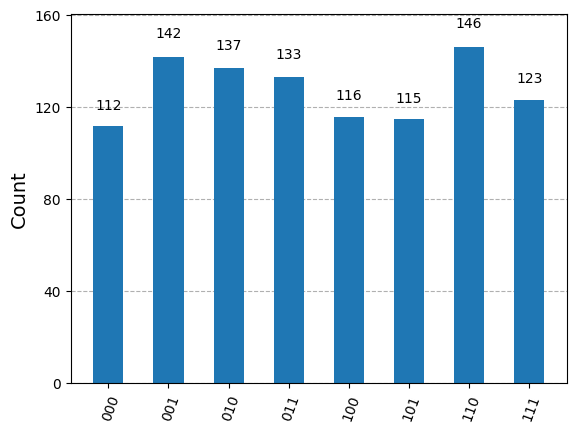

Measurement results (bitstrings):
{'011': 115, '111': 128, '101': 134, '000': 123, '100': 130, '110': 128, '001': 129, '010': 137}


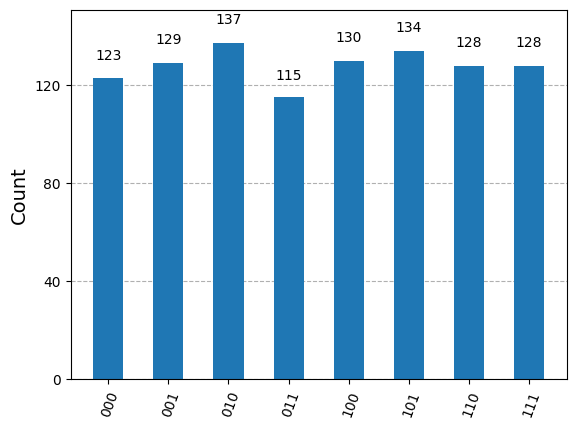

Measurement results (bitstrings):
{'000': 123, '001': 113, '010': 132, '011': 134, '110': 132, '101': 135, '100': 112, '111': 143}


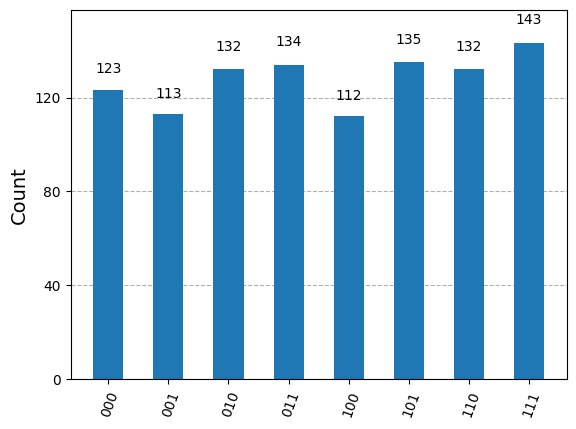

Measurement results (bitstrings):
{'0111': 62, '1110': 61, '1011': 62, '0010': 64, '0000': 60, '1000': 59, '0011': 67, '1100': 69, '0101': 61, '1001': 81, '1010': 67, '0110': 60, '0001': 70, '1111': 71, '1101': 57, '0100': 53}


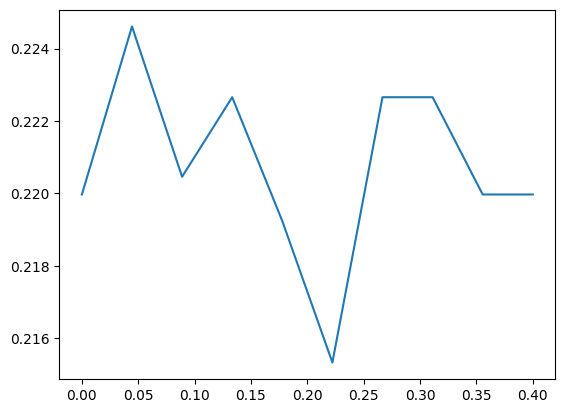

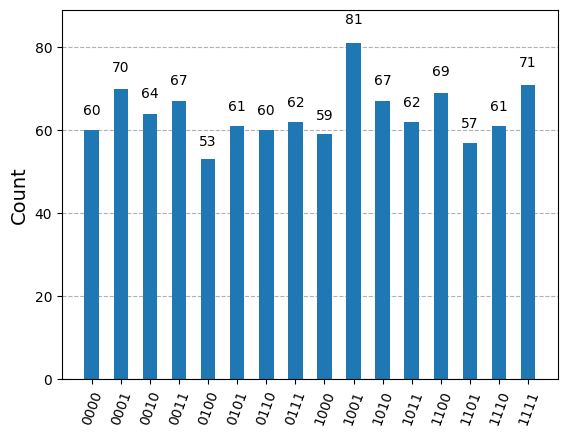

Measurement results (bitstrings):
{'1110': 60, '0101': 63, '0000': 68, '1000': 73, '1001': 61, '1010': 70, '1011': 65, '1111': 72, '0010': 62, '0111': 72, '1100': 56, '0110': 49, '0001': 68, '1101': 58, '0100': 65, '0011': 62}


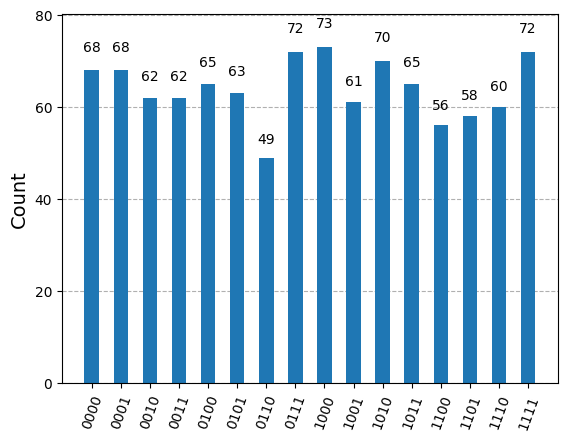

Measurement results (bitstrings):
{'1001': 75, '0001': 68, '1010': 56, '1000': 65, '0101': 59, '0011': 49, '0010': 68, '0111': 71, '0110': 63, '0100': 67, '1100': 73, '1101': 72, '1111': 58, '1011': 53, '1110': 64, '0000': 63}


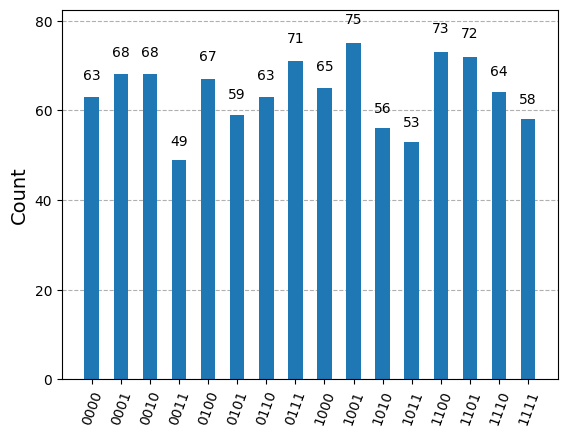

Measurement results (bitstrings):
{'1111': 58, '0110': 68, '0001': 69, '1010': 70, '1011': 57, '0011': 59, '0100': 79, '0111': 66, '0000': 63, '1001': 59, '1000': 63, '1101': 59, '1110': 69, '0101': 62, '1100': 63, '0010': 60}


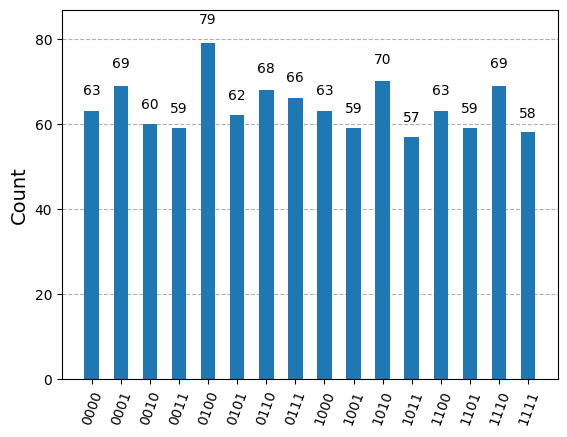

Measurement results (bitstrings):
{'0101': 60, '1110': 66, '1010': 79, '1111': 69, '0010': 61, '0000': 73, '0011': 60, '0100': 75, '1000': 51, '1001': 57, '1100': 51, '0111': 65, '1101': 66, '1011': 61, '0001': 66, '0110': 64}


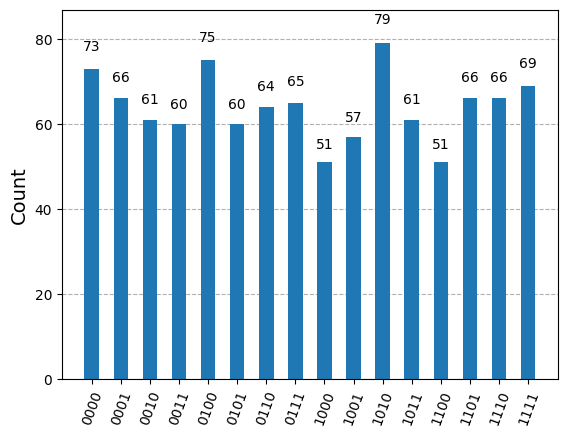

Measurement results (bitstrings):
{'1100': 54, '1110': 63, '0101': 55, '0010': 68, '0110': 54, '1111': 60, '1000': 66, '0001': 66, '0000': 70, '1011': 78, '1001': 61, '0100': 67, '1101': 63, '0011': 81, '1010': 58, '0111': 60}


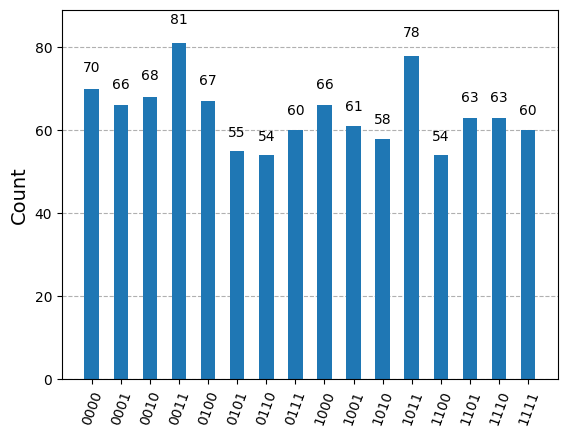

Measurement results (bitstrings):
{'0100': 64, '1101': 65, '1111': 59, '0110': 71, '1010': 64, '0001': 67, '0011': 67, '1110': 67, '1001': 70, '0000': 60, '1011': 62, '0101': 59, '0010': 69, '1000': 69, '1100': 56, '0111': 55}


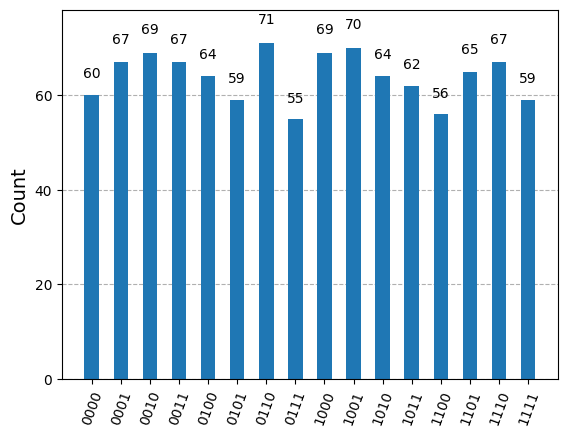

Measurement results (bitstrings):
{'1011': 71, '0001': 72, '1001': 56, '1100': 73, '0011': 73, '0111': 62, '0000': 66, '1110': 69, '0100': 57, '1101': 64, '1010': 61, '1000': 59, '1111': 65, '0101': 66, '0110': 60, '0010': 50}


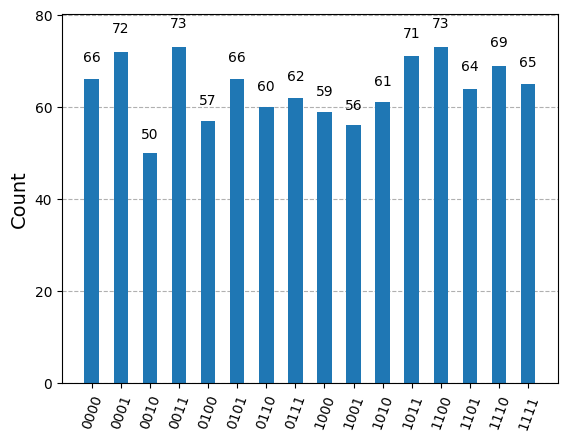

Measurement results (bitstrings):
{'1100': 68, '0000': 58, '0101': 62, '0111': 45, '0100': 67, '1101': 75, '1010': 56, '1001': 68, '1110': 55, '1111': 62, '0010': 67, '0001': 67, '1011': 84, '0110': 70, '0011': 56, '1000': 64}


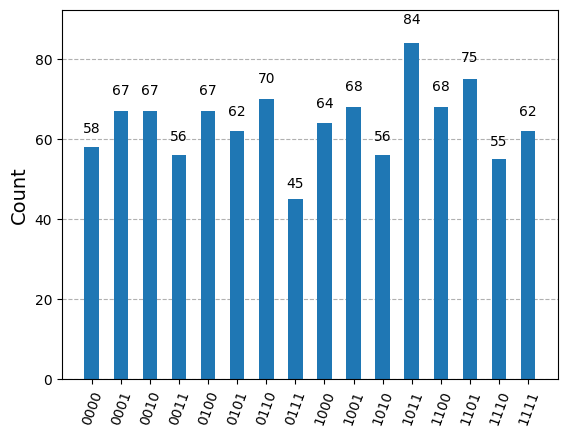

Measurement results (bitstrings):
{'1111': 67, '0001': 60, '1101': 56, '0100': 57, '1011': 69, '0111': 63, '1100': 60, '0101': 65, '1001': 67, '0110': 64, '1110': 76, '0011': 73, '1010': 65, '0000': 59, '1000': 75, '0010': 48}


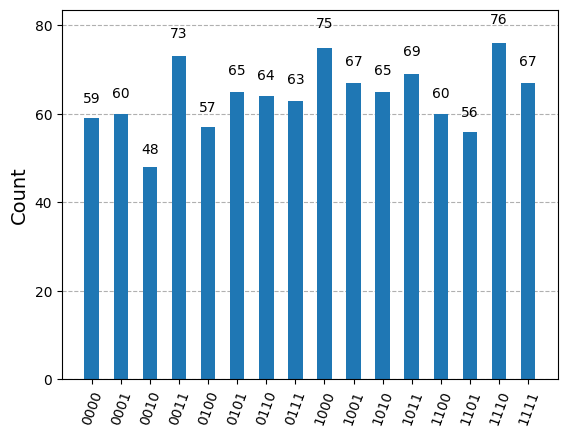

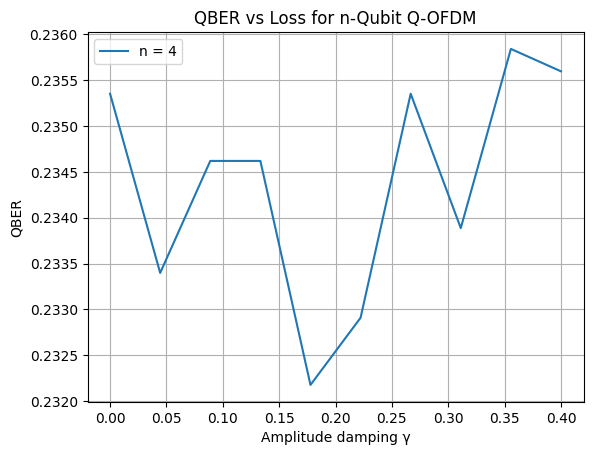

In [62]:
gamma_vals = np.linspace(0, 0.4, 10)

for n in [2, 3, 4]:
    qber = []
    for g in gamma_vals:
        qber.append(run_qofdm_n(n, gamma=g))
    plt.plot(gamma_vals, qber, label=f"n = {n}")

plt.xlabel("Amplitude damping γ")
plt.ylabel("QBER")
plt.title("QBER vs Loss for n-Qubit Q-OFDM")
plt.legend()
plt.grid(True)
plt.show()


In [63]:
#Add QKD security threshold lines (11%)

Measurement results (bitstrings):
{'11': 256, '00': 260, '01': 255, '10': 253}


<Figure size 640x480 with 0 Axes>

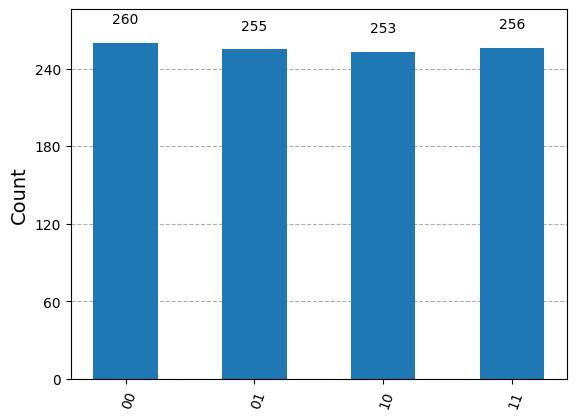

Measurement results (bitstrings):
{'00': 265, '10': 242, '01': 251, '11': 266}


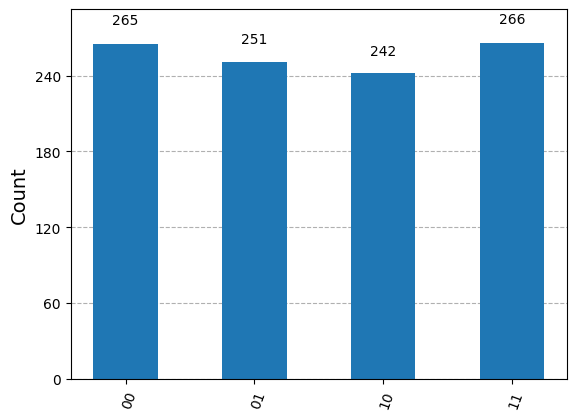

Measurement results (bitstrings):
{'01': 242, '11': 267, '00': 265, '10': 250}


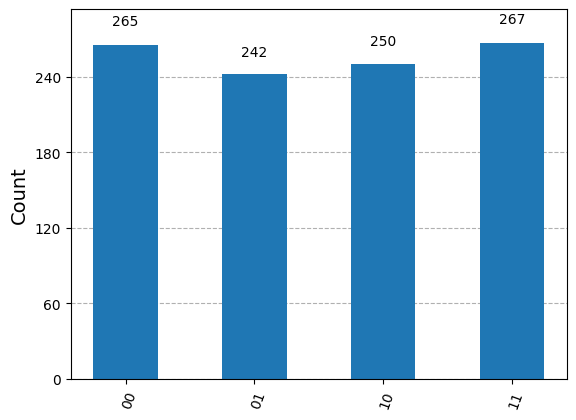

Measurement results (bitstrings):
{'11': 230, '10': 258, '01': 272, '00': 264}


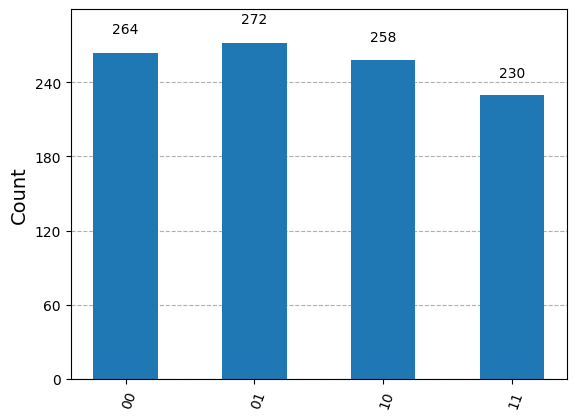

Measurement results (bitstrings):
{'10': 247, '00': 270, '01': 253, '11': 254}


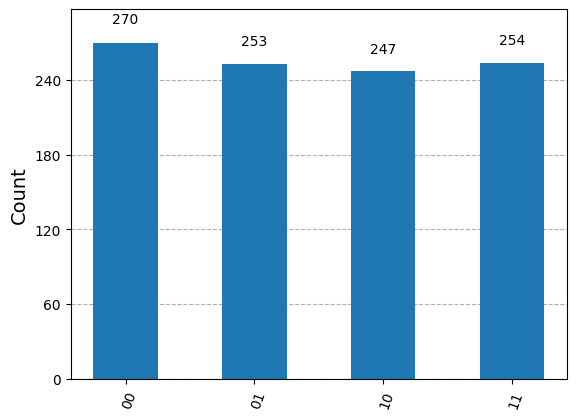

Measurement results (bitstrings):
{'01': 259, '00': 259, '11': 243, '10': 263}


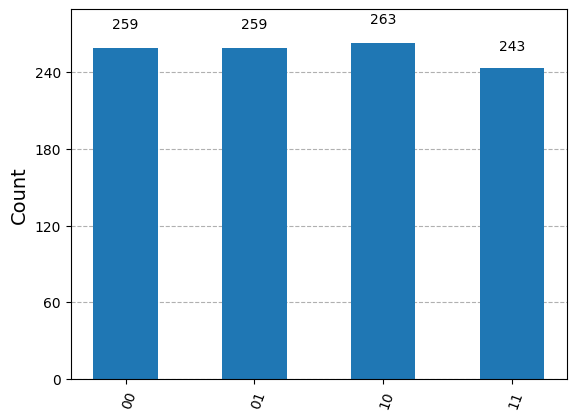

Measurement results (bitstrings):
{'10': 288, '11': 252, '00': 258, '01': 226}


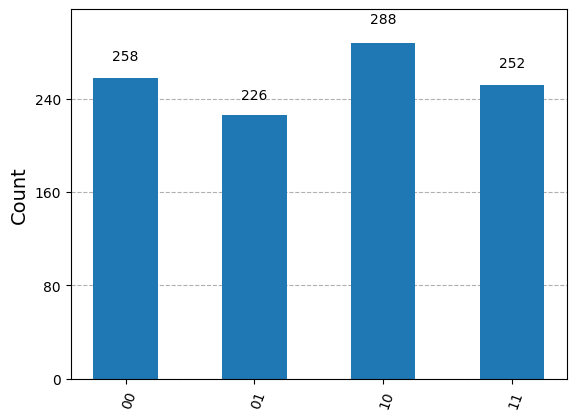

Measurement results (bitstrings):
{'00': 258, '01': 268, '11': 244, '10': 254}


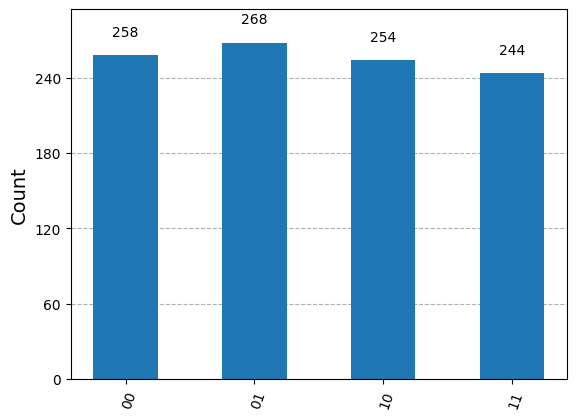

Measurement results (bitstrings):
{'10': 268, '11': 246, '01': 250, '00': 260}


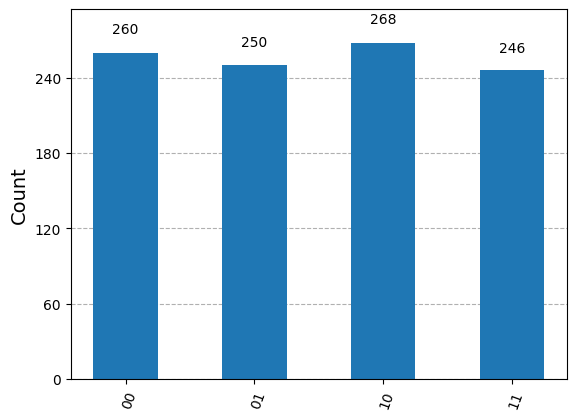

Measurement results (bitstrings):
{'11': 252, '00': 276, '01': 249, '10': 247}


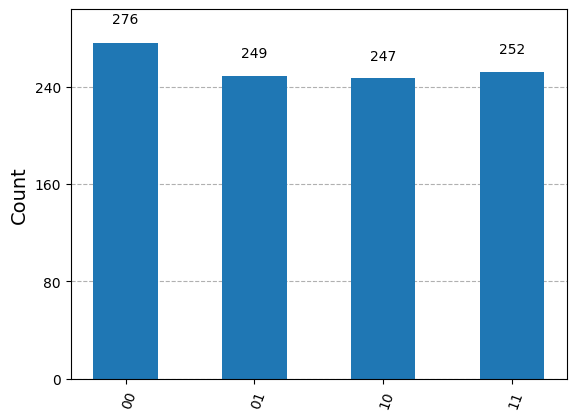

Measurement results (bitstrings):
{'11': 265, '01': 262, '00': 256, '10': 241}


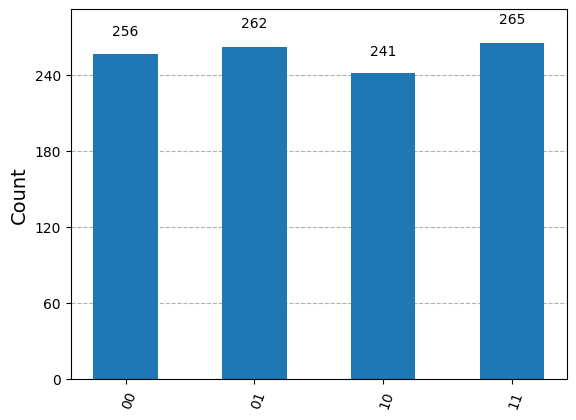

Measurement results (bitstrings):
{'01': 266, '11': 240, '00': 263, '10': 255}


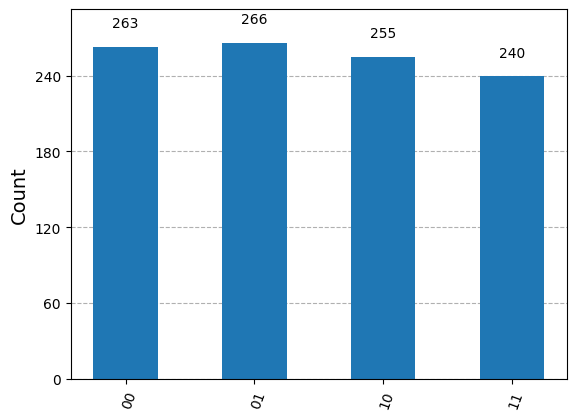

Measurement results (bitstrings):
{'001': 146, '010': 122, '111': 125, '100': 129, '110': 135, '101': 122, '000': 125, '011': 120}


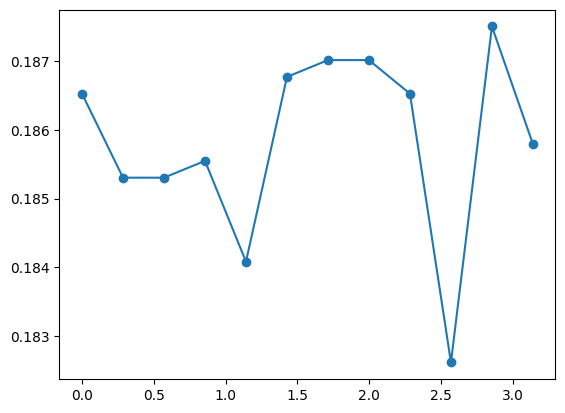

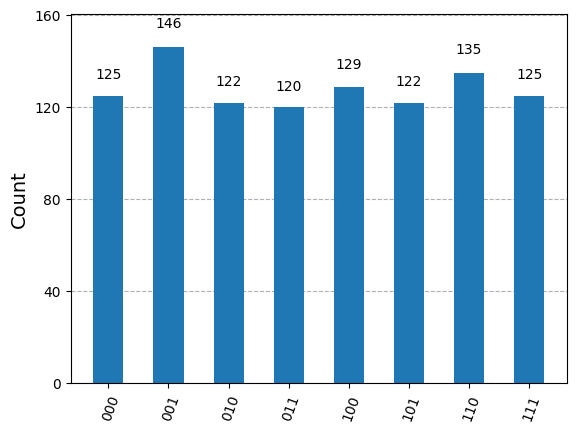

Measurement results (bitstrings):
{'010': 130, '100': 128, '111': 136, '001': 142, '110': 126, '011': 110, '101': 120, '000': 132}


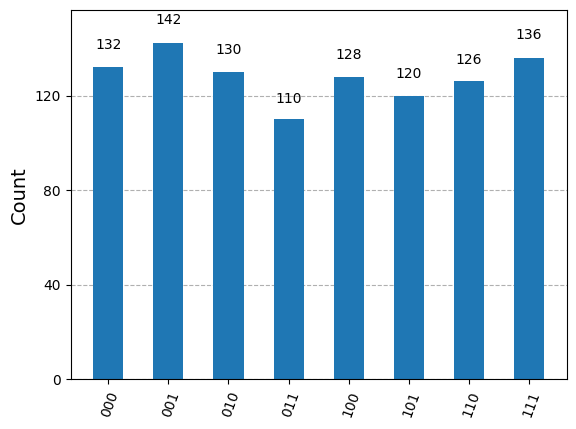

Measurement results (bitstrings):
{'100': 134, '011': 111, '010': 130, '111': 113, '110': 127, '000': 158, '001': 121, '101': 130}


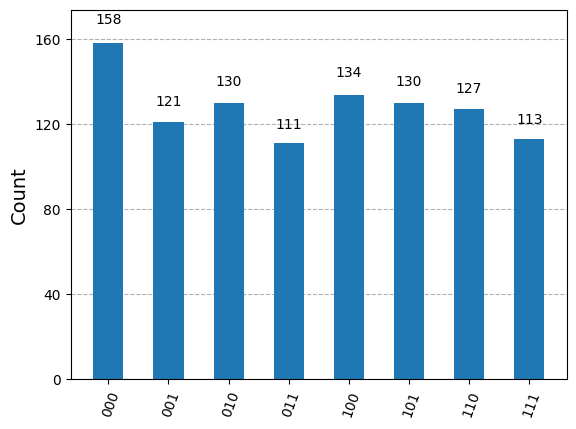

Measurement results (bitstrings):
{'101': 126, '011': 126, '001': 134, '010': 137, '110': 128, '000': 114, '100': 133, '111': 126}


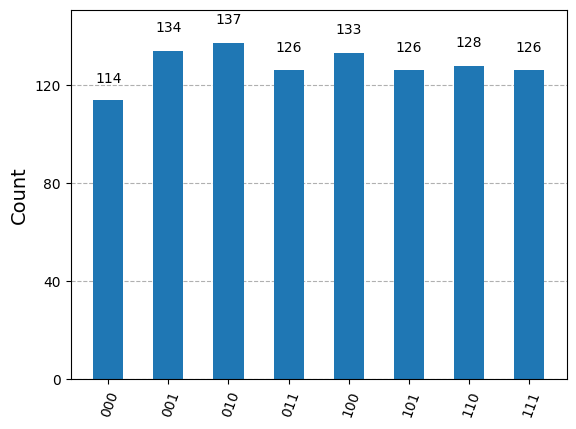

Measurement results (bitstrings):
{'101': 145, '111': 129, '000': 133, '001': 124, '100': 119, '110': 119, '010': 125, '011': 130}


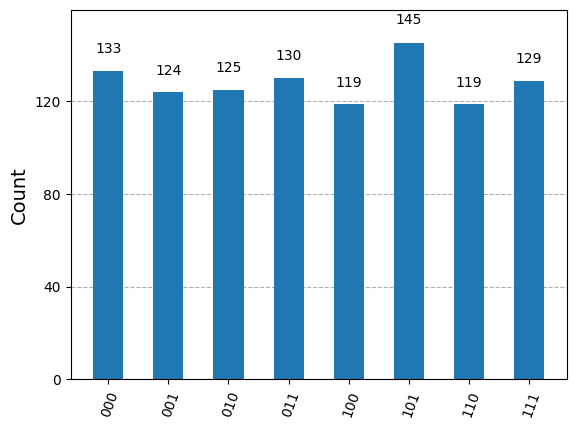

Measurement results (bitstrings):
{'000': 146, '100': 123, '011': 120, '110': 113, '001': 136, '101': 135, '111': 125, '010': 126}


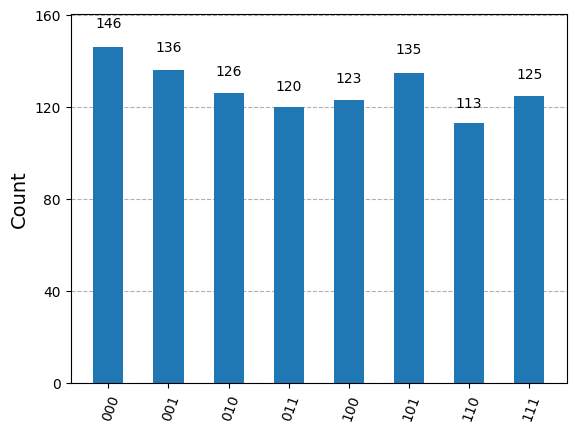

Measurement results (bitstrings):
{'111': 149, '011': 131, '101': 129, '010': 136, '100': 113, '001': 107, '000': 127, '110': 132}


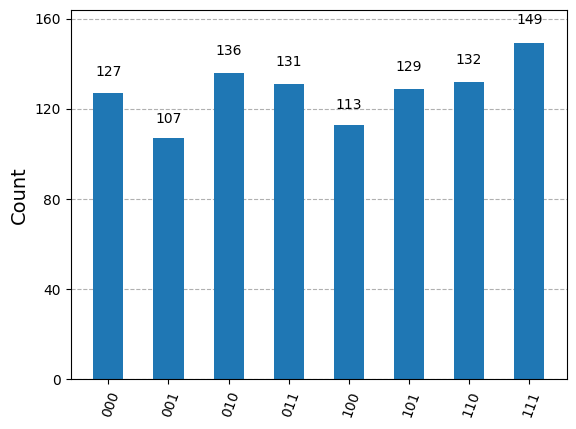

Measurement results (bitstrings):
{'110': 146, '111': 118, '101': 143, '011': 123, '000': 127, '010': 117, '001': 115, '100': 135}


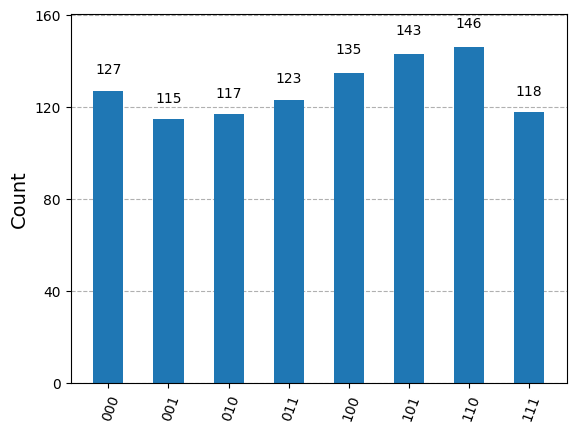

Measurement results (bitstrings):
{'010': 130, '111': 148, '100': 140, '101': 120, '011': 128, '110': 109, '000': 131, '001': 118}


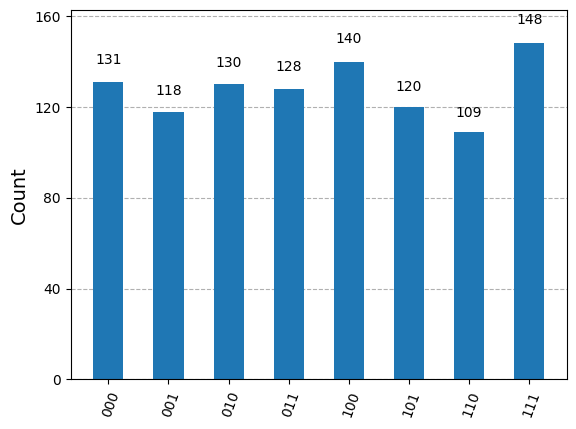

Measurement results (bitstrings):
{'110': 125, '000': 112, '011': 132, '101': 143, '100': 133, '010': 125, '111': 128, '001': 126}


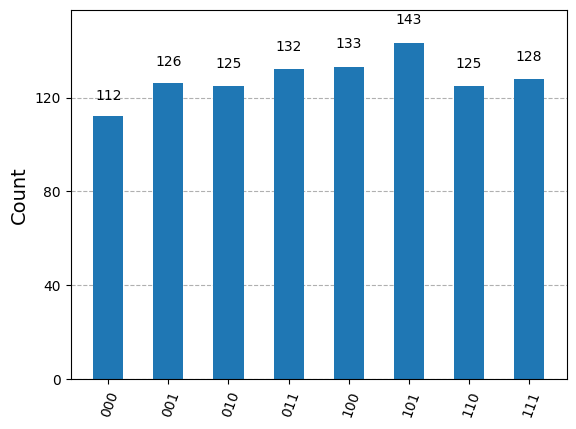

Measurement results (bitstrings):
{'000': 147, '001': 124, '111': 126, '011': 104, '110': 117, '101': 145, '100': 126, '010': 135}


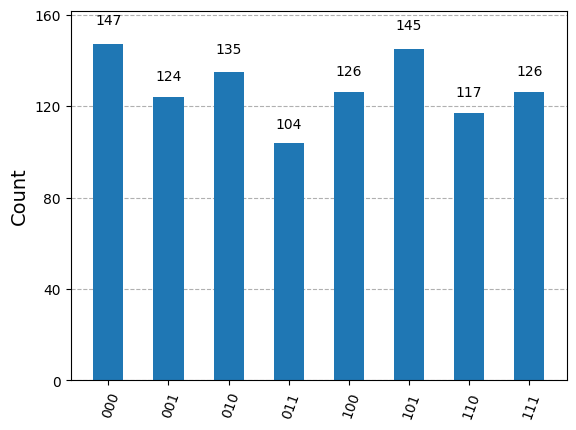

Measurement results (bitstrings):
{'111': 129, '110': 121, '100': 137, '011': 122, '001': 128, '000': 130, '010': 126, '101': 131}


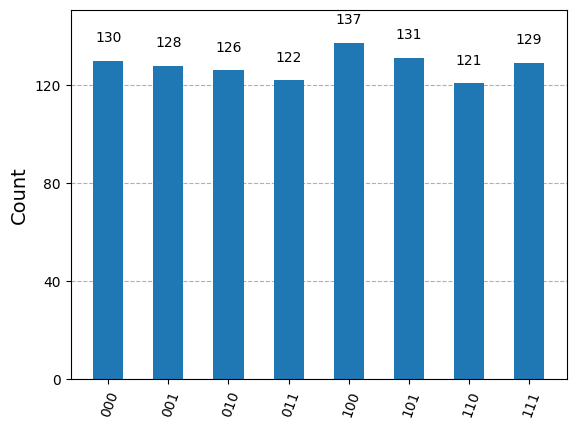

Measurement results (bitstrings):
{'1101': 49, '1010': 69, '0001': 71, '1100': 67, '0011': 71, '0000': 50, '0010': 71, '0101': 73, '0100': 67, '1110': 69, '1111': 66, '1000': 60, '1001': 60, '0111': 61, '1011': 57, '0110': 63}


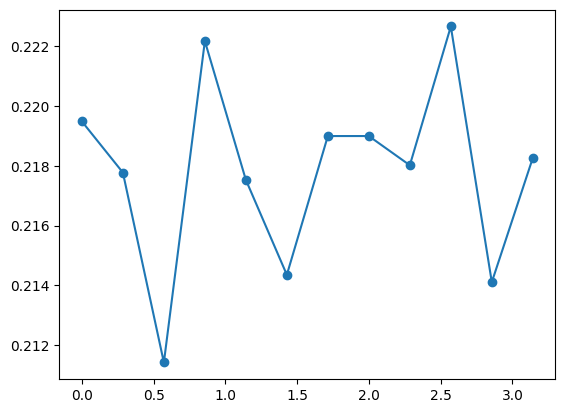

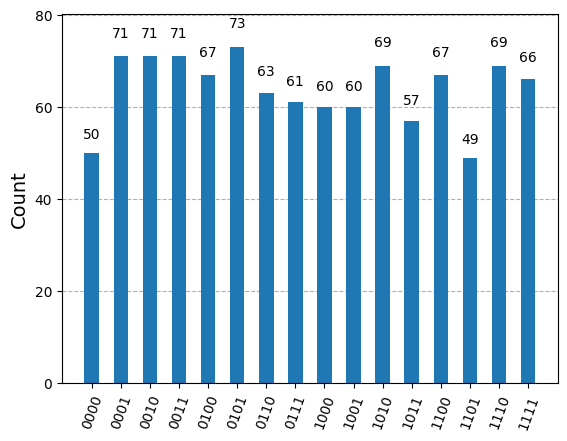

Measurement results (bitstrings):
{'1001': 67, '1000': 64, '0000': 65, '0011': 75, '1100': 69, '1110': 73, '0110': 47, '0111': 54, '0100': 73, '1011': 71, '0001': 70, '1010': 57, '0010': 67, '0101': 60, '1101': 50, '1111': 62}


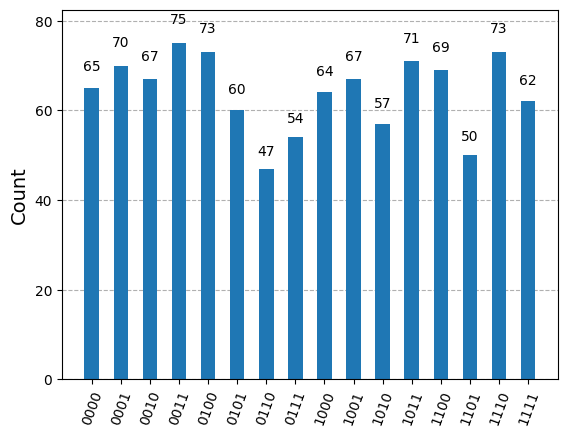

Measurement results (bitstrings):
{'1111': 80, '0110': 70, '0101': 58, '1101': 62, '0100': 52, '0010': 70, '0011': 61, '1010': 59, '0000': 76, '1001': 53, '0001': 69, '1011': 62, '0111': 72, '1000': 62, '1100': 59, '1110': 59}


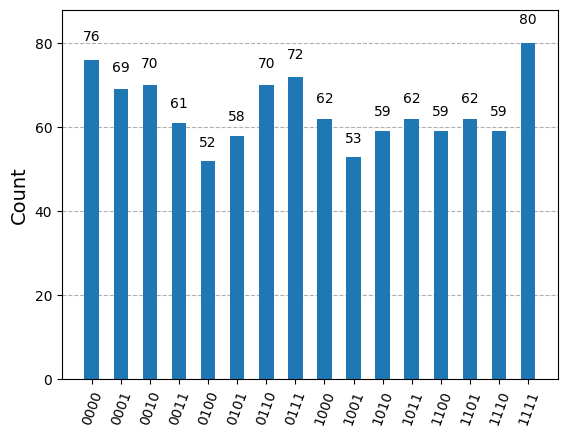

Measurement results (bitstrings):
{'1100': 60, '0110': 60, '1001': 60, '1010': 62, '0001': 75, '0100': 64, '1101': 63, '0010': 62, '1011': 66, '1110': 60, '1111': 61, '0000': 60, '1000': 70, '0011': 71, '0111': 57, '0101': 73}


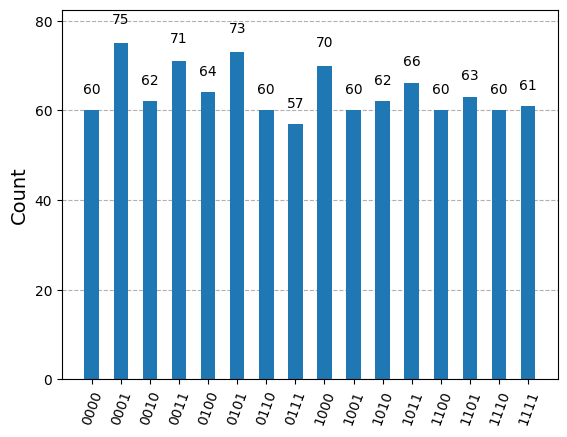

Measurement results (bitstrings):
{'1100': 61, '0101': 64, '0001': 61, '1001': 50, '1010': 65, '1011': 63, '0110': 66, '0111': 66, '1101': 64, '1000': 69, '0011': 70, '0000': 67, '1110': 67, '0010': 58, '1111': 57, '0100': 76}


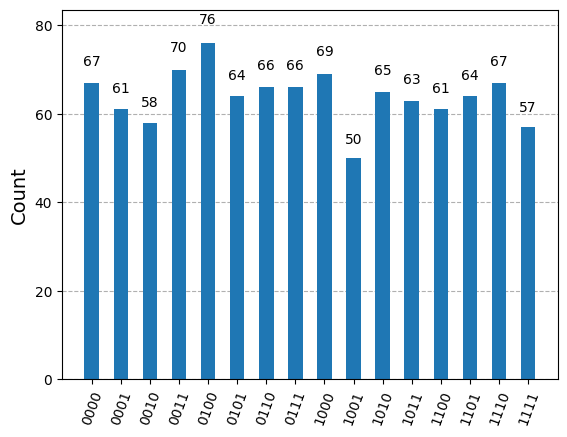

Measurement results (bitstrings):
{'0111': 58, '1001': 76, '0001': 62, '1010': 55, '1111': 52, '1000': 78, '0101': 63, '0011': 60, '0110': 74, '0100': 71, '0010': 64, '1011': 60, '0000': 59, '1100': 57, '1110': 69, '1101': 66}


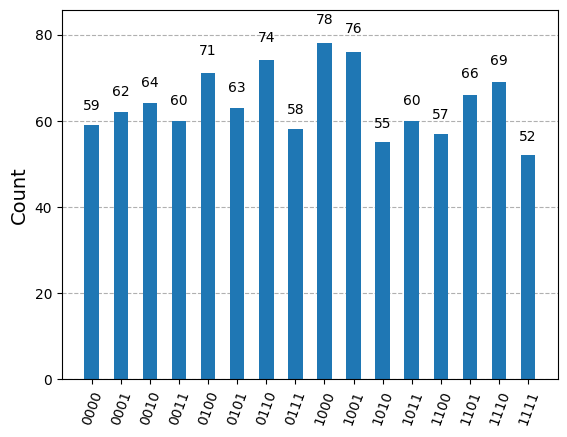

Measurement results (bitstrings):
{'1100': 72, '0011': 70, '1110': 62, '1010': 61, '1001': 64, '0010': 59, '0110': 74, '1111': 61, '1011': 82, '0100': 54, '0001': 63, '1000': 72, '1101': 56, '0101': 54, '0111': 55, '0000': 65}


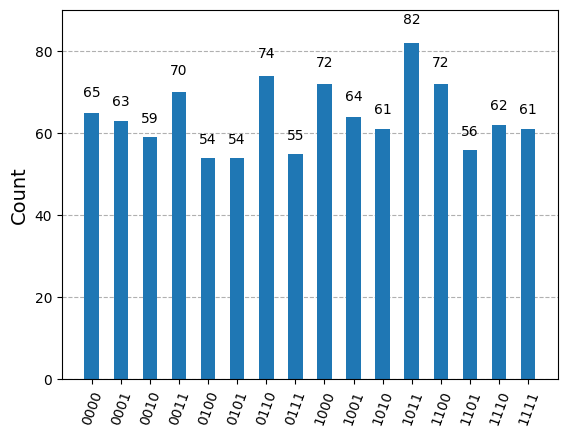

Measurement results (bitstrings):
{'0100': 62, '0001': 67, '0000': 57, '0110': 78, '1111': 71, '1110': 56, '0101': 63, '1100': 66, '1001': 61, '1101': 67, '1011': 72, '0111': 72, '1010': 55, '0011': 69, '1000': 54, '0010': 54}


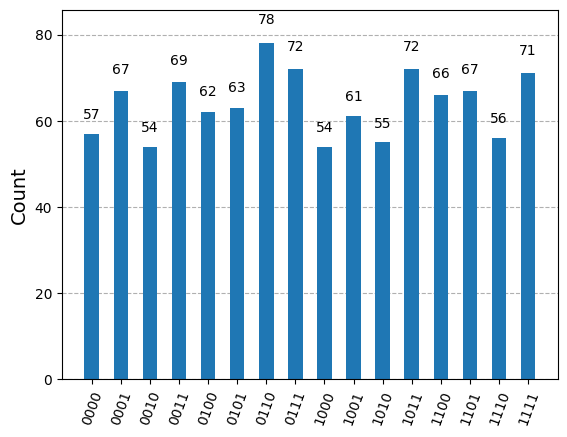

Measurement results (bitstrings):
{'0111': 57, '0110': 75, '1111': 76, '0001': 69, '1010': 65, '1001': 70, '1110': 57, '1100': 72, '0000': 58, '0101': 53, '0100': 46, '1000': 65, '0010': 63, '1101': 67, '1011': 59, '0011': 72}


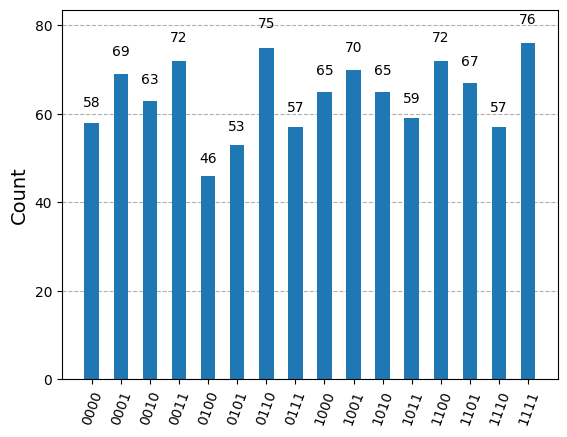

Measurement results (bitstrings):
{'1110': 61, '0100': 67, '1101': 58, '0111': 54, '1001': 81, '1011': 55, '0110': 67, '1100': 63, '1010': 71, '0000': 75, '1000': 57, '0010': 58, '0011': 58, '0101': 59, '1111': 67, '0001': 73}


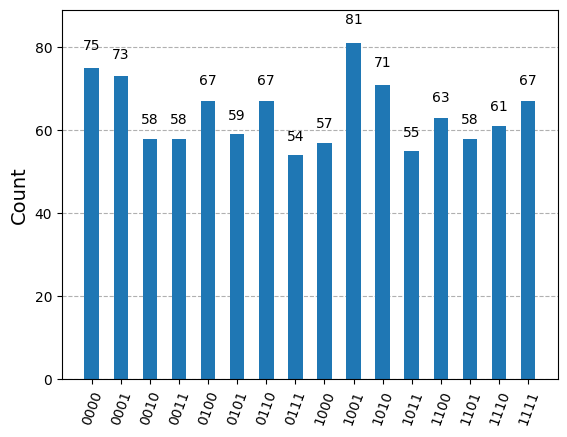

Measurement results (bitstrings):
{'1000': 59, '1110': 73, '0001': 63, '1011': 44, '1100': 62, '1101': 60, '0100': 70, '0110': 60, '0010': 69, '0011': 78, '1010': 58, '1111': 60, '0000': 67, '0111': 62, '0101': 68, '1001': 71}


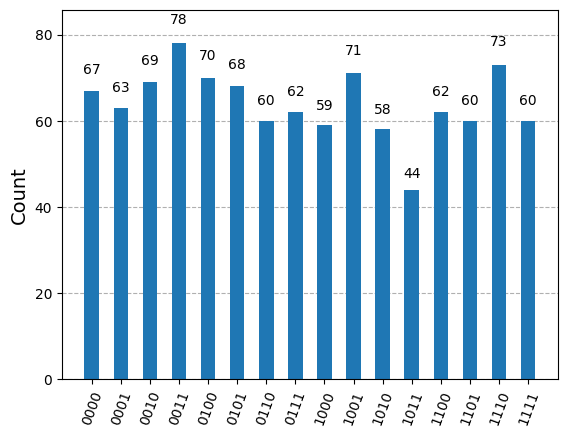

Measurement results (bitstrings):
{'0010': 71, '0101': 76, '0111': 66, '1001': 44, '0001': 64, '1010': 70, '1111': 78, '1000': 63, '0011': 72, '1101': 73, '1110': 51, '1100': 55, '0100': 69, '1011': 62, '0000': 63, '0110': 47}


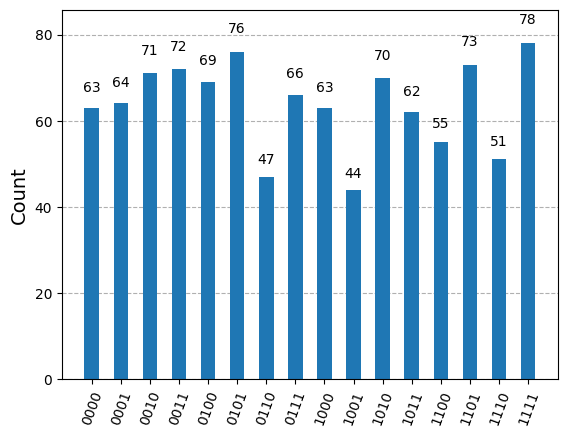

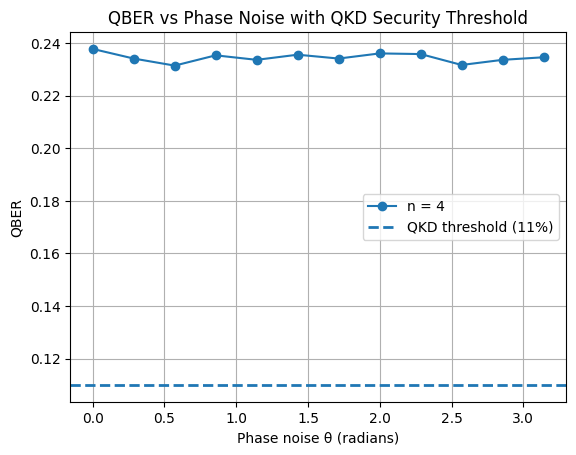

In [64]:
import matplotlib.pyplot as plt
import numpy as np

theta_vals = np.linspace(0, np.pi, 12)
qkd_threshold = 0.11

plt.figure()

for n in [2, 3, 4]:
    qber = []
    for t in theta_vals:
        theta_k = np.zeros(2**n)
        theta_k[1] = t          # disturb one subcarrier
        qber.append(run_qofdm_n(n, theta_vals=theta_k))
    plt.plot(theta_vals, qber, marker='o', label=f"n = {n}")

# --- QKD threshold line ---
plt.axhline(
    y=qkd_threshold,
    linestyle='--',
    linewidth=2,
    label="QKD threshold (11%)"
)

plt.xlabel("Phase noise θ (radians)")
plt.ylabel("QBER")
plt.title("QBER vs Phase Noise with QKD Security Threshold")
plt.legend()
plt.grid(True)
plt.show()


Measurement results (bitstrings):
{'11': 268, '00': 251, '01': 256, '10': 249}


<Figure size 640x480 with 0 Axes>

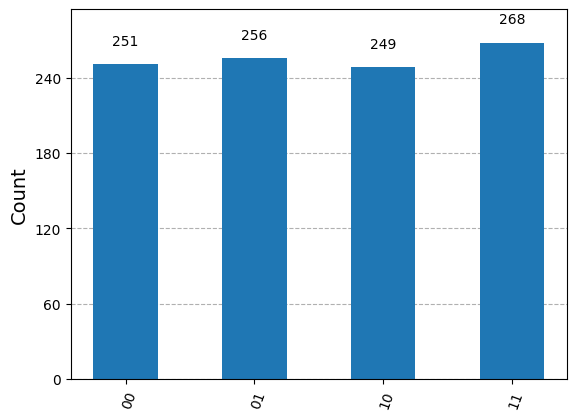

Measurement results (bitstrings):
{'11': 235, '01': 267, '10': 237, '00': 285}


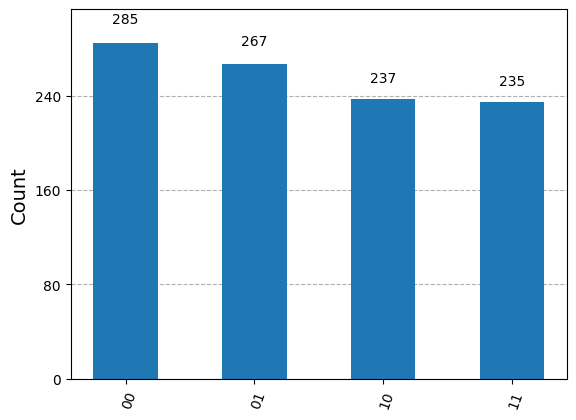

Measurement results (bitstrings):
{'10': 261, '01': 259, '11': 256, '00': 248}


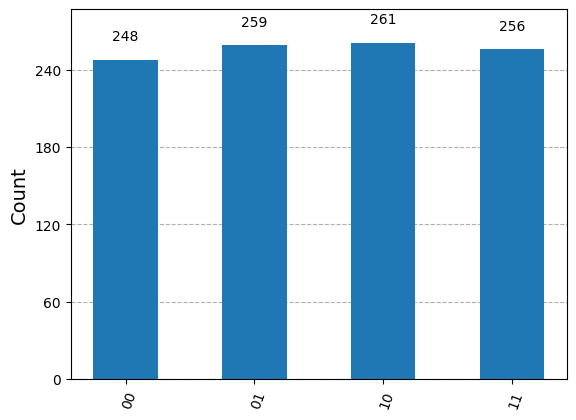

Measurement results (bitstrings):
{'11': 254, '00': 264, '01': 251, '10': 255}


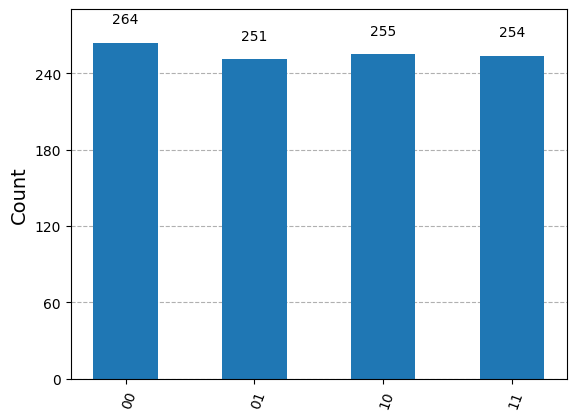

Measurement results (bitstrings):
{'00': 265, '11': 241, '10': 256, '01': 262}


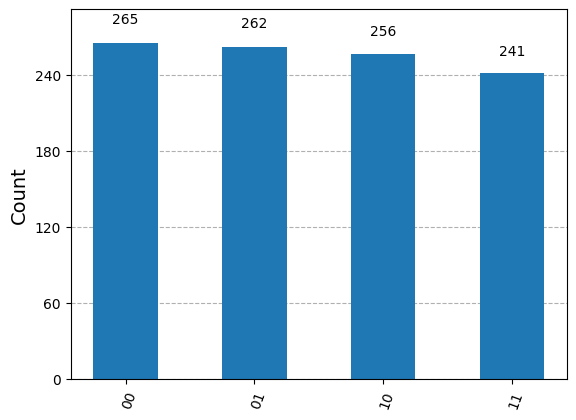

Measurement results (bitstrings):
{'11': 245, '10': 263, '01': 259, '00': 257}


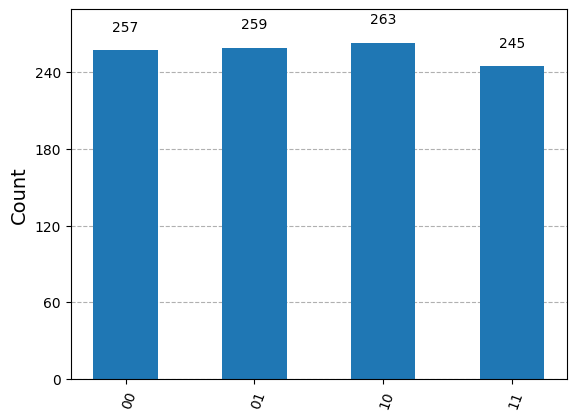

Measurement results (bitstrings):
{'00': 258, '10': 271, '11': 234, '01': 261}


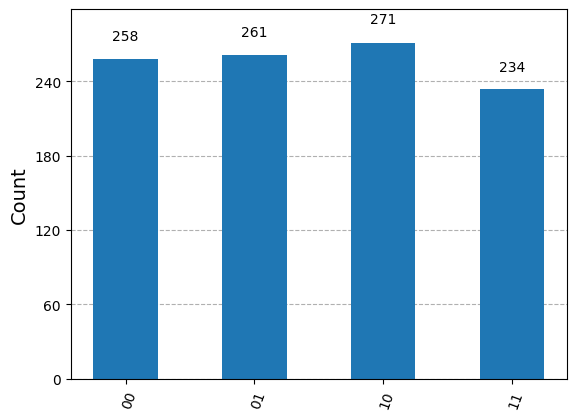

Measurement results (bitstrings):
{'01': 263, '11': 263, '10': 234, '00': 264}


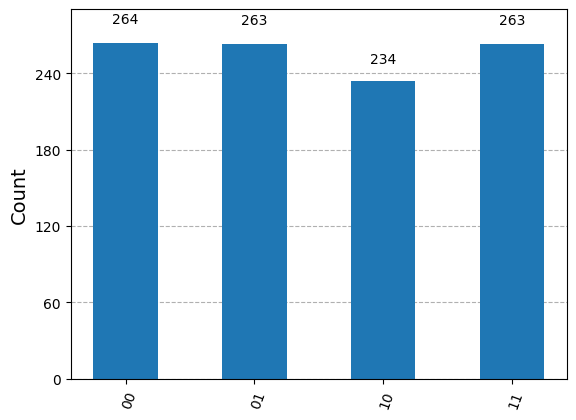

Measurement results (bitstrings):
{'01': 240, '00': 273, '11': 254, '10': 257}


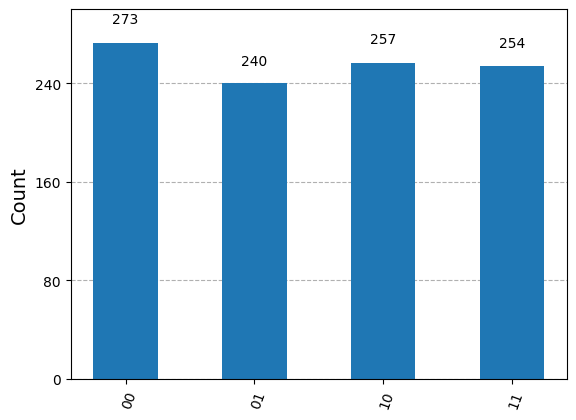

Measurement results (bitstrings):
{'01': 215, '00': 253, '10': 291, '11': 265}


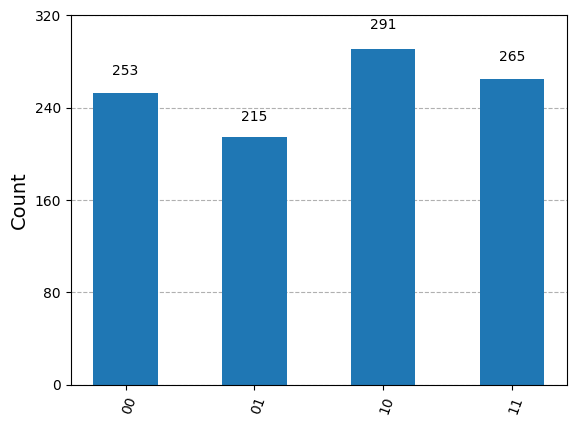

Measurement results (bitstrings):
{'00': 253, '10': 260, '11': 263, '01': 248}


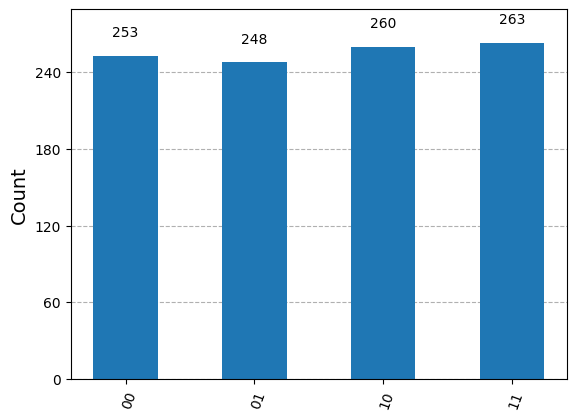

Measurement results (bitstrings):
{'00': 262, '10': 249, '11': 266, '01': 247}


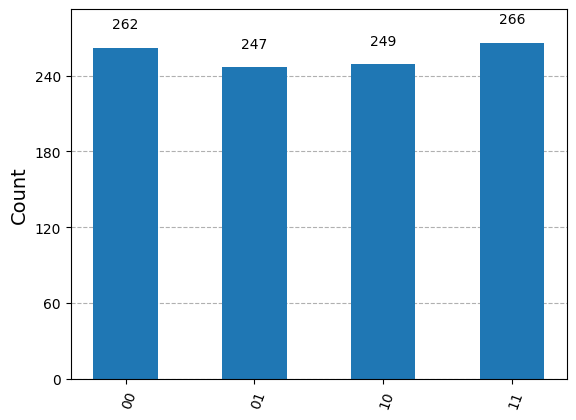

Measurement results (bitstrings):
{'000': 129, '101': 111, '011': 131, '001': 125, '110': 128, '100': 125, '010': 151, '111': 124}


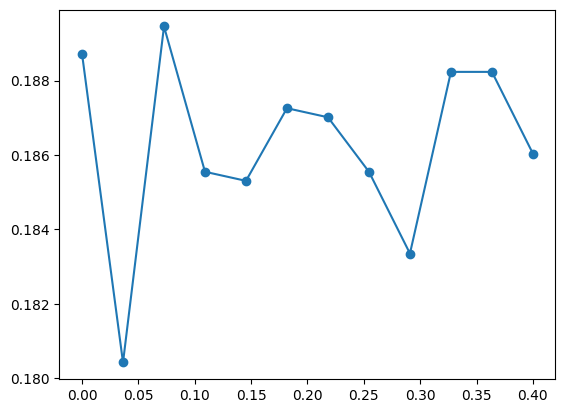

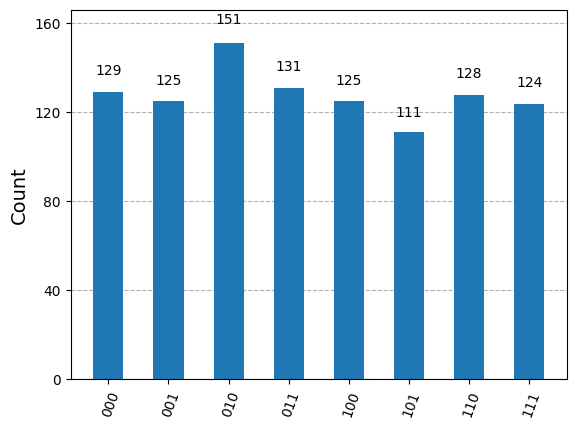

Measurement results (bitstrings):
{'111': 147, '011': 131, '010': 113, '101': 122, '100': 127, '000': 118, '110': 130, '001': 136}


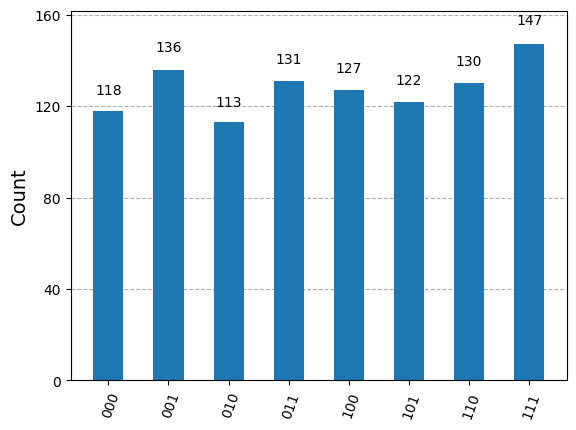

Measurement results (bitstrings):
{'101': 138, '001': 137, '100': 106, '111': 116, '010': 135, '011': 138, '110': 127, '000': 127}


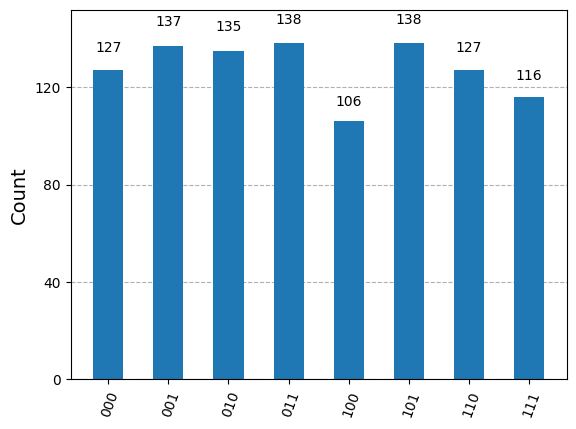

Measurement results (bitstrings):
{'001': 107, '000': 125, '010': 151, '100': 130, '101': 128, '111': 142, '110': 124, '011': 117}


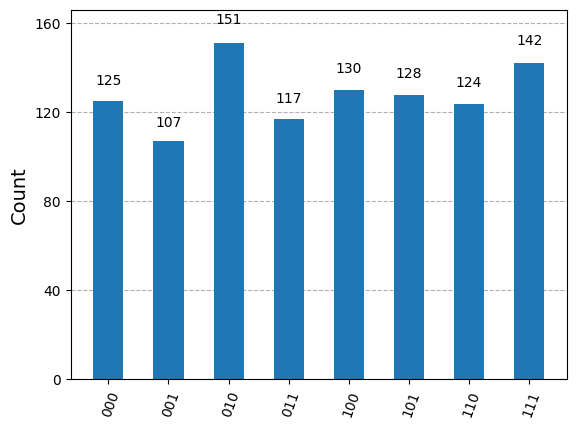

Measurement results (bitstrings):
{'101': 125, '111': 110, '110': 118, '010': 146, '011': 136, '000': 133, '001': 127, '100': 129}


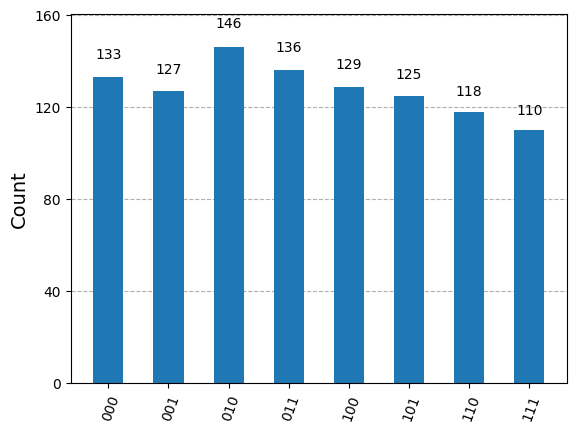

Measurement results (bitstrings):
{'010': 150, '111': 122, '011': 133, '101': 141, '110': 124, '000': 108, '100': 116, '001': 130}


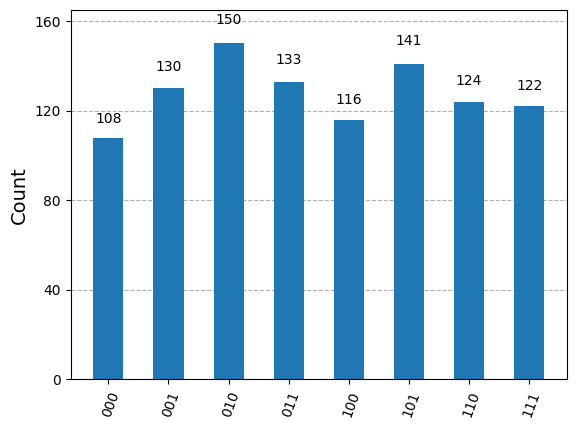

Measurement results (bitstrings):
{'111': 111, '110': 141, '100': 128, '011': 129, '001': 124, '101': 114, '000': 150, '010': 127}


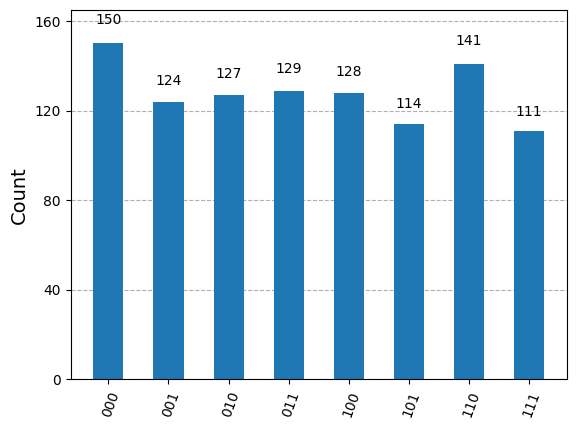

Measurement results (bitstrings):
{'100': 150, '000': 132, '010': 112, '001': 121, '111': 128, '110': 130, '101': 125, '011': 126}


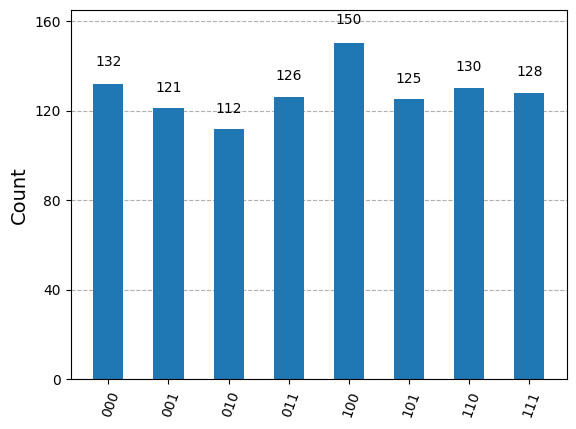

Measurement results (bitstrings):
{'011': 134, '100': 132, '101': 122, '000': 136, '001': 136, '110': 126, '111': 122, '010': 116}


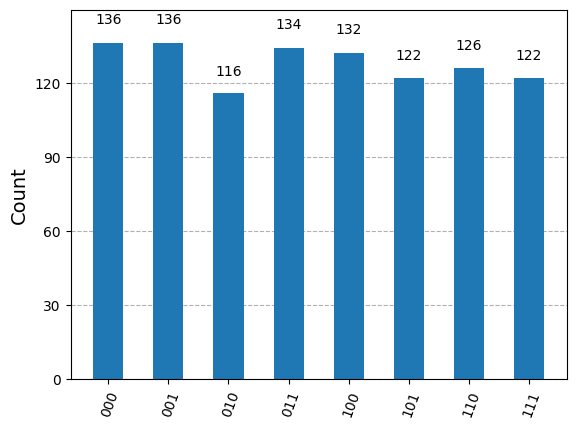

Measurement results (bitstrings):
{'010': 118, '101': 130, '000': 123, '100': 134, '111': 122, '011': 120, '110': 139, '001': 138}


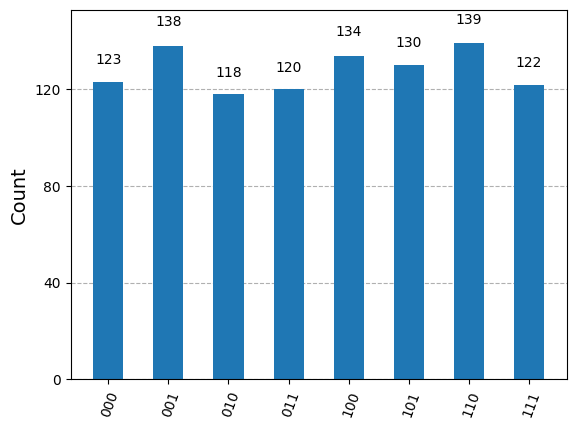

Measurement results (bitstrings):
{'001': 132, '110': 127, '010': 121, '100': 119, '111': 117, '101': 136, '011': 128, '000': 144}


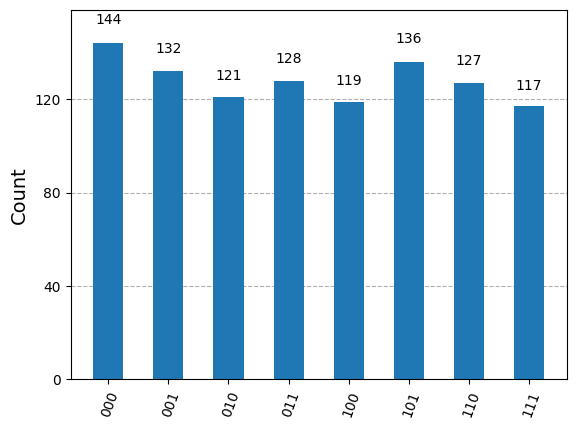

Measurement results (bitstrings):
{'001': 143, '000': 124, '110': 137, '010': 123, '011': 136, '101': 126, '111': 118, '100': 117}


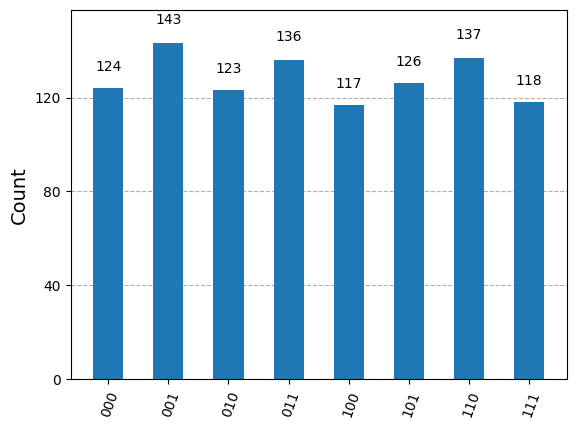

Measurement results (bitstrings):
{'0010': 56, '0110': 65, '0101': 72, '1110': 67, '1010': 61, '0011': 70, '1100': 60, '0111': 72, '0001': 55, '1111': 65, '1101': 50, '1001': 77, '0100': 69, '1011': 70, '0000': 50, '1000': 65}


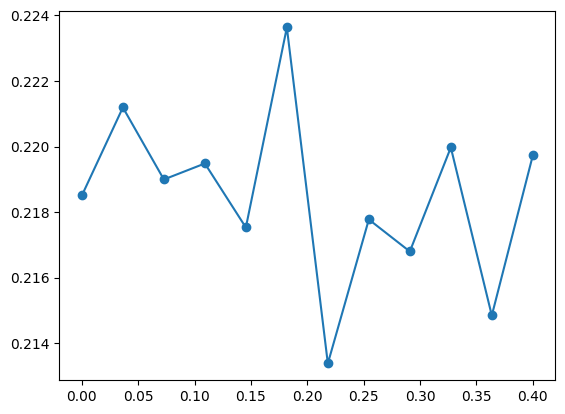

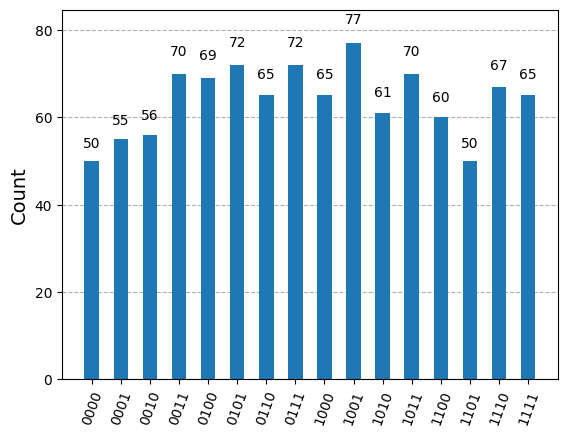

Measurement results (bitstrings):
{'0010': 62, '1011': 57, '0011': 66, '1101': 61, '0100': 75, '1111': 71, '0000': 61, '1010': 70, '1100': 64, '1001': 63, '1000': 69, '0001': 66, '0111': 63, '0110': 48, '0101': 67, '1110': 61}


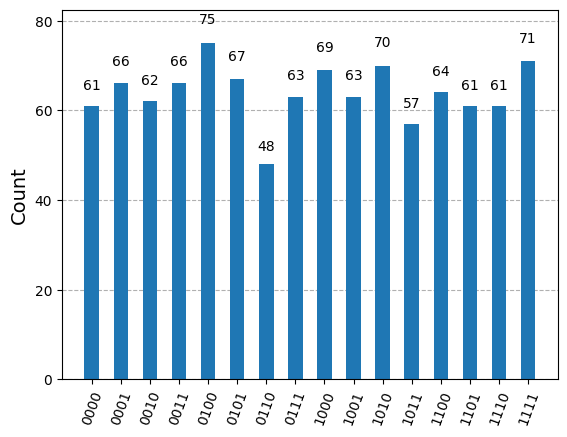

Measurement results (bitstrings):
{'0000': 62, '1000': 73, '1101': 74, '0010': 67, '1001': 57, '1010': 69, '1110': 55, '1111': 78, '0011': 64, '0001': 70, '1100': 64, '1011': 68, '0110': 50, '0111': 53, '0101': 52, '0100': 68}


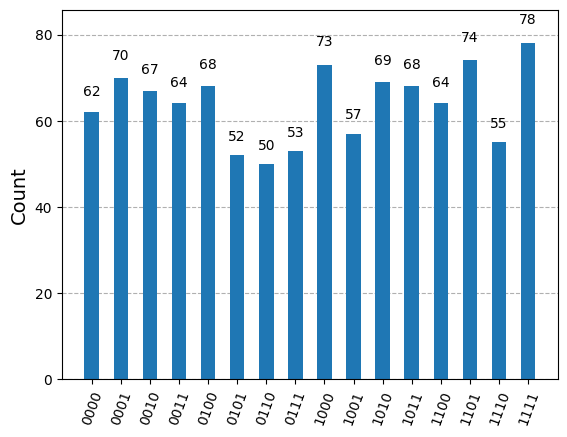

Measurement results (bitstrings):
{'1100': 66, '0011': 62, '1011': 65, '0001': 59, '0000': 63, '0100': 62, '0111': 76, '1111': 70, '1010': 64, '1110': 59, '0010': 60, '0110': 59, '1000': 64, '1001': 62, '0101': 63, '1101': 70}


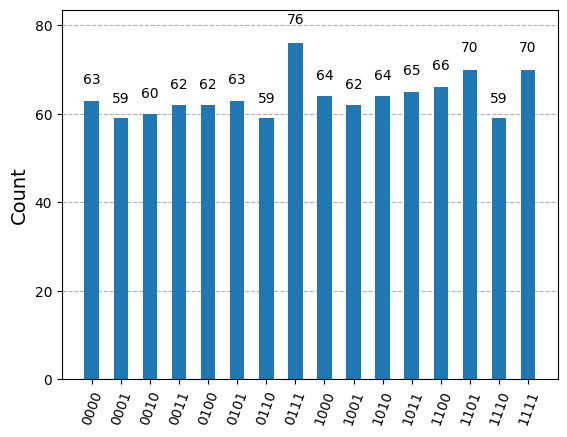

Measurement results (bitstrings):
{'1000': 62, '0111': 64, '1111': 57, '1101': 66, '0100': 63, '1110': 63, '0010': 59, '1001': 64, '0011': 90, '0110': 59, '0000': 76, '0001': 46, '1010': 56, '1100': 74, '1011': 61, '0101': 64}


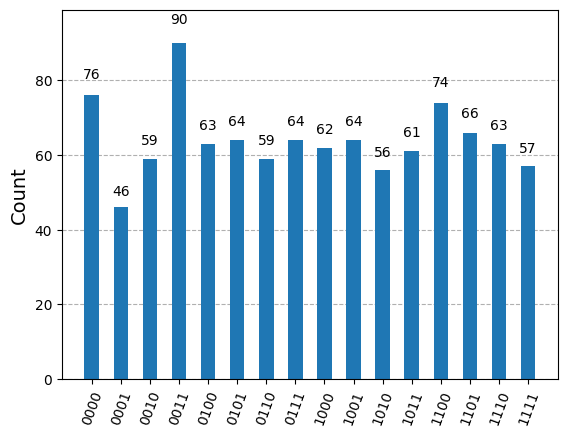

Measurement results (bitstrings):
{'1010': 69, '0101': 70, '0011': 55, '0111': 66, '1000': 68, '0110': 73, '1111': 62, '1011': 58, '0001': 58, '1101': 61, '0010': 69, '0000': 51, '1110': 66, '0100': 56, '1001': 76, '1100': 66}


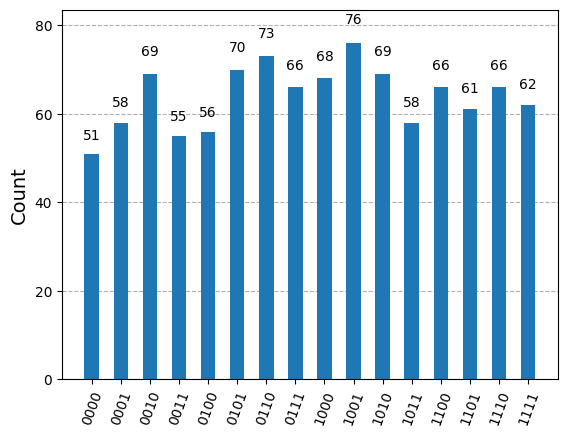

Measurement results (bitstrings):
{'0110': 67, '1111': 61, '0111': 60, '0010': 72, '1011': 63, '1100': 53, '1001': 69, '1101': 61, '0001': 57, '0011': 65, '0100': 77, '1000': 61, '0000': 57, '1010': 63, '1110': 65, '0101': 73}


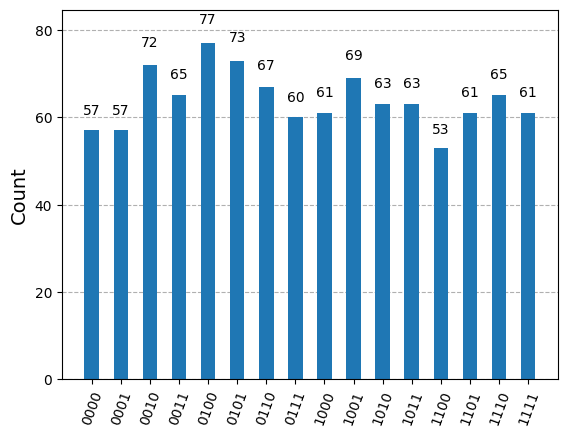

Measurement results (bitstrings):
{'0001': 62, '1100': 60, '0111': 63, '0110': 76, '1111': 52, '0100': 56, '1101': 59, '0000': 77, '1110': 74, '1000': 61, '1001': 50, '0101': 76, '1011': 65, '0011': 77, '1010': 57, '0010': 59}


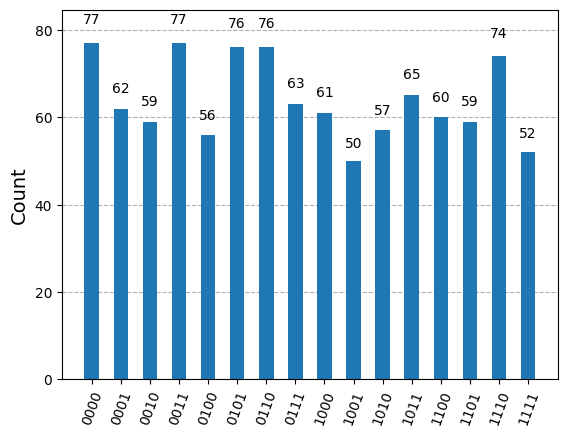

Measurement results (bitstrings):
{'0010': 75, '0011': 69, '1100': 65, '1111': 70, '1010': 63, '0100': 71, '0111': 50, '0000': 63, '1101': 71, '1110': 61, '0110': 55, '0101': 55, '1000': 74, '1011': 64, '1001': 58, '0001': 60}


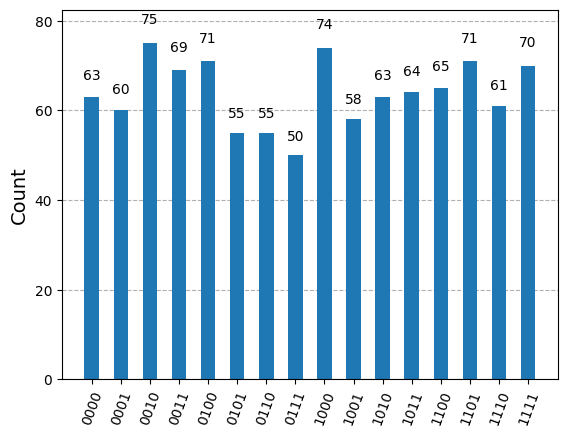

Measurement results (bitstrings):
{'0001': 72, '1001': 62, '0000': 61, '0101': 56, '1101': 73, '1100': 65, '0011': 56, '0111': 65, '1111': 63, '1010': 59, '0110': 61, '0100': 61, '0010': 63, '1011': 76, '1110': 63, '1000': 68}


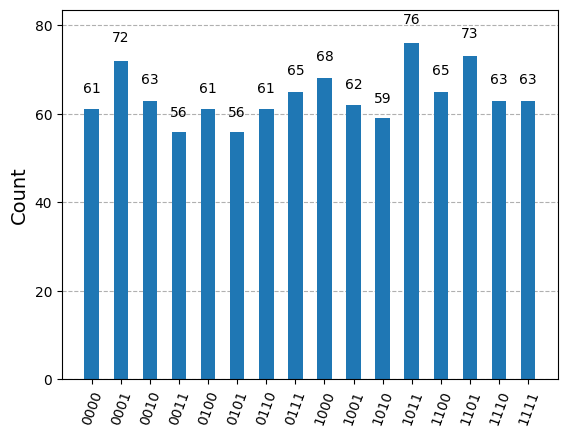

Measurement results (bitstrings):
{'1010': 69, '0001': 57, '1000': 66, '0111': 67, '1101': 66, '0100': 64, '1110': 60, '0110': 71, '0000': 54, '1011': 64, '1111': 61, '0101': 60, '0010': 71, '1001': 57, '1100': 56, '0011': 81}


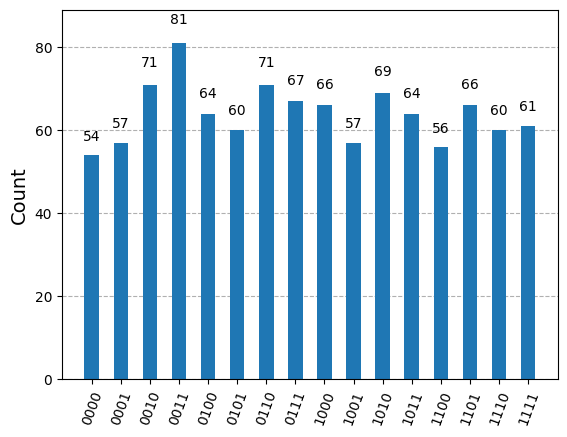

Measurement results (bitstrings):
{'0110': 67, '1111': 61, '1000': 57, '0000': 68, '0100': 63, '1101': 70, '0011': 58, '1110': 55, '0001': 59, '1011': 63, '0111': 73, '0101': 71, '1001': 75, '1010': 74, '0010': 64, '1100': 46}


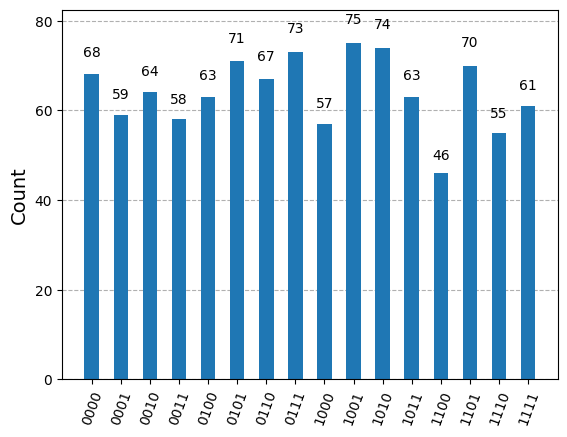

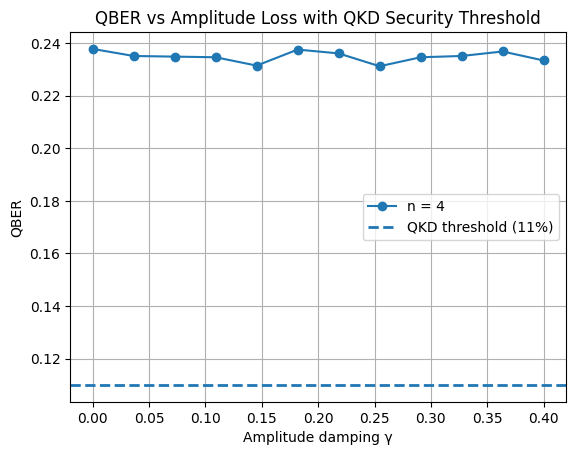

In [65]:
gamma_vals = np.linspace(0, 0.4, 12)
qkd_threshold = 0.11

plt.figure()

for n in [2, 3, 4]:
    qber = []
    for g in gamma_vals:
        qber.append(run_qofdm_n(n, gamma=g))
    plt.plot(gamma_vals, qber, marker='o', label=f"n = {n}")

# --- QKD threshold line ---
plt.axhline(
    y=qkd_threshold,
    linestyle='--',
    linewidth=2,
    label="QKD threshold (11%)"
)

plt.xlabel("Amplitude damping γ")
plt.ylabel("QBER")
plt.title("QBER vs Amplitude Loss with QKD Security Threshold")
plt.legend()
plt.grid(True)
plt.show()


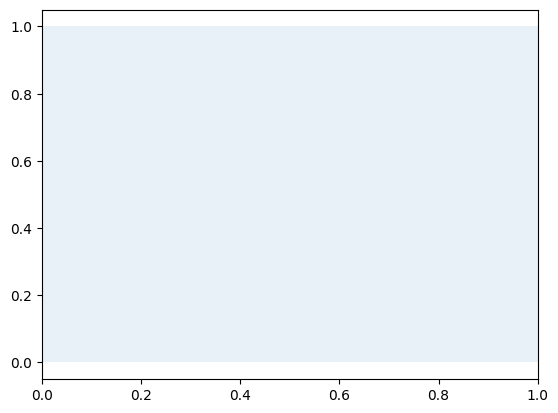

In [66]:
plt.axhspan(0, qkd_threshold, alpha=0.1, label="Secure region")
plt.axhspan(qkd_threshold, 1, alpha=0.1, label="Insecure region")
